In [1]:
# Import the dataset saved on the google drive
from google.colab import drive

# Graphing capabilities
import matplotlib.pyplot as plt

# Data management
import pandas as pd
import numpy as np

# For stratified 10-fold cross validation
from sklearn.model_selection import StratifiedKFold

# Scikit-Learn ML Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Keras-TensorFlow DNN Model
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout
from keras.regularizers import l2

# Fast.ai DNN Model
from fastai.tabular import *

# Normalization
from keras.utils import normalize, to_categorical

print('Imports complete.')

Imports complete.


## Functions Used


In [2]:
def train_and_eval_on(X, y, feature_set):
    """
    train_and_eval_on function
        Description: This function will train all the models on the given feature set of the X (data) for predicting y (target)

        Args: 
            X => pd.DataFrame object containing the data
            y => pd.Series object containings the target classifications
            feature_set => list of features in X to use for training

        Returns:
            metrics => dictionary where the model names are the key and a list of accuracies across all folds is the value
                    Keys:
                        Random Forest => rf
                        Decision Tree => dt
                        k-Nearest Neighbors => knn
                        Support Vector Machine => svm
                        Logistic Regression => lr
                        Linear Discriminant Analysis => lda
                        AdaBoost => ab
                        Naive Bayes => nb
                        Keras-TensorFlow => keras
                        Fast.ai => fastai
    """
    metrics = {'rf':[],
                'dt':[],
                'knn':[],
                'svm':[],
                'lr':[],
                'lda':[],
                'ab':[],
                'nb':[],
                'keras':[],
                'fastai':[]}

    # Select the given features within the data
    X = X[feature_set]

    print('Training with {} features'.format(len(X.columns)))

    # Create stratified, 10-fold cross validation object
    random_state = 0
    sss = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    # Experiment with 10-fold cross validation
    for train_idx, test_idx in sss.split(X, y):
        # Split the data into the training and testing sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Random Forest Model
        rf = RandomForestClassifier(random_state=random_state)
        rf.fit(X_train, y_train)
        score = rf.score(X_test, y_test)
        metrics['rf'].append(score)

        """# Decision Tree Model
        dt = DecisionTreeClassifier(random_state=random_state)
        dt.fit(X_train, y_train)
        score = dt.score(X_test, y_test)
        metrics['dt'].append(score)

        # k-Nearest Neighbors Model
        knn = KNeighborsClassifier()
        knn.fit(X_train, y_train)
        score = knn.score(X_test, y_test)
        metrics['knn'].append(score)

        # Support Vector Machine Model
        svm = SVC(random_state=random_state)
        svm.fit(X_train, y_train)
        score = svm.score(X_test, y_test)
        metrics['svm'].append(score)

        # Logistic Regression Model
        lr = LogisticRegression(random_state=random_state)
        lr.fit(X_train, y_train)
        score = lr.score(X_test, y_test)
        metrics['lr'].append(score)

        # Linear Discriminant Analysis Model
        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train, y_train)
        score = lda.score(X_test, y_test)
        metrics['lda'].append(score)

        # AdaBoost Model
        ab = AdaBoostClassifier(random_state=random_state)
        ab.fit(X_train, y_train)
        score = ab.score(X_test, y_test)
        metrics['ab'].append(score)

        # Naive Bayes Model
        nb = GaussianNB()
        nb.fit(X_train, y_train)
        score = nb.score(X_test, y_test)
        metrics['nb'].append(score)"""

        # TO-DO: Add DNN models

        # Keras-TensorFlow DNN Model
        dnn_keras = Sequential(layers=[
                                 Dense(128, kernel_regularizer=l2(0.001), activation='relu',input_shape=(len(X_train.columns),)),
                                 BatchNormalization(),
                                 Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
                                 BatchNormalization(),
                                 Dense(y_train.nunique(), activation='softmax')
        ])
        dnn_keras.compile(
            optimizer='adam', 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])
        dnn_keras.fit(X_train, pd.get_dummies(y_train), epochs=100, verbose=0, batch_size=512)
        _, score = dnn_keras.evaluate(X_test, pd.get_dummies(y_test), verbose=0)
        metrics['keras'].append(score)

        # Fast.ai DNN Model
        data_fold = (TabularList.from_df(df, path=path, cont_names=X_train.columns, procs=[Categorify, Normalize])
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=dep_var)
                     .databunch(num_workers=0))
        dnn_fastai = tabular_learner(data_fold, layers=[200, 100], metrics=accuracy)
        dnn_fastai.fit_one_cycle(cyc_len=10, callbacks=None)
        _, score = dnn_fastai.validate()
        metrics['fastai'].append(score)

    return metrics

In [3]:
def show_graph(figure, feature_count, metrics_dict):
  """
  show_graph function

    Description: This function will take the metrics dictionary provided and update the graph already to show the most recent results

    Args:
      figure => matplotlib.pyplot.figure object
      metrics_dict => dictionary of metrics as described in `train_and_eval_on` function

    Returns:
      nothing
  """
  # Reorganize the data so we have all of the random forest metrics with increasing features side by side
  reorganized_dictionary = {}

  for feature_vals in metrics_dict.keys():
    for key in metrics_dict[feature_vals].keys():
      # If a given model is not in the new dictionary, add it
      if key not in reorganized_dictionary:
        reorganized_dictionary[key] = {}

      # If there isn't a specific feature number in the model dictionary, add it
      if feature_vals not in reorganized_dictionary[key]:
        reorganized_dictionary[key][feature_vals] = []

      # If there is anything to the record, add it
      if len( metrics_dict[feature_vals][key] ) > 0:
        accuracies = metrics_dict[feature_vals][key]
        mean = np.mean(accuracies)
        std = np.std(accuracies)

        #print('Accuracies: {}'.format(accuracies))
        #print('Mean: {}'.format(mean))
        #print('Std: {}'.format(std))

        reorganized_dictionary[key][feature_vals].append( [mean, std] ) 

  #print('Models: {}'.format( list(reorganized_dictionary.keys()) ))

  for model in reorganized_dictionary.keys():
    # The x-axis will have the feature_count
    xs = []

    # The y-axis will have the accuracy for that feature_count value
    ys = []

    # The y-axis will also have the std for these accuracies since they are accumulated over 10 folds
    yerrs = []

    for x in reorganized_dictionary[model].keys():
      if len(reorganized_dictionary[model][x]) > 0:
        xs.append(x)
        ys.append(reorganized_dictionary[model][x][0][0])
        yerrs.append(reorganized_dictionary[model][x][0][1])
    #print('xs: {}'.format(xs))
    #print('ys: {}'.format(ys))
    if len(xs) > 0:
      plt.errorbar(x=xs, y=ys, yerr=yerrs, label=model)

  #print(reorganized_dictionary)

  plt.legend()
  plt.show()


## Data Preparation

In [4]:
# These are the best features for multi-class experiment provided from the feature selection jupyter notebook
best_features_multiclass = ['Entropy_Afterpath', 'argPathRatio', 'NumberRate_AfterPath', 'NumberRate_Domain', 'ArgUrlRatio', 'Extension_DigitCount', 'dld_getArg', 'ldl_getArg', 'Query_DigitCount', 'LongestVariableValue', 'Querylength', 'Query_LetterCount', 'ldl_path', 'ArgLen', 'ldl_url', 'dld_path', 'Extension_LetterCount', 'argDomanRatio', 'dld_url', 'URL_DigitCount', 'LongestPathTokenLength', 'URLQueries_variable', 'fileNameLen', 'delimeter_Count', 'NumberRate_URL', 'SymbolCount_Domain', 'domain_token_count', 'tld', 'SymbolCount_Extension', 'this.fileExtLen', 'pathLength', 'subDirLen', 'urlLen', 'charcompace', 'host_DigitCount', 'SymbolCount_Afterpath', 'URL_Letter_Count', 'pathDomainRatio', 'SymbolCount_FileName', 'domainUrlRatio', 'NumberRate_Extension', 'NumberRate_FileName', 'SymbolCount_URL', 'Entropy_Filename', 'Entropy_DirectoryName', 'delimeter_path', 'Arguments_LongestWordLength', 'charcompvowels', 'CharacterContinuityRate', 'spcharUrl', 'executable', 'pathurlRatio', 'Filename_LetterCount', 'Entropy_Extension', 'dld_filename', 'ldl_filename', 'SymbolCount_Directoryname', 'avgdomaintokenlen', 'path_token_count', 'File_name_DigitCount', 'NumberRate_DirectoryName', 'delimeter_Domain', 'Domain_LongestWordLength', 'NumberofDotsinURL', 'Directory_DigitCount', 'Directory_LetterCount', 'URL_sensitiveWord', 'longdomaintokenlen', 'ldl_domain', 'domainlength', 'Entropy_Domain', 'host_letter_count', 'avgpathtokenlen', 'isPortEighty', 'sub-Directory_LongestWordLength', 'dld_domain', 'Path_LongestWordLength', 'Entropy_URL']

## Data Preparation

In [5]:
# Set up google drive access
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# Import the data
path = '/content/gdrive/My Drive/FinalDataset/'
fille = 'All.csv'
df = pd.read_csv(path + fille)
print('Data Read:')
print(df.head())

Data Read:
   Querylength  domain_token_count  ...  Entropy_Afterpath  URL_Type_obf_Type
0            0                   4  ...               -1.0         Defacement
1            0                   4  ...               -1.0         Defacement
2            0                   4  ...               -1.0         Defacement
3            0                   4  ...               -1.0         Defacement
4            0                   4  ...               -1.0         Defacement

[5 rows x 80 columns]


In [7]:
dep_var = 'URL_Type_obf_Type'

print('There are {} columns and {} rows in the provided data.'.format(len(df.columns), len(df)))

There are 80 columns and 36697 rows in the provided data.


In [8]:
print('Below is the dataset\'s composition')
print(df[dep_var].value_counts())

Below is the dataset's composition
Defacement    7930
benign        7781
phishing      7577
malware       6711
spam          6698
Name: URL_Type_obf_Type, dtype: int64


In [9]:
# Removes all rows if they contain NaN values
df.dropna(axis='index', inplace=True)

In [10]:
print('There are {} columns and {} rows in the provided data.'.format(len(df.columns), len(df)))

print('Below is the dataset\'s composition')
print(df[dep_var].value_counts())

There are 80 columns and 18982 rows in the provided data.
Below is the dataset's composition
spam          5342
malware       4440
phishing      4014
benign        2709
Defacement    2477
Name: URL_Type_obf_Type, dtype: int64


In [11]:
# Create the X (data) and y (labels)
X = normalize( df.loc[:, df.columns != dep_var] )
y = df[dep_var]

## Multi-class Experiments

In [12]:
fig = plt.figure()
multi_performance_metrics = {}
for i in range(1, 21):
    features = best_features_multiclass[:i]
    multi_performance_metrics[i] = train_and_eval_on(X=X, y=y, feature_set=features)

    #print(performance_metrics)

    #show_graph(figure=fig, feature_count=len(features), metrics_dict=multi_performance_metrics)

Training with 1 features


epoch,train_loss,valid_loss,accuracy,time
0,1.464365,1.431266,0.416008,00:02
1,1.455965,1.423092,0.419168,00:02
2,1.453527,1.472396,0.317536,00:02
3,1.453205,1.444784,0.317536,00:02
4,1.459115,1.440254,0.317536,00:02
5,1.446187,1.445003,0.317536,00:02
6,1.430208,1.425541,0.317536,00:02
7,1.419657,1.416479,0.335440,00:02
8,1.425217,1.406298,0.414955,00:02
9,1.420436,1.412956,0.418641,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.461566,1.468362,0.384939,00:02
1,1.444220,1.458259,0.388626,00:02
2,1.473552,1.502766,0.384939,00:02
3,1.450466,1.457583,0.384939,00:02
4,1.443066,1.470161,0.370721,00:02
5,1.445869,1.459592,0.384939,00:02
6,1.430243,1.453328,0.335440,00:02
7,1.424312,1.447416,0.395471,00:02
8,1.430260,1.446522,0.394418,00:02
9,1.410668,1.442160,0.395998,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.456870,1.448702,0.406744,00:02
1,1.449326,1.455596,0.406217,00:02
2,1.453579,1.460045,0.395153,00:02
3,1.441500,1.455083,0.381454,00:02
4,1.449990,1.447548,0.384615,00:02
5,1.437519,1.442202,0.412540,00:02
6,1.441135,1.438648,0.332982,00:02
7,1.438750,1.437341,0.406744,00:02
8,1.427796,1.438307,0.402529,00:02
9,1.435882,1.440303,0.406744,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.459554,1.500699,0.373024,00:02
1,1.453594,1.524569,0.332982,00:02
2,1.454090,1.444500,0.395680,00:02
3,1.453986,1.449591,0.387250,00:02
4,1.441429,1.464964,0.384089,00:02
5,1.441412,1.454060,0.387250,00:02
6,1.440880,1.469675,0.326660,00:02
7,1.440109,1.507756,0.327187,00:02
8,1.436322,1.443930,0.396207,00:02
9,1.427753,1.454571,0.390411,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.459098,1.455897,0.377239,00:02
1,1.449553,1.447101,0.393572,00:02
2,1.464593,1.481417,0.311907,00:02
3,1.456730,1.459463,0.384615,00:02
4,1.452596,1.439336,0.393572,00:02
5,1.445773,1.438121,0.389357,00:02
6,1.438511,1.436790,0.393045,00:02
7,1.430045,1.440699,0.394099,00:02
8,1.431872,1.433874,0.395680,00:02
9,1.427611,1.444893,0.396207,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.452409,1.463946,0.383562,00:02
1,1.452242,1.466245,0.383035,00:02
2,1.459195,1.467585,0.398314,00:02
3,1.444651,1.477326,0.307165,00:02
4,1.440204,1.462586,0.393045,00:02
5,1.453489,1.457759,0.396207,00:02
6,1.433432,1.449622,0.396207,00:02
7,1.424284,1.448753,0.399368,00:02
8,1.441913,1.444751,0.396207,00:02
9,1.425641,1.445402,0.396207,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.461355,1.454016,0.397787,00:02
1,1.450421,1.469804,0.386723,00:02
2,1.447854,1.492019,0.324025,00:02
3,1.451298,1.454778,0.391992,00:02
4,1.435464,1.462164,0.386723,00:02
5,1.441389,1.443673,0.404636,00:02
6,1.439713,1.465233,0.347734,00:02
7,1.433385,1.441013,0.394099,00:02
8,1.430551,1.433959,0.399368,00:02
9,1.429470,1.436269,0.395153,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.460252,1.477331,0.383562,00:02
1,1.458492,1.493674,0.364067,00:02
2,1.462819,1.469982,0.377239,00:02
3,1.444906,1.505248,0.331401,00:02
4,1.442302,1.478973,0.388830,00:02
5,1.450783,1.466823,0.394626,00:02
6,1.441630,1.475152,0.339831,00:02
7,1.422627,1.480026,0.339831,00:02
8,1.426434,1.460169,0.339305,00:02
9,1.423177,1.459844,0.338778,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.464169,1.456368,0.394099,00:02
1,1.450212,1.463197,0.394099,00:02
2,1.461595,1.508097,0.349842,00:02
3,1.444604,1.451000,0.394626,00:02
4,1.447537,1.433228,0.408851,00:02
5,1.438836,1.438784,0.408325,00:02
6,1.439577,1.461950,0.319283,00:02
7,1.431030,1.437975,0.407798,00:02
8,1.433521,1.440416,0.403056,00:02
9,1.435212,1.431090,0.409378,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.465002,1.452855,0.403056,00:02
1,1.452969,1.481376,0.300843,00:02
2,1.466166,1.454004,0.405690,00:02
3,1.465649,1.459061,0.379874,00:02
4,1.463566,1.453171,0.394626,00:02
5,1.454464,1.447563,0.397787,00:02
6,1.436775,1.445112,0.394099,00:02
7,1.443127,1.449625,0.400948,00:02
8,1.441824,1.448544,0.320864,00:02
9,1.428696,1.442823,0.319810,00:02


Training with 2 features


epoch,train_loss,valid_loss,accuracy,time
0,1.318270,1.299805,0.458662,00:02
1,1.295127,1.283618,0.467088,00:02
2,1.298058,1.239576,0.450764,00:02
3,1.272071,1.266640,0.483939,00:02
4,1.255043,1.234295,0.453397,00:02
5,1.260584,1.218041,0.474460,00:02
6,1.230205,1.204157,0.490258,00:02
7,1.201302,1.182711,0.506582,00:02
8,1.205634,1.174476,0.508162,00:02
9,1.179271,1.164873,0.521854,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.302400,1.303318,0.457083,00:02
1,1.299345,1.302539,0.467615,00:02
2,1.285867,1.278621,0.443391,00:02
3,1.273703,1.287210,0.460769,00:02
4,1.254775,1.356699,0.413902,00:02
5,1.238181,1.218126,0.504476,00:02
6,1.217944,1.231255,0.464982,00:02
7,1.215813,1.202707,0.502896,00:02
8,1.206225,1.184252,0.538178,00:02
9,1.184668,1.179846,0.529752,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.325445,1.309257,0.490516,00:02
1,1.304815,1.302265,0.472076,00:02
2,1.291128,1.267304,0.485248,00:02
3,1.263966,1.247579,0.503161,00:02
4,1.269140,1.281310,0.473130,00:02
5,1.242041,1.260743,0.478925,00:02
6,1.237957,1.229558,0.489463,00:02
7,1.222425,1.209341,0.521075,00:02
8,1.222421,1.201879,0.505796,00:02
9,1.203159,1.205444,0.515279,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.309554,1.308212,0.481033,00:02
1,1.300194,1.303586,0.408851,00:02
2,1.284130,1.252463,0.502634,00:02
3,1.288633,1.250934,0.463119,00:02
4,1.257656,1.223411,0.491043,00:02
5,1.241723,1.229467,0.502108,00:02
6,1.214520,1.228253,0.483140,00:02
7,1.217401,1.203389,0.509484,00:02
8,1.200644,1.191075,0.518440,00:02
9,1.197820,1.191952,0.510537,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.330811,1.321764,0.440991,00:02
1,1.308099,1.323396,0.423077,00:02
2,1.280836,1.318817,0.430453,00:02
3,1.281537,1.291423,0.437829,00:02
4,1.258706,1.280752,0.461538,00:02
5,1.246169,1.261359,0.447313,00:02
6,1.226641,1.233469,0.473656,00:02
7,1.222951,1.216149,0.480506,00:02
8,1.201698,1.187118,0.497893,00:02
9,1.190292,1.207380,0.505269,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.300680,1.329290,0.423604,00:02
1,1.316267,1.303992,0.454162,00:02
2,1.284652,1.280286,0.464700,00:02
3,1.278934,1.293576,0.461538,00:02
4,1.271928,1.251657,0.479452,00:02
5,1.245589,1.212898,0.502108,00:02
6,1.214772,1.211977,0.496839,00:02
7,1.205608,1.210607,0.495258,00:02
8,1.181776,1.193540,0.523709,00:02
9,1.174275,1.183764,0.526344,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.306352,1.281846,0.503161,00:02
1,1.305364,1.275623,0.433614,00:02
2,1.300270,1.272387,0.488409,00:02
3,1.272964,1.305215,0.349842,00:02
4,1.243414,1.222778,0.516333,00:02
5,1.259502,1.260999,0.512645,00:02
6,1.229775,1.222158,0.486828,00:02
7,1.206852,1.173348,0.520021,00:02
8,1.194858,1.197616,0.493678,00:02
9,1.191546,1.175004,0.517387,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.319040,1.310154,0.419389,00:02
1,1.292025,1.264116,0.510011,00:02
2,1.286337,1.273288,0.469442,00:02
3,1.269056,1.248156,0.507376,00:02
4,1.264474,1.261755,0.492624,00:02
5,1.248615,1.249106,0.501581,00:02
6,1.229746,1.232219,0.513699,00:02
7,1.195444,1.204561,0.511064,00:02
8,1.191840,1.216735,0.523182,00:02
9,1.191856,1.190698,0.517387,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.303107,1.293344,0.474710,00:02
1,1.292212,1.290450,0.447313,00:02
2,1.280795,1.270573,0.456270,00:02
3,1.264164,1.252411,0.472603,00:02
4,1.268860,1.262309,0.450474,00:02
5,1.262886,1.235601,0.474183,00:02
6,1.244785,1.245902,0.449420,00:02
7,1.232277,1.206784,0.506322,00:02
8,1.206483,1.198463,0.507903,00:02
9,1.213706,1.185462,0.514225,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.310876,1.296018,0.468915,00:02
1,1.277218,1.261099,0.479979,00:02
2,1.274941,1.256250,0.477345,00:02
3,1.279171,1.276360,0.463646,00:02
4,1.234551,1.231978,0.475764,00:02
5,1.238387,1.209356,0.489989,00:02
6,1.219684,1.198234,0.481560,00:02
7,1.208795,1.186435,0.509484,00:02
8,1.191752,1.176942,0.506322,00:02
9,1.200543,1.179242,0.506322,00:02


Training with 3 features


epoch,train_loss,valid_loss,accuracy,time
0,1.231416,1.178909,0.537125,00:02
1,1.206709,1.174997,0.518694,00:02
2,1.200145,1.173632,0.525013,00:02
3,1.198549,1.147453,0.533965,00:02
4,1.150616,1.131395,0.515008,00:02
5,1.143545,1.087370,0.558715,00:02
6,1.114083,1.074953,0.574513,00:02
7,1.120365,1.057651,0.585045,00:02
8,1.069777,1.027644,0.599263,00:02
9,1.085586,1.042961,0.595050,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.246865,1.238093,0.486572,00:02
1,1.208137,1.211600,0.525540,00:02
2,1.202337,1.229730,0.503949,00:02
3,1.164119,1.216440,0.492891,00:02
4,1.157894,1.172743,0.520800,00:02
5,1.128555,1.116897,0.556609,00:02
6,1.109654,1.126430,0.568194,00:02
7,1.094357,1.095678,0.563454,00:02
8,1.076549,1.085282,0.581885,00:02
9,1.060923,1.048779,0.589257,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.272418,1.301275,0.444152,00:02
1,1.235388,1.224274,0.483667,00:02
2,1.203685,1.161336,0.550053,00:02
3,1.161346,1.143433,0.548999,00:02
4,1.148935,1.144907,0.532666,00:02
5,1.123930,1.097436,0.581138,00:02
6,1.099300,1.119666,0.555321,00:02
7,1.103070,1.067568,0.570074,00:02
8,1.079242,1.059841,0.595364,00:02
9,1.079310,1.073123,0.569020,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.250633,1.221699,0.504215,00:02
1,1.211008,1.174855,0.513172,00:02
2,1.208727,1.190477,0.543730,00:02
3,1.170077,1.168535,0.502634,00:02
4,1.156983,1.139484,0.554268,00:02
5,1.140354,1.122012,0.522129,00:02
6,1.111521,1.090308,0.570601,00:02
7,1.091949,1.087762,0.567439,00:02
8,1.088820,1.058037,0.577977,00:02
9,1.052738,1.052902,0.581138,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.253650,1.253309,0.513699,00:02
1,1.222455,1.186932,0.534247,00:02
2,1.189688,1.209268,0.534247,00:02
3,1.183265,1.194128,0.506322,00:02
4,1.162631,1.182438,0.528978,00:02
5,1.115447,1.115117,0.536354,00:02
6,1.110078,1.130756,0.523182,00:02
7,1.098322,1.074300,0.589041,00:02
8,1.093933,1.065879,0.573235,00:02
9,1.079109,1.062922,0.572708,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.257803,1.222940,0.497366,00:02
1,1.196370,1.189898,0.555848,00:02
2,1.187437,1.195363,0.484721,00:02
3,1.188404,1.144483,0.550580,00:02
4,1.141725,1.149223,0.568493,00:02
5,1.139775,1.147892,0.541096,00:02
6,1.096418,1.131418,0.525817,00:02
7,1.083306,1.087018,0.559536,00:02
8,1.085378,1.078773,0.578504,00:02
9,1.057234,1.078521,0.571127,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.248561,1.193233,0.517914,00:02
1,1.191419,1.138244,0.554795,00:02
2,1.188286,1.165370,0.536881,00:02
3,1.164912,1.111319,0.579557,00:02
4,1.160994,1.168399,0.493678,00:02
5,1.141964,1.122392,0.545311,00:02
6,1.124466,1.125133,0.550053,00:02
7,1.100552,1.051346,0.584299,00:02
8,1.088096,1.050758,0.570074,00:02
9,1.081319,1.042932,0.578504,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.252681,1.260823,0.465227,00:02
1,1.217237,1.218693,0.507903,00:02
2,1.217866,1.185825,0.534773,00:02
3,1.164203,1.223984,0.490516,00:02
4,1.152633,1.157859,0.552160,00:02
5,1.140576,1.156056,0.548999,00:02
6,1.130100,1.134452,0.520548,00:02
7,1.081118,1.095296,0.576396,00:02
8,1.077467,1.085827,0.575342,00:02
9,1.056191,1.075276,0.589568,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.264765,1.228898,0.478925,00:02
1,1.229273,1.178541,0.511064,00:02
2,1.177287,1.187107,0.504215,00:02
3,1.173234,1.136671,0.571654,00:02
4,1.166198,1.136859,0.527924,00:02
5,1.153489,1.080880,0.576923,00:02
6,1.137030,1.079276,0.581665,00:02
7,1.092054,1.061199,0.590622,00:02
8,1.082484,1.040520,0.600105,00:02
9,1.089244,1.040299,0.600632,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.283872,1.252429,0.486828,00:02
1,1.230059,1.210652,0.483667,00:02
2,1.229320,1.188600,0.512645,00:02
3,1.189132,1.151569,0.537935,00:02
4,1.150357,1.165694,0.522655,00:02
5,1.143177,1.101848,0.557429,00:02
6,1.113584,1.095502,0.532139,00:02
7,1.092066,1.060063,0.574816,00:02
8,1.075298,1.050056,0.571654,00:02
9,1.073899,1.048502,0.574289,00:02


Training with 4 features


epoch,train_loss,valid_loss,accuracy,time
0,1.199910,1.122158,0.579252,00:02
1,1.162439,1.100897,0.566087,00:02
2,1.150880,1.083411,0.546604,00:02
3,1.089832,1.048666,0.603476,00:02
4,1.084833,1.030698,0.614534,00:02
5,1.049835,1.021331,0.604529,00:02
6,1.025482,0.982904,0.601896,00:02
7,0.993904,0.944409,0.625066,00:02
8,0.984581,0.937214,0.634018,00:02
9,0.984224,0.934446,0.637177,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.192283,1.177313,0.517114,00:02
1,1.168461,1.158998,0.525013,00:02
2,1.132772,1.183652,0.530279,00:02
3,1.114416,1.066029,0.566614,00:02
4,1.079236,1.041497,0.590311,00:02
5,1.056944,1.019229,0.578726,00:02
6,1.040384,0.985947,0.602949,00:02
7,1.006340,0.981579,0.614534,00:02
8,1.001628,0.959003,0.627699,00:02
9,0.967090,0.952105,0.610848,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.207323,1.169533,0.544784,00:02
1,1.178038,1.128079,0.535300,00:02
2,1.136318,1.117525,0.553741,00:02
3,1.115532,1.069306,0.569547,00:02
4,1.066730,1.015597,0.611170,00:02
5,1.055060,1.013427,0.597471,00:02
6,1.033384,0.972596,0.593783,00:02
7,1.012856,0.958179,0.618019,00:02
8,0.988997,0.946387,0.616965,00:02
9,1.001009,0.951455,0.616965,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.203657,1.166629,0.534247,00:02
1,1.154977,1.152470,0.543203,00:02
2,1.116644,1.170561,0.531085,00:02
3,1.102812,1.126778,0.533193,00:02
4,1.064985,1.042923,0.575342,00:02
5,1.049248,1.077387,0.545838,00:02
6,1.026054,1.033072,0.556902,00:02
7,1.009549,0.979106,0.625922,00:02
8,0.984695,0.960714,0.629610,00:02
9,0.953415,0.969917,0.618546,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.202999,1.182268,0.481033,00:02
1,1.181425,1.158434,0.517387,00:02
2,1.136401,1.142057,0.534773,00:02
3,1.124293,1.102685,0.560590,00:02
4,1.095808,1.075451,0.581138,00:02
5,1.083318,1.072571,0.614331,00:02
6,1.033797,1.010864,0.590095,00:02
7,1.012918,1.006856,0.595890,00:02
8,1.004570,1.090357,0.617492,00:02
9,1.002756,1.021636,0.617492,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.184813,1.189508,0.514752,00:02
1,1.135477,1.165617,0.526344,00:02
2,1.132564,1.126709,0.539515,00:02
3,1.095651,1.112748,0.553741,00:02
4,1.082222,1.099275,0.582719,00:02
5,1.055155,1.067382,0.589041,00:02
6,1.025615,1.039831,0.577450,00:02
7,1.005544,1.003562,0.589041,00:02
8,1.004707,0.985891,0.593783,00:02
9,1.007515,0.985681,0.614858,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.207980,1.158390,0.530558,00:02
1,1.178476,1.125039,0.543730,00:02
2,1.141226,1.087091,0.548999,00:02
3,1.119082,1.055507,0.584826,00:02
4,1.093372,1.034541,0.578504,00:02
5,1.066425,1.009925,0.593256,00:02
6,1.041382,0.977369,0.597471,00:02
7,1.000203,0.949979,0.624868,00:02
8,0.972295,0.948770,0.596417,00:02
9,1.009667,0.948778,0.602740,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.223877,1.203986,0.503688,00:02
1,1.173571,1.185466,0.547418,00:02
2,1.158355,1.250062,0.537935,00:02
3,1.109586,1.103855,0.553741,00:02
4,1.095553,1.047742,0.604320,00:02
5,1.042117,1.029406,0.573235,00:02
6,1.032079,1.014139,0.572181,00:02
7,1.012833,1.022816,0.584826,00:02
8,0.998598,0.986818,0.622761,00:02
9,0.970412,0.977592,0.626449,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.214207,1.152486,0.574289,00:02
1,1.174132,1.138218,0.537935,00:02
2,1.156775,1.123192,0.515279,00:02
3,1.106303,1.040549,0.590622,00:02
4,1.086080,1.027769,0.591675,00:02
5,1.067727,1.018122,0.610116,00:02
6,1.016462,0.986937,0.614331,00:02
7,1.011782,0.945081,0.632771,00:02
8,1.005225,0.954407,0.637513,00:02
9,0.998625,0.956877,0.638567,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.206217,1.136348,0.553214,00:02
1,1.160028,1.124108,0.540569,00:02
2,1.165961,1.123382,0.527397,00:02
3,1.081531,1.087558,0.574816,00:02
4,1.078181,1.069810,0.572708,00:02
5,1.061483,1.036841,0.582719,00:02
6,1.054731,0.990295,0.615911,00:02
7,1.025983,0.979227,0.603267,00:02
8,0.994701,0.957505,0.623288,00:02
9,1.002463,0.950596,0.613804,00:02


Training with 5 features


epoch,train_loss,valid_loss,accuracy,time
0,1.162524,1.095486,0.588731,00:02
1,1.099923,1.134280,0.543971,00:02
2,1.055236,1.101237,0.588731,00:02
3,1.042981,1.006020,0.602949,00:02
4,1.021795,1.046071,0.608741,00:02
5,0.995287,0.921880,0.661927,00:02
6,0.963717,0.934495,0.605055,00:02
7,0.908944,0.851140,0.684571,00:02
8,0.890171,0.842453,0.677725,00:02
9,0.909515,0.830831,0.681938,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.178238,1.125760,0.564508,00:02
1,1.097222,1.104920,0.594523,00:02
2,1.083839,1.105126,0.541338,00:02
3,1.029539,1.071054,0.559768,00:02
4,0.999312,1.339746,0.573460,00:02
5,0.977322,0.923178,0.630332,00:02
6,0.935702,0.950010,0.648763,00:02
7,0.901876,0.879594,0.662454,00:02
8,0.869660,0.848006,0.678778,00:02
9,0.869706,0.830805,0.682991,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.160772,1.119090,0.572708,00:02
1,1.125479,1.079159,0.592729,00:02
2,1.094834,1.147702,0.574289,00:02
3,1.061880,0.994219,0.628030,00:02
4,1.014594,0.961876,0.648577,00:02
5,0.983898,0.987140,0.592729,00:02
6,0.947417,0.929158,0.633298,00:02
7,0.919989,0.881469,0.644889,00:02
8,0.912078,0.850929,0.668599,00:02
9,0.876908,0.831768,0.679663,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.170492,1.193392,0.526344,00:02
1,1.096169,1.096678,0.598525,00:02
2,1.068811,1.088600,0.549526,00:02
3,1.045110,1.511449,0.507903,00:02
4,1.022904,1.083776,0.596944,00:02
5,0.975782,0.974939,0.616965,00:02
6,0.937850,0.911183,0.650158,00:02
7,0.923894,0.880720,0.674394,00:02
8,0.899079,0.871569,0.669652,00:02
9,0.887811,0.862238,0.670706,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.162807,1.142238,0.550580,00:02
1,1.092085,1.076077,0.594310,00:02
2,1.090976,1.096627,0.554795,00:02
3,1.035059,1.086185,0.581138,00:02
4,1.003945,0.991926,0.581138,00:02
5,0.983342,0.952317,0.637513,00:02
6,0.964612,0.922062,0.655427,00:02
7,0.922957,0.895333,0.639094,00:02
8,0.899589,0.859520,0.660695,00:02
9,0.883365,0.853725,0.659115,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.156779,1.144701,0.557956,00:02
1,1.095179,1.217609,0.494204,00:02
2,1.077923,1.103493,0.560063,00:02
3,1.036418,1.069561,0.572708,00:02
4,1.015828,1.061298,0.581138,00:02
5,0.966624,0.989846,0.610116,00:02
6,0.944012,1.007966,0.601159,00:02
7,0.917804,0.913715,0.648051,00:02
8,0.891300,0.939349,0.641201,00:02
9,0.895905,0.879933,0.653319,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.153474,1.121093,0.557956,00:02
1,1.120506,1.187577,0.493151,00:02
2,1.087933,1.138424,0.552687,00:02
3,1.027916,1.000790,0.600632,00:02
4,1.013164,1.105239,0.573762,00:02
5,1.003260,0.991727,0.604847,00:02
6,0.931237,1.043998,0.611697,00:02
7,0.933967,0.912231,0.623815,00:02
8,0.920884,0.858620,0.670706,00:02
9,0.899725,0.861510,0.677555,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.162773,1.161084,0.548472,00:02
1,1.102556,1.099217,0.567966,00:02
2,1.075200,1.067803,0.588514,00:02
3,1.057862,1.130934,0.566386,00:02
4,1.006535,1.081107,0.593256,00:02
5,0.974870,1.046611,0.599052,00:02
6,0.957126,0.917969,0.643836,00:02
7,0.935257,0.924556,0.623288,00:02
8,0.909260,0.857844,0.673867,00:02
9,0.883258,0.860814,0.667545,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.171161,1.125084,0.569020,00:02
1,1.120582,1.115646,0.526870,00:02
2,1.075062,1.061174,0.561644,00:02
3,1.040273,1.051812,0.589568,00:02
4,0.992322,0.982671,0.614331,00:02
5,0.986226,1.010799,0.600632,00:02
6,0.934463,0.876091,0.647524,00:02
7,0.910557,0.861356,0.670706,00:02
8,0.898029,0.838129,0.673340,00:02
9,0.872920,0.834974,0.675448,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.161488,1.091266,0.552687,00:02
1,1.110264,1.180468,0.568493,00:02
2,1.072267,1.086130,0.585880,00:02
3,1.067480,1.157662,0.565332,00:02
4,1.011153,1.022143,0.608535,00:02
5,0.992787,0.984856,0.606955,00:02
6,0.971842,0.915619,0.653846,00:02
7,0.939416,0.867168,0.664384,00:02
8,0.894875,0.843265,0.659642,00:02
9,0.902057,0.840436,0.670706,00:02


Training with 6 features


epoch,train_loss,valid_loss,accuracy,time
0,1.050344,0.996230,0.610848,00:02
1,1.029414,0.956243,0.641390,00:02
2,0.993644,0.984308,0.596103,00:02
3,0.958894,0.925810,0.648236,00:02
4,0.908013,0.870696,0.654555,00:02
5,0.877864,0.923170,0.602422,00:02
6,0.870813,0.934474,0.678252,00:02
7,0.842819,0.772209,0.702475,00:02
8,0.826777,0.770924,0.709321,00:02
9,0.800671,0.797618,0.704055,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.075635,1.003139,0.605055,00:02
1,1.029657,0.958547,0.624539,00:02
2,0.969182,0.971495,0.622959,00:02
3,0.964646,1.046226,0.601369,00:02
4,0.929367,0.889951,0.675619,00:02
5,0.907724,0.846196,0.689310,00:02
6,0.859675,0.941942,0.666667,00:02
7,0.851077,0.809151,0.699842,00:02
8,0.835682,0.831112,0.682991,00:02
9,0.823749,0.785818,0.713533,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.065643,0.998269,0.618546,00:02
1,1.002656,0.985863,0.615911,00:02
2,0.989932,0.957053,0.633825,00:02
3,0.958225,0.959531,0.622761,00:02
4,0.924901,0.895930,0.651212,00:02
5,0.906537,0.952538,0.629083,00:02
6,0.863138,0.850038,0.678082,00:02
7,0.848443,0.849703,0.668072,00:02
8,0.826536,0.805516,0.711802,00:02
9,0.816762,0.796455,0.698103,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.075004,1.040409,0.579557,00:02
1,1.004545,0.984076,0.599052,00:02
2,0.985752,1.020955,0.606428,00:02
3,0.969282,0.921411,0.631191,00:02
4,0.933706,0.897973,0.667545,00:02
5,0.884869,0.878052,0.672287,00:02
6,0.869666,0.848612,0.645416,00:02
7,0.846304,0.818313,0.681770,00:02
8,0.808207,0.806343,0.706006,00:02
9,0.819481,0.803436,0.681770,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.095275,1.089385,0.554268,00:02
1,1.044366,1.035298,0.600632,00:02
2,0.999750,0.979881,0.629083,00:02
3,0.952846,0.907319,0.644363,00:02
4,0.917896,0.852287,0.674921,00:02
5,0.876678,0.846817,0.665964,00:02
6,0.867765,1.012764,0.667018,00:02
7,0.830324,0.772775,0.727608,00:02
8,0.802399,0.771484,0.718124,00:02
9,0.809544,0.765383,0.709168,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.066739,1.038110,0.594310,00:02
1,1.008089,1.010862,0.554268,00:02
2,0.962269,0.956626,0.624868,00:02
3,0.944207,0.922842,0.642782,00:02
4,0.914620,0.926210,0.628030,00:02
5,0.882842,0.878125,0.602740,00:02
6,0.862375,0.834022,0.663330,00:02
7,0.822540,0.801267,0.702318,00:02
8,0.801769,0.780083,0.717597,00:02
9,0.804817,0.788578,0.712329,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.061152,1.030718,0.581138,00:02
1,1.029980,1.093297,0.596944,00:02
2,0.988500,0.982843,0.564805,00:02
3,0.951128,0.999892,0.631191,00:02
4,0.938521,0.904461,0.612750,00:02
5,0.891556,0.848382,0.670179,00:02
6,0.874385,0.840329,0.680190,00:02
7,0.844575,0.793454,0.701265,00:02
8,0.810772,0.786910,0.718124,00:02
9,0.791187,0.774355,0.715490,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.089719,1.049659,0.596417,00:02
1,1.027903,1.019648,0.593783,00:02
2,0.985462,0.987391,0.598525,00:02
3,0.971482,0.958781,0.613277,00:02
4,0.915144,0.993011,0.595364,00:02
5,0.888911,0.857564,0.661222,00:02
6,0.885464,0.879219,0.622761,00:02
7,0.839326,0.831960,0.687039,00:02
8,0.816590,0.805952,0.703899,00:02
9,0.781055,0.795728,0.697576,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.051945,0.997611,0.613804,00:02
1,1.020340,1.020526,0.603267,00:02
2,0.990737,1.024142,0.598525,00:02
3,0.959369,0.953657,0.641728,00:02
4,0.926188,0.953456,0.609589,00:02
5,0.886195,1.021240,0.633298,00:02
6,0.865952,0.827361,0.682297,00:02
7,0.842312,0.833605,0.699684,00:02
8,0.832229,0.799260,0.690200,00:02
9,0.800377,0.797649,0.698630,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.096315,1.016950,0.597998,00:02
1,1.027888,0.992637,0.608535,00:02
2,1.000550,0.924156,0.635933,00:02
3,0.955185,0.995226,0.623815,00:02
4,0.930817,0.939831,0.607482,00:02
5,0.914941,0.843851,0.665437,00:02
6,0.872491,0.853040,0.651739,00:02
7,0.838753,0.829435,0.691254,00:02
8,0.800521,0.787437,0.709168,00:02
9,0.783651,0.784998,0.694415,00:02


Training with 7 features


epoch,train_loss,valid_loss,accuracy,time
0,1.083687,1.042162,0.623486,00:02
1,1.018427,0.951173,0.630858,00:02
2,0.955821,0.906577,0.633491,00:02
3,0.926733,0.890064,0.626646,00:02
4,0.904144,0.893519,0.622433,00:02
5,0.874918,0.909851,0.649816,00:02
6,0.855611,0.833535,0.659294,00:02
7,0.818466,0.784686,0.696682,00:02
8,0.786363,0.771683,0.709847,00:02
9,0.791516,0.770929,0.708794,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.049930,1.024005,0.565034,00:02
1,0.990207,1.010153,0.611901,00:02
2,0.968029,0.962570,0.633491,00:02
3,0.937261,0.944143,0.581885,00:02
4,0.907870,0.865791,0.662980,00:02
5,0.877298,0.937693,0.578726,00:02
6,0.852807,0.842246,0.690363,00:02
7,0.823409,0.871457,0.640337,00:02
8,0.813262,0.805092,0.661401,00:02
9,0.803089,0.782967,0.727225,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.071641,0.988642,0.619073,00:02
1,1.028157,0.975380,0.644889,00:02
2,0.982878,0.922059,0.658061,00:02
3,0.962369,0.897890,0.633298,00:02
4,0.926748,0.940952,0.645416,00:02
5,0.898760,0.856029,0.638040,00:02
6,0.848125,0.854189,0.611170,00:02
7,0.828792,0.817066,0.673340,00:02
8,0.814266,0.780391,0.717071,00:02
9,0.810515,0.795188,0.714436,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.081622,1.040826,0.584299,00:02
1,1.016383,1.137953,0.551106,00:02
2,0.988601,1.267889,0.483667,00:02
3,0.955337,0.962782,0.589041,00:02
4,0.918662,1.021226,0.587987,00:02
5,0.867576,0.886979,0.643836,00:02
6,0.849868,0.850742,0.639621,00:02
7,0.816629,0.819270,0.699684,00:02
8,0.795993,0.789998,0.707587,00:02
9,0.794294,0.776112,0.723393,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.073267,1.037158,0.608008,00:02
1,1.009164,0.989826,0.585353,00:02
2,0.979821,0.946490,0.638040,00:02
3,0.925497,0.898808,0.655427,00:02
4,0.898714,0.965283,0.602740,00:02
5,0.883176,0.951817,0.652792,00:02
6,0.843274,0.837079,0.672813,00:02
7,0.819623,0.784343,0.701265,00:02
8,0.798864,0.759959,0.703372,00:02
9,0.792998,0.766230,0.708114,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.090151,1.049678,0.582192,00:02
1,1.018956,1.039826,0.594310,00:02
2,0.988884,0.952380,0.596417,00:02
3,0.921732,0.918195,0.638567,00:02
4,0.900577,0.891625,0.626976,00:02
5,0.874484,0.854620,0.673867,00:02
6,0.846553,0.839217,0.682824,00:02
7,0.808529,0.791176,0.694415,00:02
8,0.783934,0.767708,0.724447,00:02
9,0.790021,0.757580,0.716017,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.056030,1.045278,0.570074,00:02
1,1.011829,1.016733,0.578504,00:02
2,0.996316,0.962624,0.623815,00:02
3,0.973580,1.096817,0.551106,00:02
4,0.905591,0.902545,0.650158,00:02
5,0.870988,0.840148,0.672287,00:02
6,0.847591,0.824683,0.690727,00:02
7,0.800577,0.810766,0.690200,00:02
8,0.787491,0.778761,0.720759,00:02
9,0.778323,0.763559,0.722339,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.086187,1.064683,0.576396,00:02
1,1.029368,1.033951,0.587460,00:02
2,0.977209,0.946995,0.615385,00:02
3,0.975073,0.929229,0.654373,00:02
4,0.925193,0.898907,0.599578,00:02
5,0.874931,1.011228,0.630137,00:02
6,0.858205,0.832399,0.681770,00:02
7,0.812991,0.823306,0.677555,00:02
8,0.796206,0.805957,0.699157,00:02
9,0.785740,0.799605,0.714963,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.061496,1.005365,0.607482,00:02
1,1.027683,0.986841,0.584826,00:02
2,0.985953,0.956652,0.632244,00:02
3,0.937505,0.984954,0.641728,00:02
4,0.904875,0.893274,0.641201,00:02
5,0.879576,1.097420,0.632771,00:02
6,0.839898,0.804317,0.699157,00:02
7,0.826026,0.785685,0.708641,00:02
8,0.799340,0.778345,0.706533,00:02
9,0.790621,0.759247,0.701791,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.077653,1.016586,0.580084,00:02
1,1.011376,0.969240,0.605374,00:02
2,0.980313,1.013743,0.614858,00:02
3,0.934609,1.080363,0.599578,00:02
4,0.914203,0.911458,0.650685,00:02
5,0.885960,0.827661,0.683878,00:02
6,0.856701,0.828261,0.642255,00:02
7,0.836198,0.774179,0.695996,00:02
8,0.792360,0.752423,0.721286,00:02
9,0.794982,0.748644,0.722339,00:02


Training with 8 features


epoch,train_loss,valid_loss,accuracy,time
0,1.078711,1.023536,0.588204,00:02
1,0.986729,0.934396,0.624013,00:02
2,0.972296,1.032617,0.583992,00:02
3,0.948318,0.884902,0.658241,00:02
4,0.906347,0.922730,0.613481,00:02
5,0.895902,0.864740,0.665087,00:02
6,0.850121,0.803296,0.678778,00:02
7,0.821861,0.822638,0.684571,00:02
8,0.794956,0.770454,0.723539,00:02
9,0.777047,0.757364,0.713007,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.084313,1.022827,0.605055,00:02
1,1.014316,0.978236,0.622959,00:02
2,0.983179,0.971369,0.609795,00:02
3,0.936138,1.144833,0.621906,00:02
4,0.902613,0.928762,0.667193,00:02
5,0.870428,0.841792,0.654028,00:02
6,0.847990,0.918308,0.606108,00:02
7,0.842398,0.888462,0.679305,00:02
8,0.802250,0.778824,0.716166,00:02
9,0.770831,0.746910,0.736177,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.081198,1.010594,0.576396,00:02
1,0.996222,0.984022,0.603793,00:02
2,1.007349,0.957092,0.590622,00:02
3,0.953444,0.882966,0.642255,00:02
4,0.892948,0.944692,0.628556,00:02
5,0.880350,0.898036,0.635933,00:02
6,0.830328,0.838381,0.672813,00:02
7,0.833755,0.802212,0.698630,00:02
8,0.798686,0.760140,0.723920,00:02
9,0.796628,0.789065,0.678082,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.082693,1.073520,0.548999,00:02
1,1.021088,1.006203,0.591149,00:02
2,0.959948,1.092919,0.573762,00:02
3,0.945392,0.931016,0.608008,00:02
4,0.909084,0.907165,0.642255,00:02
5,0.867516,0.864523,0.637513,00:02
6,0.833307,0.839676,0.672287,00:02
7,0.805287,0.797793,0.713909,00:02
8,0.779085,0.795819,0.729715,00:02
9,0.782914,0.787392,0.716544,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.079228,1.018594,0.571654,00:02
1,0.987995,0.983564,0.562698,00:02
2,0.968638,0.923286,0.640674,00:02
3,0.954873,0.891402,0.658061,00:02
4,0.915612,0.875973,0.676502,00:02
5,0.873366,0.984518,0.666491,00:02
6,0.862234,0.810555,0.669652,00:02
7,0.797953,0.814046,0.679136,00:02
8,0.784647,0.767624,0.706006,00:02
9,0.788874,0.762908,0.712856,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.057318,1.051222,0.584826,00:02
1,1.010301,1.018029,0.611170,00:02
2,0.959433,0.960270,0.588514,00:02
3,0.942856,0.995671,0.609062,00:02
4,0.871291,0.906079,0.674394,00:02
5,0.867023,0.904374,0.639621,00:02
6,0.835876,0.840767,0.674921,00:02
7,0.808668,0.814064,0.661749,00:02
8,0.792707,0.817790,0.658061,00:02
9,0.780837,0.823941,0.699684,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.083102,1.016898,0.601686,00:02
1,1.005803,0.968661,0.611697,00:02
2,0.949543,1.028037,0.593783,00:02
3,0.930356,0.852232,0.655954,00:02
4,0.875419,1.049137,0.609589,00:02
5,0.870718,1.043375,0.607482,00:02
6,0.817082,0.797627,0.674921,00:02
7,0.801754,0.774071,0.699157,00:02
8,0.793745,0.799817,0.685458,00:02
9,0.799886,0.755249,0.705479,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.072106,1.035754,0.580084,00:02
1,1.008355,1.022717,0.585880,00:02
2,0.972509,0.971097,0.609589,00:02
3,0.938264,1.001975,0.599052,00:02
4,0.896233,0.902865,0.611170,00:02
5,0.858709,0.864902,0.655954,00:02
6,0.831683,0.788774,0.687566,00:02
7,0.812583,0.797441,0.683351,00:02
8,0.777526,0.765526,0.712329,00:02
9,0.786683,0.774059,0.701791,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.066967,1.009851,0.592729,00:02
1,1.022652,0.960387,0.619073,00:02
2,0.981808,1.075775,0.594837,00:02
3,0.933173,0.969514,0.619073,00:02
4,0.900119,1.062507,0.645416,00:02
5,0.873501,0.850452,0.665964,00:02
6,0.826536,1.048541,0.670179,00:02
7,0.810390,1.104958,0.678609,00:02
8,0.773981,0.764344,0.742887,00:02
9,0.786704,0.768139,0.713382,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.081134,1.043078,0.590622,00:02
1,0.994334,0.979525,0.592729,00:02
2,0.975445,0.923260,0.632771,00:02
3,0.939776,0.968653,0.593256,00:02
4,0.897339,0.867699,0.635933,00:02
5,0.869466,1.062119,0.570074,00:02
6,0.837094,0.786306,0.705479,00:02
7,0.802679,0.758227,0.728135,00:02
8,0.792844,0.753257,0.727608,00:02
9,0.777666,0.735980,0.733404,00:02


Training with 9 features


epoch,train_loss,valid_loss,accuracy,time
0,1.065183,0.991299,0.622959,00:02
1,1.019084,0.954341,0.652449,00:02
2,0.983197,0.931151,0.641390,00:02
3,0.922066,0.981071,0.615587,00:02
4,0.903559,0.871431,0.643497,00:02
5,0.871386,0.891279,0.654028,00:02
6,0.856524,0.812237,0.669826,00:02
7,0.826996,0.765258,0.708268,00:02
8,0.810868,0.751474,0.700895,00:02
9,0.792778,0.749142,0.709847,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.070439,1.026984,0.605582,00:02
1,1.030915,0.988029,0.626646,00:02
2,0.982415,0.934453,0.600316,00:02
3,0.942359,0.898142,0.637177,00:02
4,0.911753,1.639550,0.546604,00:02
5,0.865690,0.831349,0.678252,00:02
6,0.821884,0.793017,0.640864,00:02
7,0.807171,0.742290,0.729331,00:02
8,0.781993,0.762792,0.722486,00:02
9,0.762963,0.732497,0.741443,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.068802,0.998572,0.605374,00:02
1,1.012378,1.015156,0.595364,00:02
2,0.955104,0.949996,0.618019,00:02
3,0.928492,0.934453,0.638040,00:02
4,0.897737,0.874182,0.630664,00:02
5,0.883303,0.832615,0.659115,00:02
6,0.857624,0.815237,0.640674,00:02
7,0.814812,0.814347,0.668072,00:02
8,0.786563,0.775216,0.699157,00:02
9,0.776709,0.797826,0.692835,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.066403,1.052482,0.577450,00:02
1,1.009844,0.974159,0.616438,00:02
2,0.948531,0.985571,0.566913,00:02
3,0.913666,0.979162,0.564278,00:02
4,0.907967,0.924830,0.633298,00:02
5,0.860549,0.886070,0.665964,00:02
6,0.832163,0.874177,0.612750,00:02
7,0.805669,0.816968,0.636986,00:02
8,0.758860,0.846144,0.651212,00:02
9,0.772911,0.777345,0.725501,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.059353,1.032563,0.610643,00:02
1,1.003665,0.958563,0.624341,00:02
2,0.978944,1.061806,0.574289,00:02
3,0.943024,0.902455,0.650158,00:02
4,0.896933,0.917975,0.653846,00:02
5,0.879216,0.900852,0.617492,00:02
6,0.846980,0.833216,0.649104,00:02
7,0.823401,0.797180,0.643836,00:02
8,0.766507,0.771909,0.746048,00:02
9,0.771322,0.779136,0.732877,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.062658,1.047982,0.588514,00:02
1,1.019366,0.970653,0.600105,00:02
2,0.963928,1.011766,0.600105,00:02
3,0.923331,0.918061,0.585880,00:02
4,0.903439,0.897784,0.630664,00:02
5,0.864676,0.853687,0.672813,00:02
6,0.830927,0.831121,0.685458,00:02
7,0.779052,0.785208,0.701265,00:02
8,0.778542,0.818501,0.674921,00:02
9,0.769744,0.770641,0.711275,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.068482,1.039708,0.599578,00:02
1,1.003512,0.984947,0.591675,00:02
2,0.963009,0.979568,0.601686,00:02
3,0.928469,0.891804,0.656480,00:02
4,0.905608,0.849708,0.663857,00:02
5,0.870215,0.857673,0.616438,00:02
6,0.847118,0.811496,0.644363,00:02
7,0.820256,0.804727,0.663330,00:02
8,0.771879,0.740956,0.719178,00:02
9,0.772695,0.779916,0.700738,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.073667,1.031913,0.589041,00:02
1,0.999424,0.974699,0.617492,00:02
2,0.953425,0.953689,0.613804,00:02
3,0.943266,0.922637,0.630664,00:02
4,0.897623,0.940302,0.594310,00:02
5,0.858212,0.908742,0.592202,00:02
6,0.845958,0.815296,0.706533,00:02
7,0.806474,0.809244,0.675975,00:02
8,0.779060,0.781253,0.698103,00:02
9,0.781682,0.776908,0.714963,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.079631,1.024301,0.585880,00:02
1,1.015258,0.962078,0.612750,00:02
2,0.964721,0.967352,0.616965,00:02
3,0.924674,0.865434,0.657534,00:02
4,0.898195,1.037140,0.601686,00:02
5,0.867081,0.826537,0.663330,00:02
6,0.848698,0.795166,0.687566,00:02
7,0.804312,0.779268,0.680190,00:02
8,0.776490,0.752042,0.697576,00:02
9,0.771541,0.746952,0.706006,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.058114,1.053167,0.591675,00:02
1,1.022583,0.959329,0.589568,00:02
2,0.954897,0.881186,0.654373,00:02
3,0.934101,0.916190,0.630664,00:02
4,0.907312,0.835516,0.684932,00:02
5,0.872770,0.876110,0.638040,00:02
6,0.827819,0.802885,0.649104,00:02
7,0.796051,0.878551,0.667018,00:02
8,0.763596,0.756915,0.702318,00:02
9,0.778593,0.759050,0.724447,00:02


Training with 10 features


epoch,train_loss,valid_loss,accuracy,time
0,1.072769,0.997337,0.603476,00:02
1,1.005328,0.961067,0.635598,00:02
2,0.954031,0.881820,0.658768,00:02
3,0.920895,0.874830,0.659821,00:02
4,0.898825,0.973920,0.642970,00:02
5,0.858704,0.861863,0.600316,00:02
6,0.816962,0.810373,0.637704,00:02
7,0.793300,0.778347,0.689310,00:02
8,0.761273,0.808672,0.624539,00:02
9,0.752277,0.918736,0.642970,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.073793,1.061706,0.604002,00:02
1,0.998555,0.966635,0.624539,00:02
2,0.940648,0.927921,0.652449,00:02
3,0.930527,0.958260,0.648763,00:02
4,0.876179,0.999568,0.645603,00:02
5,0.853572,0.922168,0.606108,00:02
6,0.819285,0.789302,0.684571,00:02
7,0.786533,0.740243,0.734597,00:02
8,0.766999,0.778284,0.719326,00:02
9,0.747592,0.765671,0.719326,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.058354,1.005594,0.613804,00:02
1,0.992231,0.972466,0.566913,00:02
2,0.978959,0.928781,0.647524,00:02
3,0.944726,0.913131,0.659115,00:02
4,0.900378,0.892073,0.663330,00:02
5,0.865105,0.799435,0.706006,00:02
6,0.826993,0.813190,0.641201,00:02
7,0.808938,0.793856,0.668599,00:02
8,0.777724,0.739071,0.709694,00:02
9,0.766051,0.784122,0.667018,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.075637,1.055386,0.579557,00:02
1,1.000644,1.030396,0.589041,00:02
2,0.981020,1.034861,0.553214,00:02
3,0.924548,0.933598,0.648051,00:02
4,0.893437,0.944701,0.615385,00:02
5,0.844111,0.935113,0.592729,00:02
6,0.804568,1.038619,0.658061,00:02
7,0.777082,0.812709,0.713382,00:02
8,0.778960,0.788559,0.688093,00:02
9,0.761712,0.816347,0.651739,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.079656,1.037954,0.590622,00:02
1,1.002069,0.978863,0.632771,00:02
2,0.959056,0.946981,0.640674,00:02
3,0.910782,0.867084,0.666491,00:02
4,0.897927,0.908939,0.639094,00:02
5,0.855212,0.868672,0.640674,00:02
6,0.833836,0.795465,0.716017,00:02
7,0.786387,0.784294,0.713382,00:02
8,0.775190,0.804051,0.689673,00:02
9,0.760899,0.742764,0.753952,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.066271,1.098784,0.562698,00:02
1,0.998486,0.965586,0.618019,00:02
2,0.941986,0.970806,0.625395,00:02
3,0.894224,0.891908,0.641728,00:02
4,0.862256,0.940405,0.617492,00:02
5,0.840727,0.851416,0.657534,00:02
6,0.788446,0.869536,0.602213,00:02
7,0.777627,0.888934,0.582192,00:02
8,0.757768,0.759474,0.732350,00:02
9,0.764843,0.798766,0.650158,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.062927,1.004603,0.610116,00:02
1,1.009901,0.973399,0.576923,00:02
2,0.941024,0.976790,0.623815,00:02
3,0.905393,1.012289,0.605901,00:02
4,0.894046,0.895340,0.597998,00:02
5,0.852250,0.927637,0.621180,00:02
6,0.819647,0.786955,0.683351,00:02
7,0.795022,0.801274,0.706006,00:02
8,0.775036,0.739318,0.722866,00:02
9,0.752619,0.730691,0.731296,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.076162,1.061620,0.581138,00:02
1,1.015019,1.004830,0.594837,00:02
2,0.949973,0.989519,0.618546,00:02
3,0.925917,0.920866,0.638040,00:02
4,0.867858,0.877422,0.624868,00:02
5,0.853940,0.934756,0.649631,00:02
6,0.807943,0.808536,0.673867,00:02
7,0.782718,0.767981,0.713382,00:02
8,0.772759,0.769249,0.717597,00:02
9,0.741015,0.825135,0.636986,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.074795,0.992812,0.622761,00:02
1,0.987639,0.942981,0.599578,00:02
2,0.934258,0.909834,0.650158,00:02
3,0.932687,0.878392,0.657534,00:02
4,0.895652,0.882852,0.654900,00:02
5,0.871382,0.836745,0.675448,00:02
6,0.825626,0.775023,0.699157,00:02
7,0.785172,0.759914,0.699157,00:02
8,0.778024,0.766353,0.702318,00:02
9,0.748800,0.744569,0.714963,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.091910,1.050029,0.593783,00:02
1,0.999813,1.059850,0.608535,00:02
2,0.970677,1.079519,0.601686,00:02
3,0.913684,0.910789,0.624868,00:02
4,0.876596,0.872863,0.632771,00:02
5,0.876475,0.817311,0.675975,00:02
6,0.840508,0.779979,0.701265,00:02
7,0.812570,0.768367,0.695996,00:02
8,0.767071,0.718754,0.723920,00:02
9,0.776769,0.739155,0.721286,00:02


Training with 11 features


epoch,train_loss,valid_loss,accuracy,time
0,1.058952,0.997007,0.611374,00:02
1,0.976607,0.996705,0.598736,00:02
2,0.941178,0.918373,0.641390,00:02
3,0.888432,1.003536,0.627172,00:02
4,0.882993,0.869686,0.624013,00:02
5,0.840159,0.863185,0.680358,00:02
6,0.801392,0.805458,0.679832,00:02
7,0.780378,0.768940,0.700895,00:02
8,0.765333,0.760961,0.682464,00:02
9,0.748608,0.762752,0.696156,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.035812,0.980647,0.615587,00:02
1,0.997206,1.028996,0.581885,00:02
2,0.942872,1.010010,0.609268,00:02
3,0.907293,0.901829,0.647709,00:02
4,0.873587,0.845976,0.639284,00:02
5,0.829750,0.831199,0.690890,00:02
6,0.824412,0.891646,0.662980,00:02
7,0.795498,0.737247,0.730911,00:02
8,0.759264,0.752469,0.713007,00:02
9,0.755706,0.755858,0.723012,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.051290,0.976308,0.631191,00:02
1,0.998580,0.952103,0.623815,00:02
2,0.930846,0.907834,0.650158,00:02
3,0.892530,0.882669,0.635933,00:02
4,0.881626,0.879556,0.655954,00:02
5,0.842166,0.827035,0.667545,00:02
6,0.802867,0.797766,0.700738,00:02
7,0.795264,0.751595,0.715490,00:02
8,0.759720,0.731323,0.727081,00:02
9,0.756484,0.716265,0.741307,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.080109,1.070552,0.584826,00:02
1,0.999281,1.014440,0.592729,00:02
2,0.946571,1.157929,0.580611,00:02
3,0.911875,0.931259,0.668072,00:02
4,0.862575,0.883852,0.659115,00:02
5,0.821026,0.905805,0.628030,00:02
6,0.790291,0.860944,0.701791,00:02
7,0.769986,0.794122,0.695469,00:02
8,0.738327,0.813930,0.677028,00:02
9,0.738376,0.809410,0.681243,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.058680,0.999048,0.606428,00:02
1,0.962976,0.956444,0.606428,00:02
2,0.931044,0.938114,0.620653,00:02
3,0.890762,0.862175,0.665437,00:02
4,0.859731,0.922202,0.621707,00:02
5,0.849800,0.954710,0.640674,00:02
6,0.798910,0.922670,0.640148,00:02
7,0.784817,0.761231,0.722866,00:02
8,0.741392,0.725320,0.741307,00:02
9,0.746361,0.840049,0.598525,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.071782,1.070316,0.599578,00:02
1,0.985747,0.983741,0.629083,00:02
2,0.931421,0.992382,0.600105,00:02
3,0.915136,0.915834,0.631191,00:02
4,0.866837,0.977888,0.611697,00:02
5,0.836071,0.827528,0.657534,00:02
6,0.798571,0.937108,0.675975,00:02
7,0.761878,0.812148,0.707587,00:02
8,0.743588,0.790299,0.702845,00:02
9,0.752564,0.741592,0.718651,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.069863,1.015937,0.606955,00:02
1,1.007083,0.963072,0.622761,00:02
2,0.941214,0.919957,0.639094,00:02
3,0.880746,0.884883,0.615911,00:02
4,0.869310,0.864224,0.632244,00:02
5,0.841873,0.838507,0.672287,00:02
6,0.797445,0.911301,0.634879,00:02
7,0.764127,0.746360,0.718651,00:02
8,0.738921,0.749955,0.731823,00:02
9,0.744029,0.784717,0.697576,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.037529,1.030986,0.597998,00:02
1,0.969217,0.965610,0.628030,00:02
2,0.935503,0.995653,0.570601,00:02
3,0.881345,0.926166,0.624868,00:02
4,0.881146,0.895352,0.645416,00:02
5,0.826060,0.842701,0.662276,00:02
6,0.816729,0.845986,0.622234,00:02
7,0.781903,0.817198,0.644889,00:02
8,0.765473,0.790994,0.669125,00:02
9,0.744266,0.758860,0.734984,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.064584,1.024162,0.596944,00:02
1,0.982668,0.987771,0.619073,00:02
2,0.931319,1.102020,0.591149,00:02
3,0.881847,0.978236,0.641728,00:02
4,0.866850,0.823000,0.673867,00:02
5,0.830975,0.827905,0.672287,00:02
6,0.802987,0.854773,0.652792,00:02
7,0.775665,0.798032,0.682297,00:02
8,0.752304,0.784322,0.681770,00:02
9,0.740313,0.736911,0.734457,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.059920,1.029327,0.568493,00:02
1,0.973436,0.973916,0.582719,00:02
2,0.940169,0.973413,0.594310,00:02
3,0.885393,0.892447,0.624868,00:02
4,0.871279,1.008190,0.640148,00:02
5,0.844484,0.887796,0.669125,00:02
6,0.818858,0.804385,0.691781,00:02
7,0.763404,0.741959,0.714436,00:02
8,0.746117,0.851334,0.722339,00:02
9,0.739214,0.855721,0.736565,00:02


Training with 12 features


epoch,train_loss,valid_loss,accuracy,time
0,1.059930,1.030488,0.608215,00:02
1,0.969999,0.930493,0.639810,00:02
2,0.935659,0.932172,0.614534,00:02
3,0.928870,0.902547,0.651395,00:02
4,0.875794,0.878376,0.631385,00:02
5,0.830308,0.822479,0.689837,00:02
6,0.825472,0.872448,0.648236,00:02
7,0.787234,0.829315,0.645076,00:02
8,0.734705,0.812297,0.664034,00:02
9,0.732936,0.780814,0.668773,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.066437,1.017250,0.595577,00:02
1,0.989008,0.991046,0.618220,00:02
2,0.959612,0.984019,0.592417,00:02
3,0.922843,0.874473,0.671406,00:02
4,0.884374,1.006504,0.561348,00:02
5,0.838769,0.778884,0.692470,00:02
6,0.802496,0.783295,0.697736,00:02
7,0.777859,0.779673,0.694576,00:02
8,0.745291,0.736739,0.695629,00:02
9,0.741948,0.711264,0.718273,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.052459,0.983044,0.625922,00:02
1,0.985555,0.917766,0.628556,00:02
2,0.929355,0.946529,0.624868,00:02
3,0.909182,0.871133,0.668599,00:02
4,0.873794,0.857854,0.657534,00:02
5,0.825888,0.819514,0.662803,00:02
6,0.796380,0.860294,0.648051,00:02
7,0.776976,0.768246,0.704953,00:02
8,0.751571,0.778956,0.707587,00:02
9,0.721332,0.714378,0.732877,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.031932,1.033015,0.549526,00:02
1,0.974842,0.997886,0.556375,00:02
2,0.948991,0.960476,0.593783,00:02
3,0.884414,0.902586,0.618019,00:02
4,0.887264,0.852491,0.640148,00:02
5,0.852257,0.960981,0.609589,00:02
6,0.803514,0.794511,0.697576,00:02
7,0.771680,0.783609,0.715490,00:02
8,0.750755,0.780716,0.705479,00:02
9,0.754312,0.757468,0.726027,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.047242,0.987506,0.623815,00:02
1,0.980285,0.959427,0.604320,00:02
2,0.917747,0.997548,0.591675,00:02
3,0.915483,0.941707,0.593783,00:02
4,0.868461,0.896343,0.657534,00:02
5,0.842306,0.817567,0.687039,00:02
6,0.832138,0.776565,0.704953,00:02
7,0.771974,0.771056,0.723393,00:02
8,0.754734,0.764184,0.704426,00:02
9,0.741977,0.772364,0.717071,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.041387,1.028961,0.583772,00:02
1,0.970251,0.972857,0.593783,00:02
2,0.946633,0.904474,0.644889,00:02
3,0.891932,0.882417,0.677028,00:02
4,0.872718,0.855907,0.672287,00:02
5,0.848185,0.850423,0.651739,00:02
6,0.801371,0.808683,0.675975,00:02
7,0.755255,0.819401,0.691254,00:02
8,0.729713,0.763127,0.713909,00:02
9,0.757643,0.770800,0.711275,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.058771,1.020914,0.610116,00:02
1,0.987745,0.962169,0.641728,00:02
2,0.947722,0.907411,0.646997,00:02
3,0.912611,0.937171,0.614858,00:02
4,0.867364,0.873835,0.648051,00:02
5,0.837522,0.876979,0.643836,00:02
6,0.792459,0.813678,0.670706,00:02
7,0.773143,0.752637,0.713909,00:02
8,0.726487,0.773546,0.685458,00:02
9,0.723827,0.747881,0.710748,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.056603,1.059111,0.592202,00:02
1,0.971512,0.949607,0.625395,00:02
2,0.921135,0.964825,0.616965,00:02
3,0.883881,0.959190,0.594310,00:02
4,0.879759,1.336545,0.581138,00:02
5,0.817408,0.853878,0.642782,00:02
6,0.790099,0.828637,0.687039,00:02
7,0.762141,0.798881,0.667545,00:02
8,0.745965,0.758569,0.717071,00:02
9,0.726618,0.744384,0.722866,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.051085,1.013726,0.601159,00:02
1,0.984000,0.935422,0.639094,00:02
2,0.944279,0.917677,0.646997,00:02
3,0.913180,0.857082,0.649104,00:02
4,0.883156,0.815582,0.656480,00:02
5,0.849164,0.819071,0.692835,00:02
6,0.792044,0.819465,0.668072,00:02
7,0.773949,0.783644,0.696523,00:02
8,0.768117,0.791060,0.680717,00:02
9,0.751580,0.772856,0.690727,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.047273,0.989406,0.619073,00:02
1,0.973787,0.931420,0.642782,00:02
2,0.921941,0.986802,0.629610,00:02
3,0.886571,0.846821,0.673867,00:02
4,0.868986,0.828412,0.646470,00:02
5,0.843004,0.936438,0.656480,00:02
6,0.819336,0.832494,0.653319,00:02
7,0.784411,0.779383,0.681770,00:02
8,0.748968,0.758612,0.704426,00:02
9,0.741594,0.798036,0.689146,00:02


Training with 13 features


epoch,train_loss,valid_loss,accuracy,time
0,1.035765,0.957402,0.634544,00:02
1,0.948784,0.965277,0.634018,00:02
2,0.917612,0.896480,0.618220,00:02
3,0.864079,0.889042,0.630858,00:02
4,0.830229,0.858068,0.638757,00:02
5,0.794939,0.853201,0.640864,00:02
6,0.751572,0.918820,0.647183,00:02
7,0.739739,0.755480,0.713007,00:02
8,0.707015,0.739322,0.708794,00:02
9,0.680797,0.709864,0.722486,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.041065,0.989305,0.617167,00:02
1,0.950751,0.973330,0.622959,00:02
2,0.912015,0.937787,0.640864,00:02
3,0.858930,0.885836,0.655082,00:02
4,0.840584,0.797692,0.668246,00:02
5,0.785429,0.794074,0.660348,00:02
6,0.749886,0.770446,0.680885,00:02
7,0.739893,0.721587,0.705108,00:02
8,0.718660,0.764885,0.667720,00:02
9,0.704138,0.766707,0.657188,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.034820,0.979908,0.591675,00:02
1,0.927176,0.885579,0.651739,00:02
2,0.906354,0.930314,0.641728,00:02
3,0.869096,1.069375,0.583246,00:02
4,0.824992,0.826996,0.647524,00:02
5,0.807721,0.774288,0.676502,00:02
6,0.769753,0.817041,0.647524,00:02
7,0.731164,0.753426,0.701265,00:02
8,0.721671,0.742235,0.696523,00:02
9,0.715571,0.750092,0.686512,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.041150,1.014679,0.594310,00:02
1,0.973515,0.965691,0.623815,00:02
2,0.898675,0.964000,0.583772,00:02
3,0.874830,0.911673,0.636459,00:02
4,0.822500,0.901810,0.643836,00:02
5,0.799628,0.797502,0.679663,00:02
6,0.782617,0.874657,0.633298,00:02
7,0.735113,0.729084,0.709168,00:02
8,0.719624,0.773829,0.692835,00:02
9,0.691567,0.713594,0.706006,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.025747,0.968744,0.635406,00:02
1,0.942994,0.896860,0.658588,00:02
2,0.877909,0.914167,0.627503,00:02
3,0.884322,0.881038,0.651212,00:02
4,0.848798,0.860822,0.676502,00:02
5,0.797337,0.873153,0.648051,00:02
6,0.765523,0.874644,0.663857,00:02
7,0.728707,0.741532,0.719178,00:02
8,0.710245,0.811602,0.691781,00:02
9,0.710529,0.761238,0.701265,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.047643,0.998436,0.595364,00:02
1,0.947417,0.926080,0.632771,00:02
2,0.911333,0.920644,0.630664,00:02
3,0.858884,0.938151,0.638040,00:02
4,0.835898,0.848852,0.653319,00:02
5,0.788419,0.919600,0.658061,00:02
6,0.741118,0.948028,0.654373,00:02
7,0.718205,0.858673,0.677028,00:02
8,0.703912,0.843847,0.684405,00:02
9,0.686969,0.860801,0.691781,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.031942,0.958465,0.608008,00:02
1,0.945211,0.963958,0.606428,00:02
2,0.900851,0.965860,0.633825,00:02
3,0.857679,0.891683,0.645416,00:02
4,0.836246,0.836352,0.672287,00:02
5,0.792622,0.800367,0.703899,00:02
6,0.764133,0.802077,0.695996,00:02
7,0.732452,0.759485,0.693361,00:02
8,0.722393,0.824624,0.712329,00:02
9,0.703884,0.713981,0.717071,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.014701,1.034741,0.580611,00:02
1,0.940337,0.934839,0.614858,00:02
2,0.899475,0.885828,0.634879,00:02
3,0.873175,0.936336,0.619073,00:02
4,0.845679,0.838818,0.649104,00:02
5,0.817371,0.968575,0.678609,00:02
6,0.767319,0.799438,0.672287,00:02
7,0.726992,0.813772,0.652266,00:02
8,0.713539,0.726042,0.706533,00:02
9,0.703761,0.740443,0.722339,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.035703,0.966690,0.624341,00:02
1,0.953111,0.930586,0.607482,00:02
2,0.915697,0.852211,0.653846,00:02
3,0.888005,0.951397,0.628030,00:02
4,0.838516,0.857261,0.644363,00:02
5,0.790505,0.778403,0.681243,00:02
6,0.754899,0.796011,0.668599,00:02
7,0.727574,0.778908,0.711275,00:02
8,0.712540,0.731087,0.727081,00:02
9,0.696197,0.742299,0.724974,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.060572,1.044315,0.561117,00:02
1,0.949158,0.912476,0.635933,00:02
2,0.914399,0.867664,0.636986,00:02
3,0.856740,0.840910,0.656480,00:02
4,0.829588,0.844803,0.679663,00:02
5,0.804263,0.763805,0.672813,00:02
6,0.768918,0.746653,0.706533,00:02
7,0.756737,0.734522,0.696523,00:02
8,0.719090,0.706380,0.720232,00:02
9,0.697712,0.702170,0.752371,00:02


Training with 14 features


epoch,train_loss,valid_loss,accuracy,time
0,1.021622,0.982485,0.623486,00:02
1,0.930820,0.885178,0.646130,00:02
2,0.901002,0.888245,0.662454,00:02
3,0.867553,0.842110,0.675619,00:02
4,0.781097,0.946457,0.660874,00:02
5,0.782684,0.921931,0.628225,00:02
6,0.745482,0.840785,0.670879,00:02
7,0.718783,0.799671,0.706161,00:02
8,0.696914,0.751904,0.721432,00:02
9,0.680554,0.711979,0.735650,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.013262,0.975682,0.621380,00:02
1,0.919504,1.052936,0.605582,00:02
2,0.896774,0.933928,0.644550,00:02
3,0.860936,0.933750,0.640864,00:02
4,0.810847,0.793130,0.678252,00:02
5,0.768820,0.806361,0.659821,00:02
6,0.734664,0.824162,0.677199,00:02
7,0.718040,0.783440,0.696682,00:02
8,0.700032,0.736481,0.708794,00:02
9,0.669238,0.689650,0.720379,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.031847,0.974650,0.598525,00:02
1,0.937618,1.056015,0.616965,00:02
2,0.900264,0.919380,0.651739,00:02
3,0.858249,1.140188,0.625395,00:02
4,0.826221,0.932398,0.639094,00:02
5,0.795513,0.820448,0.660169,00:02
6,0.741358,0.831281,0.680190,00:02
7,0.715225,0.800210,0.679663,00:02
8,0.690095,0.681561,0.730242,00:02
9,0.676934,0.804688,0.680190,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.047541,1.047001,0.554268,00:02
1,0.959660,0.953628,0.606955,00:02
2,0.890531,0.974028,0.585880,00:02
3,0.871397,0.924081,0.597471,00:02
4,0.818108,1.038580,0.606428,00:02
5,0.780965,0.834709,0.668072,00:02
6,0.742629,0.765779,0.676502,00:02
7,0.712237,0.775211,0.680717,00:02
8,0.692813,0.711602,0.723393,00:02
9,0.690887,0.761506,0.704953,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.028144,0.992974,0.626976,00:02
1,0.938668,0.915204,0.640674,00:02
2,0.899923,0.986133,0.580611,00:02
3,0.856282,0.834644,0.650685,00:02
4,0.785306,0.863698,0.640148,00:02
5,0.764688,0.808965,0.680190,00:02
6,0.746045,0.732897,0.719178,00:02
7,0.726741,0.732283,0.705479,00:02
8,0.689222,0.752269,0.715490,00:02
9,0.678845,0.709413,0.728662,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.037766,1.038700,0.584826,00:02
1,0.940690,0.932383,0.624868,00:02
2,0.909670,0.906528,0.644889,00:02
3,0.850152,0.874448,0.654373,00:02
4,0.829529,0.840560,0.641728,00:02
5,0.768871,0.852300,0.632244,00:02
6,0.746003,0.824797,0.642255,00:02
7,0.703598,0.820525,0.660169,00:02
8,0.666278,0.705325,0.709168,00:02
9,0.678111,0.677345,0.730242,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.042409,0.987710,0.597998,00:02
1,0.943821,0.930763,0.634352,00:02
2,0.895002,0.900891,0.638040,00:02
3,0.854088,0.833243,0.691254,00:02
4,0.792402,0.772292,0.691781,00:02
5,0.781940,0.835975,0.655954,00:02
6,0.727599,0.715324,0.720232,00:02
7,0.707695,0.718313,0.726554,00:02
8,0.690879,0.801159,0.663857,00:02
9,0.671344,0.720401,0.689146,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.024727,1.015720,0.571127,00:02
1,0.946452,1.037977,0.581665,00:02
2,0.894202,0.885287,0.640148,00:02
3,0.879730,0.940860,0.619073,00:02
4,0.819037,0.935732,0.626976,00:02
5,0.783345,0.859208,0.632771,00:02
6,0.762499,0.775430,0.691781,00:02
7,0.710841,0.794870,0.699684,00:02
8,0.692675,0.744419,0.717071,00:02
9,0.676377,0.782312,0.708114,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.027692,1.007686,0.589568,00:02
1,0.957351,1.030209,0.589568,00:02
2,0.904586,0.883225,0.651739,00:02
3,0.869592,0.851042,0.663857,00:02
4,0.840058,0.804919,0.675975,00:02
5,0.797636,0.815723,0.684405,00:02
6,0.748445,0.792200,0.674921,00:02
7,0.731824,0.829555,0.657007,00:02
8,0.695054,0.770551,0.688093,00:02
9,0.683972,0.692263,0.709168,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.051317,0.991091,0.629610,00:02
1,0.965102,0.911726,0.627503,00:02
2,0.910962,0.889197,0.630137,00:02
3,0.879661,0.885301,0.666491,00:02
4,0.804004,0.804304,0.673340,00:02
5,0.777797,0.783233,0.672813,00:02
6,0.752437,0.765015,0.681243,00:02
7,0.701365,0.814122,0.677028,00:02
8,0.693102,0.837591,0.685458,00:02
9,0.672350,0.793299,0.688093,00:02


Training with 15 features


epoch,train_loss,valid_loss,accuracy,time
0,1.036651,1.000841,0.601896,00:02
1,0.936131,0.921401,0.648236,00:02
2,0.883064,0.860341,0.651395,00:02
3,0.846924,0.805586,0.697736,00:02
4,0.821954,0.870548,0.640864,00:02
5,0.789856,0.904044,0.662454,00:02
6,0.744581,0.781103,0.696682,00:02
7,0.722282,0.768777,0.697736,00:01
8,0.685070,0.753186,0.694049,00:01
9,0.644607,0.753173,0.705108,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.038056,0.989556,0.616640,00:02
1,0.943893,0.936983,0.630332,00:02
2,0.902723,0.914964,0.655608,00:02
3,0.873831,0.887859,0.604529,00:02
4,0.838371,0.810504,0.672986,00:02
5,0.778344,0.805252,0.700895,00:02
6,0.733717,0.830167,0.670879,00:02
7,0.708799,0.711643,0.724592,00:02
8,0.692366,0.723335,0.692996,00:02
9,0.674295,0.805258,0.672986,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.036210,0.965978,0.605901,00:02
1,0.951932,0.912260,0.638567,00:02
2,0.881818,0.878737,0.642782,00:02
3,0.864208,0.968001,0.610116,00:02
4,0.826316,0.806064,0.667018,00:02
5,0.798691,0.800083,0.683351,00:02
6,0.743203,0.803231,0.687566,00:02
7,0.730458,0.726894,0.689146,00:02
8,0.694047,0.797138,0.683351,00:02
9,0.688630,0.748759,0.692308,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.024633,0.986232,0.615911,00:02
1,0.956834,0.942829,0.631191,00:02
2,0.891795,1.032286,0.590095,00:02
3,0.855917,0.917864,0.624868,00:02
4,0.815269,0.929308,0.641201,00:02
5,0.770840,0.857761,0.651739,00:02
6,0.750349,0.755319,0.668599,00:02
7,0.720645,0.763444,0.704953,00:02
8,0.669416,0.819663,0.668072,00:02
9,0.675201,0.707114,0.738145,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.035757,0.970937,0.607482,00:01
1,0.947509,0.927426,0.634879,00:02
2,0.899018,1.033404,0.633825,00:02
3,0.845765,0.831637,0.668599,00:02
4,0.803753,0.853875,0.677028,00:02
5,0.766523,0.762128,0.689146,00:02
6,0.756051,0.837599,0.664910,00:02
7,0.726498,0.758888,0.678082,00:02
8,0.687557,0.761183,0.683351,00:02
9,0.689648,0.816452,0.669652,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.045348,0.993852,0.593256,00:02
1,0.924407,0.913306,0.631191,00:02
2,0.905656,0.924701,0.642255,00:02
3,0.870686,0.857398,0.656480,00:02
4,0.830401,0.840877,0.669125,00:02
5,0.783083,0.860454,0.673867,00:02
6,0.761814,0.833442,0.652266,00:02
7,0.717815,0.788687,0.696523,00:02
8,0.691526,0.711355,0.722866,00:02
9,0.689511,0.770428,0.696523,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.004528,0.959942,0.617492,00:02
1,0.940889,0.937941,0.619073,00:02
2,0.927370,1.122031,0.560063,00:02
3,0.882178,0.851806,0.636986,00:02
4,0.837327,0.908516,0.620126,00:02
5,0.798210,0.801100,0.683351,00:02
6,0.735381,0.813773,0.648051,00:02
7,0.718913,0.767957,0.695469,00:02
8,0.695454,0.738689,0.709168,00:02
9,0.683393,0.808306,0.704426,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.044197,1.036944,0.586934,00:02
1,0.936782,0.915801,0.619600,00:02
2,0.904436,0.937471,0.632244,00:02
3,0.837601,0.850478,0.685985,00:02
4,0.826266,0.918214,0.629083,00:02
5,0.786935,0.847810,0.654373,00:02
6,0.751992,0.874588,0.624868,00:02
7,0.721212,0.737992,0.700738,00:02
8,0.689022,0.779594,0.668599,00:02
9,0.672086,0.743827,0.699157,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.040391,1.010089,0.611170,00:02
1,0.926804,0.928037,0.631191,00:02
2,0.892088,0.936340,0.601159,00:02
3,0.855260,0.873032,0.646997,00:02
4,0.832598,0.948787,0.621180,00:02
5,0.780394,0.884051,0.658588,00:02
6,0.731166,0.750998,0.689673,00:02
7,0.702304,0.793492,0.681770,00:02
8,0.691491,0.813517,0.675448,00:02
9,0.672557,0.714627,0.717071,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.010381,0.956211,0.593256,00:02
1,0.939902,0.924214,0.614858,00:02
2,0.888840,0.910302,0.636459,00:02
3,0.863579,0.885261,0.654373,00:02
4,0.851013,1.021764,0.624341,00:02
5,0.802712,0.798220,0.678082,00:02
6,0.767496,0.762315,0.679663,00:02
7,0.735274,0.830740,0.673340,00:02
8,0.687021,0.721344,0.690727,00:02
9,0.707892,0.815940,0.657534,00:02


Training with 16 features


epoch,train_loss,valid_loss,accuracy,time
0,1.041226,1.001857,0.629805,00:02
1,0.965285,0.897186,0.661401,00:02
2,0.890605,0.945058,0.626119,00:02
3,0.837472,0.867119,0.654028,00:02
4,0.798008,1.103017,0.632965,00:02
5,0.780588,0.908794,0.620326,00:02
6,0.743644,0.820776,0.656135,00:02
7,0.700119,0.776808,0.708794,00:02
8,0.682053,0.742962,0.724592,00:02
9,0.665285,0.765323,0.703002,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.028687,0.957080,0.622959,00:02
1,0.963045,0.912539,0.650342,00:02
2,0.902885,0.871000,0.643497,00:02
3,0.849058,0.983563,0.649816,00:02
4,0.826976,1.043203,0.641917,00:02
5,0.759178,0.803399,0.659821,00:02
6,0.735761,0.738427,0.718799,00:02
7,0.691442,0.746832,0.716693,00:02
8,0.679759,0.783913,0.701948,00:02
9,0.696645,0.728419,0.720906,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.019397,0.967163,0.609062,00:02
1,0.927613,0.908242,0.640148,00:02
2,0.890166,0.901026,0.625922,00:02
3,0.866134,0.847679,0.682297,00:02
4,0.806921,0.782729,0.707587,00:02
5,0.793057,0.892307,0.630664,00:02
6,0.749265,0.840791,0.674394,00:02
7,0.690875,0.692184,0.723393,00:02
8,0.681426,0.801225,0.667018,00:02
9,0.669257,0.745630,0.692308,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.010972,0.995676,0.618019,00:02
1,0.945309,0.937813,0.610643,00:02
2,0.879228,0.924885,0.601159,00:02
3,0.878039,0.888432,0.626976,00:02
4,0.824531,0.905422,0.649104,00:02
5,0.784185,0.789216,0.670179,00:02
6,0.734784,0.827183,0.642782,00:02
7,0.700422,0.912508,0.644889,00:02
8,0.688452,0.893962,0.650685,00:02
9,0.684402,0.918049,0.645416,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.022580,1.001700,0.572708,00:02
1,0.940397,0.878160,0.646997,00:02
2,0.896072,0.978580,0.606955,00:02
3,0.846436,0.833952,0.644889,00:02
4,0.840864,0.893028,0.604847,00:02
5,0.777601,0.772732,0.697049,00:02
6,0.719893,0.732406,0.716017,00:02
7,0.690446,0.776349,0.695996,00:02
8,0.684951,0.722370,0.731296,00:02
9,0.672351,0.676743,0.749737,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.012663,0.981681,0.606428,00:02
1,0.938895,0.948132,0.622234,00:02
2,0.884482,0.949219,0.637513,00:02
3,0.855370,0.936107,0.605901,00:02
4,0.824922,0.840348,0.654373,00:02
5,0.770381,0.838401,0.657534,00:02
6,0.742627,0.896961,0.638567,00:02
7,0.690501,0.800285,0.682297,00:02
8,0.687777,0.776429,0.694942,00:02
9,0.667067,0.767117,0.692308,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.038382,0.971137,0.613277,00:02
1,0.936093,0.979746,0.591675,00:02
2,0.878769,0.940478,0.616965,00:02
3,0.857569,0.851533,0.661222,00:02
4,0.844270,0.944165,0.638040,00:02
5,0.780216,0.841985,0.678082,00:02
6,0.752533,0.783881,0.673340,00:02
7,0.692897,0.749129,0.693361,00:02
8,0.685056,0.690983,0.725501,00:02
9,0.691939,0.763067,0.688620,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.043037,1.062301,0.565859,00:02
1,0.964278,0.971262,0.585880,00:02
2,0.906957,0.893620,0.638567,00:02
3,0.858400,0.868832,0.672287,00:02
4,0.831460,0.789079,0.675448,00:02
5,0.796098,0.824969,0.691781,00:02
6,0.756264,0.775234,0.683351,00:02
7,0.704229,0.779856,0.683351,00:02
8,0.683099,0.731048,0.724447,00:02
9,0.663810,0.690997,0.713382,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.029739,0.961927,0.630137,00:02
1,0.937386,1.001765,0.615911,00:02
2,0.887717,0.985196,0.616965,00:02
3,0.859604,0.840193,0.664910,00:02
4,0.808203,0.840567,0.665964,00:02
5,0.784791,0.852072,0.683351,00:02
6,0.726022,0.741255,0.714963,00:02
7,0.709918,0.728836,0.739726,00:02
8,0.674221,0.730428,0.689673,00:02
9,0.668140,0.820972,0.687566,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.022585,0.946726,0.597998,00:02
1,0.922930,0.992476,0.628556,00:02
2,0.926284,0.956873,0.644363,00:02
3,0.862760,0.883487,0.661222,00:02
4,0.807237,0.912084,0.670179,00:02
5,0.798048,0.739841,0.699157,00:02
6,0.759481,0.749985,0.714963,00:02
7,0.719598,0.754046,0.690200,00:02
8,0.696410,0.725906,0.717597,00:02
9,0.685321,0.693803,0.726554,00:02


Training with 17 features


epoch,train_loss,valid_loss,accuracy,time
0,0.999838,0.955629,0.623486,00:02
1,0.924883,0.861381,0.661401,00:02
2,0.885091,0.890915,0.648236,00:02
3,0.837420,1.148281,0.565034,00:02
4,0.805684,0.842720,0.648763,00:02
5,0.760805,0.741102,0.719853,00:02
6,0.724838,0.796348,0.663507,00:02
7,0.673898,0.750588,0.715640,00:02
8,0.662916,0.790951,0.682464,00:02
9,0.642405,0.841962,0.671933,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.034049,0.983195,0.616640,00:02
1,0.916889,0.983178,0.611901,00:02
2,0.884752,0.870801,0.651922,00:02
3,0.810266,0.936102,0.639284,00:02
4,0.773760,0.821536,0.661401,00:02
5,0.757631,0.795136,0.680358,00:02
6,0.703861,0.816925,0.680358,00:02
7,0.660555,0.672756,0.729858,00:02
8,0.653138,0.729414,0.722486,00:02
9,0.614509,0.696758,0.718799,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.026204,0.971001,0.623815,00:02
1,0.924793,0.911210,0.631718,00:02
2,0.885431,0.862650,0.640148,00:02
3,0.838119,0.861716,0.657534,00:02
4,0.797932,0.790596,0.697049,00:02
5,0.756656,0.757691,0.712329,00:02
6,0.711046,0.721563,0.722339,00:02
7,0.694274,0.748297,0.703372,00:02
8,0.655079,0.692775,0.728662,00:02
9,0.642126,0.740079,0.695469,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.037262,1.020552,0.603267,00:02
1,0.935297,1.012934,0.600632,00:02
2,0.848101,0.846015,0.682297,00:02
3,0.819056,0.899495,0.610643,00:02
4,0.783338,0.800901,0.687039,00:02
5,0.745786,0.923347,0.673340,00:02
6,0.708453,0.875278,0.640674,00:02
7,0.664572,0.913668,0.662276,00:02
8,0.641129,0.805306,0.703372,00:02
9,0.618038,0.776316,0.713909,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.021011,0.988263,0.635933,00:02
1,0.919625,0.935986,0.637513,00:02
2,0.870655,0.859110,0.666491,00:02
3,0.831641,0.949488,0.636459,00:02
4,0.781702,0.730199,0.718124,00:02
5,0.726323,0.780689,0.700211,00:02
6,0.713633,0.808933,0.695996,00:02
7,0.667789,0.888564,0.654900,00:02
8,0.649945,0.749369,0.724974,00:02
9,0.650824,0.716941,0.743941,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.057049,0.999443,0.611697,00:02
1,0.914957,0.882887,0.656480,00:02
2,0.880027,1.015121,0.620126,00:02
3,0.809196,1.058273,0.607482,00:02
4,0.804260,0.818208,0.679663,00:02
5,0.739342,0.903652,0.653319,00:02
6,0.704385,0.729947,0.698103,00:02
7,0.680631,0.790665,0.702845,00:02
8,0.655900,0.743593,0.729189,00:02
9,0.658864,0.886917,0.662803,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.027503,0.943336,0.621707,00:02
1,0.907061,0.928710,0.624341,00:02
2,0.883861,0.956219,0.631718,00:02
3,0.839952,0.940547,0.593256,00:02
4,0.802117,0.872170,0.626449,00:02
5,0.765905,0.799761,0.692308,00:01
6,0.725295,0.780543,0.665964,00:02
7,0.704897,0.724752,0.720759,00:02
8,0.657371,0.668514,0.723393,00:02
9,0.647508,0.849743,0.674921,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.004245,0.996356,0.604847,00:02
1,0.915833,0.915390,0.614331,00:02
2,0.868115,0.917825,0.634352,00:02
3,0.846159,0.880176,0.653846,00:02
4,0.778809,0.804218,0.720232,00:02
5,0.756640,0.830528,0.679663,00:02
6,0.717062,0.805560,0.684405,00:02
7,0.664346,0.714209,0.711802,00:02
8,0.650955,0.773913,0.671760,00:02
9,0.648806,0.737890,0.680717,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.039428,0.975193,0.606428,00:02
1,0.927702,0.901241,0.642782,00:02
2,0.865994,0.900377,0.652266,00:02
3,0.831019,0.953473,0.638567,00:02
4,0.774515,0.925189,0.661749,00:02
5,0.754033,0.875262,0.666491,00:02
6,0.717188,0.828571,0.675448,00:02
7,0.692514,0.962018,0.650158,00:02
8,0.645951,0.826343,0.640148,00:02
9,0.641575,0.804082,0.644889,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.022278,0.997217,0.612223,00:02
1,0.926760,0.931410,0.663857,00:02
2,0.866026,0.861206,0.645416,00:02
3,0.846335,0.828566,0.654900,00:02
4,0.784709,0.818782,0.691781,00:02
5,0.753439,0.866683,0.674921,00:02
6,0.702844,0.738594,0.708114,00:02
7,0.668832,0.693160,0.741834,00:02
8,0.663221,0.938495,0.642255,00:02
9,0.657851,0.854899,0.667545,00:02


Training with 18 features


epoch,train_loss,valid_loss,accuracy,time
0,0.994923,0.939566,0.637704,00:02
1,0.900574,0.874582,0.662980,00:02
2,0.847454,0.886804,0.652975,00:02
3,0.763277,1.054097,0.615587,00:02
4,0.746307,0.798485,0.711427,00:02
5,0.718564,0.871549,0.663507,00:02
6,0.674091,0.739229,0.695629,00:02
7,0.625494,0.718957,0.700369,00:02
8,0.606372,0.797875,0.681938,00:02
9,0.584763,0.741610,0.703528,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.009564,0.948015,0.624013,00:02
1,0.923412,0.954326,0.628225,00:02
2,0.864074,0.859624,0.674039,00:02
3,0.814628,0.823709,0.676672,00:02
4,0.744075,0.963395,0.671406,00:02
5,0.719000,1.147281,0.644023,00:02
6,0.670499,1.241498,0.582938,00:02
7,0.621720,1.173391,0.610321,00:02
8,0.603019,0.736745,0.713533,00:02
9,0.601147,0.892690,0.675092,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.032165,0.964048,0.616438,00:02
1,0.908231,1.011988,0.630137,00:02
2,0.875131,0.874112,0.647524,00:02
3,0.801840,0.806861,0.666491,00:02
4,0.757919,0.799888,0.692308,00:02
5,0.727112,0.852991,0.687566,00:02
6,0.682774,1.002165,0.641728,00:02
7,0.643159,0.872390,0.691781,00:02
8,0.622247,0.758880,0.717071,00:02
9,0.612092,0.816457,0.709168,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.004049,1.000841,0.591149,00:02
1,0.918081,0.990055,0.600105,00:02
2,0.843272,1.086585,0.576396,00:02
3,0.795999,1.165307,0.615911,00:02
4,0.771534,0.777980,0.663857,00:02
5,0.736259,0.827092,0.671233,00:02
6,0.674347,1.116885,0.609062,00:02
7,0.654054,0.805471,0.691254,00:02
8,0.634485,0.947823,0.661222,00:02
9,0.626335,1.072011,0.630137,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.018010,0.964611,0.609062,00:02
1,0.939171,0.924671,0.615911,00:02
2,0.849108,1.274817,0.569020,00:02
3,0.803627,0.909471,0.658588,00:02
4,0.749469,0.745108,0.711275,00:02
5,0.728897,1.422181,0.580084,00:02
6,0.666371,0.984099,0.672813,00:02
7,0.645949,0.800776,0.707587,00:02
8,0.607538,1.094997,0.652266,00:02
9,0.597350,0.799788,0.710221,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.992929,1.001621,0.613804,00:02
1,0.908134,0.887331,0.652792,00:02
2,0.869492,0.905562,0.654373,00:02
3,0.813676,0.887869,0.662276,00:02
4,0.764682,0.940117,0.640148,00:02
5,0.718159,0.886788,0.661222,00:02
6,0.667915,0.803639,0.686512,00:02
7,0.638415,0.895323,0.691254,00:02
8,0.605205,0.830925,0.705479,00:02
9,0.600233,0.810660,0.714436,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.999470,0.970939,0.628556,00:02
1,0.909403,0.863729,0.666491,00:02
2,0.852406,0.829260,0.664910,00:02
3,0.787918,1.226930,0.535300,00:02
4,0.760116,0.916292,0.645943,00:02
5,0.721612,0.751055,0.709168,00:02
6,0.681216,1.251388,0.589568,00:02
7,0.643395,0.739000,0.729189,00:02
8,0.617948,0.978535,0.680190,00:02
9,0.596718,0.786169,0.714436,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.012426,1.043399,0.580611,00:02
1,0.918760,0.929951,0.665437,00:02
2,0.840828,1.030493,0.589041,00:02
3,0.805225,0.937299,0.642782,00:02
4,0.746592,0.945776,0.610116,00:02
5,0.704650,0.954308,0.663330,00:02
6,0.669006,1.040904,0.651212,00:02
7,0.629511,0.926836,0.690727,00:02
8,0.617832,0.982195,0.663857,00:02
9,0.611775,0.950579,0.673867,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.026743,0.939940,0.631718,00:02
1,0.920294,0.923174,0.634879,00:02
2,0.863772,1.191910,0.573235,00:02
3,0.785540,0.959282,0.644363,00:02
4,0.739363,1.003895,0.618546,00:02
5,0.723904,0.979540,0.660169,00:02
6,0.684925,0.833235,0.691781,00:02
7,0.621251,0.742571,0.700738,00:02
8,0.585159,0.820381,0.698630,00:02
9,0.594345,0.908467,0.673340,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.020057,0.975470,0.644363,00:02
1,0.917261,0.861166,0.655427,00:02
2,0.857494,0.886307,0.643836,00:02
3,0.793425,1.994847,0.552687,00:02
4,0.773550,0.770895,0.701791,00:02
5,0.738225,1.420116,0.579557,00:02
6,0.664734,0.892795,0.651212,00:02
7,0.658059,0.694491,0.730769,00:02
8,0.631756,0.754067,0.708114,00:02
9,0.596146,0.688727,0.733404,00:02


Training with 19 features


epoch,train_loss,valid_loss,accuracy,time
0,1.027747,0.962777,0.637177,00:02
1,0.907584,0.933834,0.634544,00:02
2,0.868993,0.942131,0.632965,00:02
3,0.813247,0.926051,0.651922,00:02
4,0.773488,0.801606,0.699842,00:02
5,0.709940,0.785369,0.693523,00:02
6,0.688798,0.967298,0.650869,00:02
7,0.653427,1.047081,0.645603,00:02
8,0.616741,1.016664,0.657715,00:02
9,0.606901,0.864979,0.691943,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.016032,0.968966,0.627699,00:02
1,0.902879,1.170909,0.537651,00:02
2,0.874187,0.934088,0.635071,00:02
3,0.826065,1.053854,0.603476,00:02
4,0.751517,0.829316,0.689837,00:02
5,0.727843,0.784201,0.679305,00:02
6,0.681061,1.000143,0.642970,00:02
7,0.636640,0.979855,0.673512,00:02
8,0.616198,1.019827,0.659294,00:02
9,0.609017,0.846487,0.690363,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.997955,1.024494,0.586934,00:02
1,0.928628,0.985668,0.626976,00:02
2,0.881820,0.836537,0.648051,00:02
3,0.814883,0.784621,0.697576,00:02
4,0.767617,0.917528,0.674921,00:02
5,0.724400,1.134946,0.607482,00:02
6,0.676445,0.809951,0.705479,00:02
7,0.643672,0.931776,0.683351,00:02
8,0.605602,0.775205,0.713382,00:02
9,0.608283,0.884865,0.677028,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.029304,1.006920,0.598525,00:02
1,0.915188,0.916891,0.643309,00:02
2,0.849762,0.872267,0.666491,00:02
3,0.802142,0.865989,0.674394,00:02
4,0.741609,1.342906,0.531085,00:02
5,0.684393,0.904893,0.659642,00:02
6,0.649580,0.792475,0.693888,00:02
7,0.632573,0.922362,0.667018,00:02
8,0.614909,1.134529,0.627503,00:02
9,0.587031,1.089697,0.639621,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.997254,0.982320,0.616965,00:02
1,0.896390,1.188666,0.566386,00:02
2,0.858925,0.852070,0.641201,00:02
3,0.788850,0.820100,0.680190,00:02
4,0.770694,0.792210,0.689673,00:02
5,0.715191,0.859600,0.699684,00:02
6,0.685097,0.930995,0.660695,00:02
7,0.647892,0.716732,0.743414,00:02
8,0.614405,0.788042,0.713909,00:02
9,0.620075,0.850294,0.693361,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.033154,1.037933,0.593256,00:02
1,0.924105,0.953239,0.617492,00:02
2,0.832426,1.148008,0.590622,00:02
3,0.798738,0.913314,0.641728,00:02
4,0.741454,0.993197,0.632244,00:02
5,0.717950,0.765339,0.697049,00:02
6,0.676656,1.178698,0.609589,00:02
7,0.637263,0.810721,0.701265,00:02
8,0.611223,1.063137,0.628556,00:02
9,0.608915,0.913923,0.674921,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.022884,0.951827,0.629083,00:02
1,0.922048,0.907789,0.626449,00:02
2,0.870532,1.183268,0.621180,00:02
3,0.831284,0.864545,0.662803,00:02
4,0.774252,0.947582,0.663857,00:02
5,0.743959,0.738144,0.731823,00:02
6,0.689793,0.791133,0.695996,00:02
7,0.633407,0.897493,0.668599,00:02
8,0.612601,1.190449,0.573762,00:02
9,0.615556,1.113722,0.576923,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.032982,1.035120,0.611170,00:02
1,0.918469,0.918362,0.628556,00:02
2,0.863358,0.927113,0.635406,00:02
3,0.809780,0.907602,0.653846,00:02
4,0.761698,1.113158,0.611170,00:02
5,0.719508,0.991337,0.627503,00:02
6,0.682666,0.735276,0.713382,00:02
7,0.649112,0.820281,0.702318,00:02
8,0.624724,0.880834,0.695469,00:02
9,0.619420,0.926294,0.683351,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.038360,1.003935,0.594837,00:02
1,0.939602,1.149963,0.565332,00:02
2,0.878010,0.996507,0.574289,00:02
3,0.806951,0.873740,0.655427,00:02
4,0.755908,1.025883,0.596417,00:02
5,0.732453,0.853171,0.645943,00:02
6,0.701161,0.776393,0.713909,00:02
7,0.648412,0.736437,0.710221,00:02
8,0.627533,0.806943,0.696523,00:02
9,0.611299,0.820655,0.670179,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.993380,0.972901,0.615911,00:02
1,0.897554,0.892802,0.663857,00:02
2,0.874258,0.927851,0.652792,00:02
3,0.800067,0.871015,0.670706,00:02
4,0.766599,1.064332,0.597471,00:02
5,0.723489,1.043533,0.662276,00:02
6,0.677574,1.263681,0.650158,00:02
7,0.647789,0.887865,0.688093,00:02
8,0.641079,1.043044,0.681243,00:02
9,0.619461,1.023589,0.679663,00:02


Training with 20 features


epoch,train_loss,valid_loss,accuracy,time
0,0.934063,0.904296,0.676145,00:02
1,0.841955,0.840091,0.677725,00:02
2,0.767899,0.805673,0.710374,00:02
3,0.718505,0.735862,0.740390,00:02
4,0.675656,0.699790,0.723012,00:02
5,0.646732,0.883521,0.659294,00:02
6,0.574614,0.750802,0.715113,00:02
7,0.561792,0.735936,0.711427,00:02
8,0.529126,0.978991,0.660348,00:02
9,0.529128,0.870495,0.691417,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.972368,0.915260,0.657715,00:02
1,0.853503,1.085515,0.557135,00:02
2,0.792447,0.854433,0.692470,00:02
3,0.729018,0.744364,0.720379,00:02
4,0.690815,0.915119,0.610848,00:02
5,0.633160,0.662442,0.758294,00:02
6,0.634178,0.775903,0.718273,00:02
7,0.567577,0.714216,0.766719,00:02
8,0.532701,0.775682,0.748289,00:02
9,0.533997,0.868331,0.706688,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.968316,0.876245,0.663857,00:02
1,0.842876,0.796371,0.704426,00:02
2,0.785590,0.803130,0.691254,00:02
3,0.718414,0.977287,0.634352,00:02
4,0.676952,0.804560,0.680717,00:02
5,0.653781,0.708472,0.742360,00:02
6,0.584680,0.835365,0.701265,00:02
7,0.567636,0.711863,0.744995,00:02
8,0.538965,0.840887,0.704426,00:02
9,0.515479,0.773805,0.729189,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.945664,0.981236,0.658061,00:02
1,0.842142,0.861120,0.677028,00:02
2,0.798620,0.883092,0.667545,00:02
3,0.746779,1.025661,0.603793,00:02
4,0.666514,0.897739,0.671233,00:02
5,0.623956,0.840998,0.681243,00:02
6,0.614443,1.233655,0.571654,00:02
7,0.547377,0.991081,0.667545,00:02
8,0.523568,0.981973,0.660169,00:02
9,0.513183,1.054878,0.638567,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.971031,0.911756,0.690200,00:02
1,0.854704,0.790566,0.718651,00:02
2,0.789189,0.831175,0.724447,00:02
3,0.739474,0.799378,0.709168,00:02
4,0.690320,1.048711,0.571654,00:02
5,0.659259,1.171851,0.604847,00:02
6,0.590902,0.648808,0.728662,00:02
7,0.561069,1.020728,0.644889,00:02
8,0.532656,1.092256,0.641728,00:02
9,0.531908,0.945584,0.677028,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.970050,0.949271,0.640674,00:02
1,0.860939,0.850981,0.687566,00:02
2,0.800127,0.880366,0.700738,00:02
3,0.732704,1.007617,0.641201,00:02
4,0.684570,0.709558,0.750790,00:02
5,0.636668,1.234879,0.548999,00:02
6,0.583338,0.904588,0.683351,00:02
7,0.546896,0.871910,0.694415,00:02
8,0.525900,0.818748,0.699157,00:02
9,0.523674,1.018952,0.615385,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.963546,0.925168,0.671233,00:02
1,0.845218,0.799972,0.678609,00:02
2,0.786609,0.815281,0.682824,00:02
3,0.732497,0.780127,0.701791,00:02
4,0.670607,0.815532,0.684405,00:02
5,0.626644,1.172562,0.590095,00:02
6,0.588503,0.958254,0.665964,00:02
7,0.561655,0.755378,0.720759,00:02
8,0.548979,0.815882,0.711802,00:02
9,0.537646,0.844404,0.726027,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.967869,0.983305,0.606428,00:02
1,0.835263,0.903231,0.671233,00:02
2,0.774959,0.874244,0.687566,00:02
3,0.697740,1.047601,0.614331,00:02
4,0.642479,0.851982,0.701265,00:02
5,0.643738,0.791706,0.706006,00:02
6,0.584923,0.743824,0.732350,00:02
7,0.545373,0.946158,0.689146,00:02
8,0.529942,0.865279,0.685458,00:02
9,0.516526,0.715531,0.751844,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.990880,0.921068,0.638567,00:02
1,0.847219,0.818781,0.704426,00:02
2,0.772554,0.968411,0.634879,00:02
3,0.739939,0.871198,0.675975,00:02
4,0.690221,0.814410,0.692308,00:02
5,0.640680,1.129949,0.615385,00:02
6,0.584364,1.051818,0.643309,00:02
7,0.535099,0.940541,0.645943,00:02
8,0.540678,0.758666,0.699157,00:02
9,0.496010,0.619199,0.777661,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.987451,0.927871,0.645943,00:02
1,0.830811,0.880968,0.679663,00:02
2,0.786190,0.790123,0.720759,00:02
3,0.733440,0.783759,0.710748,00:02
4,0.686504,0.797520,0.696523,00:02
5,0.628906,0.853339,0.698103,00:02
6,0.593527,0.804005,0.708114,00:02
7,0.570129,0.696743,0.739199,00:02
8,0.542904,0.713880,0.746575,00:02
9,0.519170,0.572476,0.805585,00:02


<Figure size 432x288 with 0 Axes>

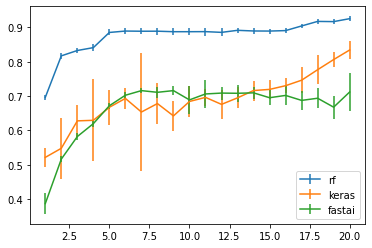

In [13]:
show_graph(figure=fig, feature_count=len(features), metrics_dict=multi_performance_metrics)

## Binary Classification


In [14]:
# Convert the dataset to binary class problem
print('Before conversion:')
print(y.value_counts())

y = y.map(lambda label : label if label == 'benign' else 'malicious')

print('After conversion:')
print(y.value_counts())

Before conversion:
spam          5342
malware       4440
phishing      4014
benign        2709
Defacement    2477
Name: URL_Type_obf_Type, dtype: int64
After conversion:
malicious    16273
benign        2709
Name: URL_Type_obf_Type, dtype: int64


In [15]:
# Since we are now in the binary classification problem, we need to assign the feature set from best to worst
best_features_binclass = ['fileNameLen', 'domain_token_count', 'tld', 'SymbolCount_Domain', 'Entropy_Afterpath', 'delimeter_path', 'argPathRatio', 'Entropy_Filename', 'Entropy_DirectoryName', 'Filename_LetterCount', 'NumberRate_AfterPath', 'NumberRate_Extension', 'Entropy_Extension', 'ArgUrlRatio', 'NumberRate_FileName', 'dld_getArg', 'CharacterContinuityRate', 'NumberRate_DirectoryName', 'dld_filename', 'Extension_DigitCount', 'NumberRate_Domain', 'domainUrlRatio', 'dld_path', 'ldl_getArg', 'SymbolCount_URL', 'Query_DigitCount', 'dld_url', 'ldl_url', 'ldl_path', 'SymbolCount_Directoryname', 'ArgLen', 'this.fileExtLen', 'Querylength', 'File_name_DigitCount', 'Query_LetterCount', 'LongestVariableValue', 'Extension_LetterCount', 'domainlength', 'NumberofDotsinURL', 'Entropy_Domain', 'path_token_count', 'Directory_DigitCount', 'ldl_filename', 'URLQueries_variable', 'delimeter_Count', 'argDomanRatio', 'SymbolCount_FileName', 'host_DigitCount', 'SymbolCount_Extension', 'pathurlRatio', 'host_letter_count', 'URL_DigitCount', 'delimeter_Domain', 'longdomaintokenlen', 'URL_Letter_Count', 'urlLen', 'LongestPathTokenLength', 'URL_sensitiveWord', 'SymbolCount_Afterpath', 'Domain_LongestWordLength', 'pathLength', 'subDirLen', 'executable', 'spcharUrl', 'Arguments_LongestWordLength', 'avgpathtokenlen', 'charcompace', 'ldl_domain', 'Entropy_URL', 'isPortEighty', 'Directory_LetterCount', 'pathDomainRatio', 'dld_domain', 'NumberRate_URL', 'sub-Directory_LongestWordLength', 'Path_LongestWordLength', 'charcompvowels', 'avgdomaintokenlen']

In [16]:
fig = plt.figure()
bin_performance_metrics = {}
for i in range(1, 21):
    features = best_features_binclass[:i]
    bin_performance_metrics[i] = train_and_eval_on(X=X, y=y, feature_set=features)

    #print(performance_metrics)

    #show_graph(figure=fig, feature_count=len(features), metrics_dict=bin_performance_metrics)

Training with 1 features


epoch,train_loss,valid_loss,accuracy,time
0,1.378873,1.360920,0.481306,00:02
1,1.385667,1.367872,0.477093,00:02
2,1.378957,1.350552,0.497630,00:02
3,1.365924,1.347971,0.485519,00:02
4,1.373174,1.349856,0.484992,00:02
5,1.367183,1.344275,0.471301,00:02
6,1.358820,1.351751,0.482359,00:02
7,1.352207,1.358293,0.482359,00:02
8,1.337595,1.345788,0.486572,00:02
9,1.336121,1.354179,0.486572,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.372616,1.368888,0.482886,00:02
1,1.381901,1.323000,0.502896,00:02
2,1.387698,1.348014,0.481306,00:02
3,1.376030,1.339515,0.477093,00:02
4,1.360615,1.329825,0.477620,00:02
5,1.371407,1.327668,0.485519,00:02
6,1.367542,1.341474,0.475513,00:02
7,1.364625,1.322611,0.504476,00:02
8,1.350897,1.327849,0.504476,00:02
9,1.357984,1.324594,0.488152,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.374866,1.355866,0.495785,00:02
1,1.381318,1.347664,0.512645,00:02
2,1.377100,1.348966,0.481033,00:02
3,1.373025,1.356992,0.474183,00:02
4,1.360385,1.344961,0.486828,00:02
5,1.364172,1.357244,0.471549,00:02
6,1.359510,1.349675,0.486828,00:02
7,1.349237,1.338410,0.489989,00:02
8,1.336059,1.336536,0.496839,00:02
9,1.338433,1.337305,0.496312,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.370067,1.372931,0.455216,00:02
1,1.372877,1.379056,0.452582,00:02
2,1.377800,1.370156,0.462592,00:02
3,1.365155,1.371196,0.461012,00:02
4,1.360281,1.369459,0.464173,00:02
5,1.360587,1.363816,0.458904,00:02
6,1.372751,1.362114,0.465227,00:02
7,1.341954,1.365854,0.457850,00:02
8,1.352767,1.357485,0.461538,00:02
9,1.361547,1.365990,0.457850,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.356455,1.414752,0.461012,00:02
1,1.379566,1.375311,0.462592,00:02
2,1.368537,1.392614,0.465227,00:02
3,1.369524,1.392365,0.466807,00:02
4,1.366596,1.395159,0.480506,00:02
5,1.367401,1.394492,0.469968,00:02
6,1.363336,1.383542,0.460485,00:02
7,1.335196,1.374363,0.468915,00:02
8,1.348419,1.374008,0.465753,00:02
9,1.343753,1.404245,0.467861,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.369973,1.362634,0.482613,00:02
1,1.368740,1.376361,0.479979,00:02
2,1.373429,1.360543,0.484194,00:02
3,1.362264,1.356967,0.475237,00:02
4,1.373304,1.346290,0.477871,00:02
5,1.354481,1.360211,0.462592,00:02
6,1.361174,1.357940,0.475764,00:02
7,1.357262,1.349109,0.484721,00:02
8,1.361356,1.360984,0.486828,00:02
9,1.350860,1.356227,0.478398,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.386306,1.352086,0.486828,00:02
1,1.378232,1.382937,0.476291,00:02
2,1.377816,1.349249,0.487355,00:02
3,1.373035,1.367128,0.486301,00:02
4,1.361654,1.351959,0.495258,00:02
5,1.367324,1.348558,0.494731,00:02
6,1.365344,1.346082,0.493678,00:02
7,1.346872,1.334781,0.491570,00:02
8,1.348653,1.338824,0.495785,00:02
9,1.347603,1.338580,0.495785,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.375588,1.372024,0.477345,00:02
1,1.373658,1.344236,0.477345,00:02
2,1.374444,1.390163,0.481560,00:02
3,1.371408,1.363255,0.477345,00:02
4,1.357796,1.368558,0.480506,00:02
5,1.367691,1.370576,0.462065,00:02
6,1.371212,1.365798,0.469442,00:02
7,1.358242,1.368654,0.476818,00:02
8,1.351364,1.352942,0.475764,00:02
9,1.343949,1.355179,0.476291,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.376960,1.361771,0.491570,00:01
1,1.365702,1.385710,0.485774,00:02
2,1.371757,1.348134,0.491043,00:02
3,1.370347,1.371318,0.477345,00:01
4,1.371364,1.345854,0.491570,00:02
5,1.362965,1.364277,0.476291,00:01
6,1.367415,1.363045,0.492624,00:02
7,1.355939,1.361604,0.484721,00:02
8,1.341422,1.342062,0.485774,00:02
9,1.345176,1.348909,0.484721,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.370933,1.379026,0.480506,00:02
1,1.373224,1.354976,0.499473,00:02
2,1.382057,1.346288,0.479452,00:02
3,1.362709,1.337281,0.494204,00:02
4,1.369156,1.348866,0.494731,00:02
5,1.355750,1.344755,0.494204,00:02
6,1.363795,1.360037,0.491043,00:02
7,1.364420,1.341157,0.492624,00:02
8,1.354326,1.351222,0.492624,00:02
9,1.344330,1.331005,0.492624,00:02


Training with 2 features


epoch,train_loss,valid_loss,accuracy,time
0,1.134048,1.084101,0.602949,00:02
1,1.101777,1.058826,0.591364,00:02
2,1.101114,1.078960,0.590311,00:02
3,1.092403,1.054735,0.602949,00:02
4,1.091824,1.070240,0.607162,00:02
5,1.097945,1.045667,0.581885,00:02
6,1.083304,1.047153,0.608741,00:02
7,1.076477,1.028784,0.617167,00:02
8,1.076839,1.043757,0.618220,00:02
9,1.057148,1.035543,0.614534,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.150048,1.097979,0.580832,00:02
1,1.118771,1.069981,0.572933,00:02
2,1.114330,1.076186,0.588204,00:02
3,1.100650,1.089385,0.569247,00:02
4,1.099418,1.099022,0.521327,00:02
5,1.085188,1.094862,0.593997,00:02
6,1.078536,1.091677,0.590837,00:02
7,1.058288,1.071919,0.595577,00:02
8,1.059269,1.069725,0.592417,00:02
9,1.049426,1.050323,0.598210,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.136211,1.090730,0.584299,00:02
1,1.110284,1.115521,0.569547,00:02
2,1.121682,1.116960,0.472076,00:02
3,1.091106,1.055459,0.584299,00:02
4,1.091883,1.070129,0.598525,00:02
5,1.079512,1.044091,0.600105,00:02
6,1.062303,1.045813,0.600632,00:02
7,1.059989,1.059576,0.604320,00:02
8,1.075931,1.119257,0.469968,00:02
9,1.040504,1.036623,0.601686,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.153910,1.118852,0.567966,00:02
1,1.104521,1.153280,0.582719,00:02
2,1.118327,1.118739,0.590095,00:02
3,1.103761,1.087562,0.589041,00:02
4,1.084990,1.077464,0.579031,00:02
5,1.074632,1.054672,0.592729,00:02
6,1.084282,1.069642,0.596417,00:02
7,1.073794,1.052016,0.591149,00:02
8,1.078872,1.081914,0.593783,00:02
9,1.068465,1.051338,0.592729,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.130081,1.161522,0.552160,00:02
1,1.103198,1.111293,0.575342,00:02
2,1.117103,1.110103,0.566913,00:02
3,1.111020,1.114866,0.579031,00:02
4,1.087752,1.111214,0.559009,00:02
5,1.080488,1.113173,0.582192,00:02
6,1.065378,1.073946,0.583246,00:02
7,1.076504,1.083538,0.586407,00:02
8,1.064061,1.081066,0.583772,00:02
9,1.068637,1.090854,0.581665,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.147989,1.063870,0.599052,00:02
1,1.128046,1.064295,0.606955,00:02
2,1.109323,1.046242,0.600632,00:02
3,1.102975,1.046872,0.596944,00:02
4,1.088720,1.034110,0.592202,00:02
5,1.093173,1.034674,0.608008,00:02
6,1.067722,1.035679,0.602740,00:02
7,1.071441,1.023494,0.609589,00:02
8,1.066804,1.019949,0.606955,00:02
9,1.058484,1.036008,0.604320,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.131978,1.073178,0.612750,00:02
1,1.126894,1.060404,0.610116,00:02
2,1.118373,1.063939,0.591149,00:02
3,1.082205,1.070591,0.597998,00:02
4,1.088455,1.055329,0.618546,00:02
5,1.081960,1.069466,0.604320,00:02
6,1.071528,1.075677,0.606955,00:02
7,1.074993,1.042035,0.616438,00:02
8,1.077378,1.051087,0.606428,00:02
9,1.062146,1.087884,0.581665,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.145445,1.122594,0.580084,00:02
1,1.109685,1.103603,0.573762,00:02
2,1.113067,1.105780,0.579557,00:02
3,1.108413,1.088937,0.584299,00:02
4,1.089630,1.076184,0.575342,00:02
5,1.070496,1.091057,0.586407,00:02
6,1.078045,1.079024,0.591149,00:02
7,1.052231,1.066979,0.585353,00:02
8,1.061464,1.077809,0.585353,00:02
9,1.043924,1.062704,0.589041,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.127025,1.123465,0.577450,00:02
1,1.110492,1.077963,0.595890,00:02
2,1.118455,1.083579,0.597998,00:02
3,1.102154,1.108316,0.590622,00:02
4,1.085732,1.113384,0.587460,00:02
5,1.066611,1.081398,0.600105,00:02
6,1.069331,1.062467,0.605901,00:02
7,1.076762,1.060548,0.601159,00:02
8,1.059201,1.067938,0.604320,00:02
9,1.056979,1.051939,0.603267,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.148159,1.123827,0.557429,00:02
1,1.118940,1.069758,0.588514,00:02
2,1.092869,1.124227,0.570074,00:02
3,1.087359,1.070483,0.585880,00:02
4,1.077478,1.055279,0.584826,00:02
5,1.074985,1.059927,0.587460,00:02
6,1.070943,1.063346,0.595890,00:01
7,1.058494,1.076871,0.594837,00:02
8,1.052009,1.055614,0.596944,00:02
9,1.058313,1.054752,0.592202,00:02


Training with 3 features


epoch,train_loss,valid_loss,accuracy,time
0,1.142253,1.084687,0.589257,00:02
1,1.135758,1.081762,0.557662,00:01
2,1.108580,1.087918,0.582938,00:01
3,1.105903,1.062891,0.595577,00:02
4,1.088827,1.052951,0.608741,00:01
5,1.094680,1.061176,0.607688,00:02
6,1.058565,1.023767,0.614007,00:02
7,1.060653,1.036156,0.615061,00:02
8,1.053215,1.017567,0.611374,00:02
9,1.068578,1.033043,0.613481,00:01


epoch,train_loss,valid_loss,accuracy,time
0,1.133717,1.087178,0.582938,00:01
1,1.113466,1.078319,0.577146,00:02
2,1.106609,1.059670,0.597683,00:01
3,1.102354,1.057500,0.589257,00:02
4,1.113054,1.037054,0.596630,00:02
5,1.097629,1.045609,0.595050,00:01
6,1.068696,1.088166,0.588731,00:01
7,1.059752,1.063151,0.594523,00:02
8,1.042370,1.074608,0.593997,00:02
9,1.069406,1.050391,0.597683,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.140262,1.077340,0.594837,00:02
1,1.111845,1.091710,0.609062,00:02
2,1.123974,1.054100,0.590622,00:01
3,1.103524,1.060480,0.597471,00:02
4,1.087878,1.073458,0.590095,00:01
5,1.079571,1.069552,0.576396,00:01
6,1.104046,1.070674,0.606955,00:02
7,1.072379,1.079356,0.610116,00:02
8,1.067748,1.034297,0.597471,00:02
9,1.064718,1.073963,0.608008,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.127505,1.115294,0.569547,00:01
1,1.103906,1.074827,0.572181,00:01
2,1.099224,1.105350,0.591675,00:02
3,1.094823,1.089797,0.585880,00:01
4,1.084324,1.060661,0.590622,00:01
5,1.089052,1.074179,0.581665,00:01
6,1.083216,1.058915,0.591675,00:01
7,1.040597,1.068722,0.596944,00:02
8,1.054811,1.073151,0.569020,00:01
9,1.045147,1.046329,0.594837,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.151105,1.121268,0.579031,00:02
1,1.116999,1.116874,0.582719,00:02
2,1.104804,1.112513,0.559536,00:02
3,1.101976,1.103893,0.570601,00:01
4,1.090691,1.095382,0.577450,00:02
5,1.076207,1.078591,0.586934,00:02
6,1.070258,1.066625,0.589041,00:02
7,1.069790,1.071853,0.579557,00:02
8,1.074588,1.089887,0.565859,00:02
9,1.039150,1.056904,0.585880,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.151254,1.131774,0.600632,00:02
1,1.127852,1.092891,0.592729,00:01
2,1.115227,1.085544,0.601686,00:02
3,1.105350,1.068751,0.587987,00:02
4,1.091962,1.071593,0.587987,00:02
5,1.088220,1.044294,0.601686,00:02
6,1.077086,1.053458,0.600105,00:02
7,1.064917,1.024160,0.608008,00:02
8,1.069545,1.027949,0.607482,00:02
9,1.049930,1.022159,0.604320,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.142174,1.092234,0.597998,00:02
1,1.120041,1.096200,0.577450,00:02
2,1.110334,1.094786,0.579031,00:02
3,1.095067,1.074295,0.603793,00:02
4,1.101590,1.090247,0.608535,00:02
5,1.095038,1.084487,0.600105,00:02
6,1.064777,1.072801,0.612750,00:02
7,1.064897,1.095314,0.602740,00:02
8,1.071732,1.095950,0.618019,00:02
9,1.062904,1.103296,0.604847,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.141525,1.105487,0.582192,00:02
1,1.102270,1.097251,0.577977,00:02
2,1.098274,1.092439,0.574289,00:02
3,1.099655,1.089118,0.581138,00:02
4,1.082752,1.090005,0.543730,00:02
5,1.087834,1.072708,0.589568,00:02
6,1.085077,1.085505,0.587987,00:02
7,1.063364,1.077680,0.593256,00:02
8,1.063255,1.058439,0.586934,00:02
9,1.049035,1.053237,0.588514,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.140876,1.105327,0.589568,00:02
1,1.123884,1.109844,0.598525,00:02
2,1.088693,1.084940,0.587460,00:02
3,1.098812,1.104735,0.567966,00:02
4,1.080784,1.069267,0.596944,00:02
5,1.083464,1.066567,0.601686,00:02
6,1.065598,1.061615,0.604320,00:02
7,1.066001,1.056933,0.606428,00:02
8,1.054698,1.075257,0.605374,00:02
9,1.052560,1.043744,0.605374,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.159135,1.108756,0.572708,00:02
1,1.104209,1.084154,0.554795,00:02
2,1.115382,1.112307,0.568493,00:01
3,1.096797,1.080318,0.558483,00:02
4,1.087444,1.094122,0.579031,00:02
5,1.092570,1.062942,0.600632,00:02
6,1.071983,1.055345,0.594837,00:02
7,1.075290,1.055498,0.592729,00:02
8,1.062424,1.043815,0.589568,00:02
9,1.054128,1.063631,0.594837,00:02


Training with 4 features


epoch,train_loss,valid_loss,accuracy,time
0,1.132382,1.091276,0.598210,00:02
1,1.110059,1.104846,0.583465,00:01
2,1.097979,1.084649,0.597156,00:02
3,1.109531,1.070100,0.611374,00:02
4,1.094394,1.070107,0.588204,00:02
5,1.093233,1.037583,0.604002,00:02
6,1.066892,1.041666,0.580305,00:01
7,1.074178,1.033287,0.612954,00:02
8,1.072605,1.023409,0.615587,00:02
9,1.053004,1.024994,0.611901,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.167103,1.106093,0.576619,00:02
1,1.127782,1.088905,0.587151,00:02
2,1.110242,1.094483,0.526593,00:01
3,1.107583,1.058867,0.593470,00:02
4,1.098714,1.053727,0.595050,00:02
5,1.084425,1.055423,0.589784,00:02
6,1.089798,1.031946,0.600843,00:01
7,1.056637,1.044295,0.590837,00:02
8,1.074694,1.024448,0.595577,00:02
9,1.079306,1.052178,0.600316,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.138165,1.106522,0.590622,00:02
1,1.138864,1.068899,0.584299,00:02
2,1.112938,1.141777,0.570074,00:02
3,1.104926,1.086357,0.593256,00:02
4,1.093664,1.049626,0.599052,00:02
5,1.088067,1.060902,0.593783,00:02
6,1.076935,1.051946,0.609062,00:02
7,1.060907,1.049942,0.601686,00:02
8,1.065099,1.047232,0.604320,00:02
9,1.062520,1.051680,0.599578,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.129637,1.134058,0.556375,00:01
1,1.127394,1.119584,0.532139,00:01
2,1.112109,1.112908,0.575869,00:02
3,1.107400,1.092440,0.583246,00:02
4,1.097216,1.110007,0.583246,00:01
5,1.071262,1.068995,0.590095,00:01
6,1.074954,1.080635,0.591149,00:01
7,1.064722,1.066004,0.587987,00:02
8,1.066603,1.063435,0.592202,00:02
9,1.070609,1.068722,0.581138,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.136837,1.150275,0.579031,00:02
1,1.105187,1.110063,0.571654,00:02
2,1.102876,1.096902,0.576923,00:02
3,1.118219,1.107888,0.566386,00:02
4,1.088459,1.081318,0.586934,00:01
5,1.090920,1.078481,0.581665,00:02
6,1.076524,1.127347,0.577450,00:02
7,1.074739,1.091221,0.585353,00:02
8,1.073167,1.116220,0.566913,00:02
9,1.051748,1.098520,0.584299,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.133558,1.056847,0.594837,00:02
1,1.122243,1.079786,0.568493,00:02
2,1.100533,1.052170,0.593256,00:02
3,1.072266,1.096728,0.549526,00:02
4,1.101909,1.050627,0.610116,00:02
5,1.083172,1.071395,0.599578,00:02
6,1.067279,1.032978,0.602740,00:02
7,1.077299,1.035884,0.603793,00:02
8,1.072682,1.024232,0.604320,00:02
9,1.064587,1.034335,0.604320,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.159961,1.097215,0.596944,00:02
1,1.130624,1.095390,0.594310,00:02
2,1.119831,1.089948,0.595364,00:02
3,1.106369,1.067436,0.611697,00:02
4,1.084488,1.045189,0.608008,00:02
5,1.095741,1.057961,0.572181,00:02
6,1.096678,1.042809,0.612750,00:02
7,1.065729,1.023152,0.608008,00:02
8,1.067528,1.026543,0.614858,00:02
9,1.073594,1.044342,0.601159,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.132817,1.118938,0.563751,00:02
1,1.117988,1.110886,0.560590,00:02
2,1.097481,1.100688,0.584826,00:02
3,1.097254,1.076125,0.580084,00:02
4,1.093836,1.100937,0.576396,00:02
5,1.076269,1.070096,0.580084,00:01
6,1.064185,1.071993,0.585353,00:02
7,1.074957,1.071607,0.588514,00:02
8,1.056993,1.067712,0.589041,00:02
9,1.064329,1.054343,0.591675,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.142900,1.103559,0.586934,00:02
1,1.123125,1.089884,0.594310,00:02
2,1.091373,1.100690,0.592729,00:02
3,1.114529,1.119482,0.546891,00:02
4,1.091402,1.086938,0.597471,00:02
5,1.080011,1.099027,0.591675,00:02
6,1.063334,1.059565,0.593783,00:02
7,1.062371,1.053762,0.602740,00:02
8,1.067425,1.080263,0.606955,00:02
9,1.051628,1.058146,0.602740,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.149301,1.119704,0.571654,00:02
1,1.107144,1.084193,0.587987,00:02
2,1.089437,1.091699,0.578504,00:02
3,1.092006,1.070804,0.591149,00:01
4,1.078220,1.096665,0.591149,00:02
5,1.082222,1.065211,0.590622,00:01
6,1.063514,1.053913,0.595364,00:02
7,1.066639,1.054370,0.590095,00:02
8,1.048605,1.043414,0.596944,00:02
9,1.064728,1.069614,0.593256,00:02


Training with 5 features


epoch,train_loss,valid_loss,accuracy,time
0,1.099348,1.046617,0.602949,00:02
1,1.040974,1.009402,0.611374,00:02
2,1.054227,1.029809,0.611901,00:01
3,1.048872,1.010370,0.620853,00:02
4,1.035589,1.002193,0.591890,00:02
5,1.016228,0.966667,0.625592,00:02
6,1.014392,0.964978,0.631385,00:02
7,0.997639,0.968157,0.630858,00:02
8,0.995728,0.943421,0.629279,00:01
9,0.972583,0.950169,0.632965,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.111615,1.040183,0.590837,00:02
1,1.052572,1.016293,0.586098,00:01
2,1.033416,1.000497,0.606108,00:02
3,1.037182,0.969821,0.605055,00:02
4,1.013085,0.972338,0.606108,00:02
5,1.004372,0.975749,0.616640,00:02
6,0.987174,0.949084,0.634544,00:02
7,0.987024,0.955213,0.622433,00:02
8,0.965052,0.946180,0.644550,00:01
9,0.957053,0.927231,0.636651,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.072198,1.032783,0.591149,00:02
1,1.050239,1.012724,0.587460,00:02
2,1.064645,0.987943,0.608535,00:02
3,1.029571,1.003147,0.605374,00:01
4,1.020554,0.958570,0.612223,00:01
5,1.011741,0.947707,0.627503,00:02
6,0.989309,0.937771,0.613804,00:02
7,0.986027,0.954964,0.633298,00:01
8,0.964356,0.927476,0.631718,00:01
9,0.969293,0.926353,0.621707,00:01


epoch,train_loss,valid_loss,accuracy,time
0,1.102582,1.038131,0.593783,00:01
1,1.036887,1.015567,0.567966,00:01
2,1.061671,1.018489,0.592202,00:02
3,1.041228,1.013769,0.606428,00:02
4,1.012740,0.987838,0.611697,00:02
5,1.008011,0.993052,0.592202,00:01
6,0.979132,0.961859,0.624341,00:01
7,0.963170,0.942816,0.614331,00:01
8,0.972941,0.941725,0.625922,00:01
9,0.948093,0.948707,0.618019,00:01


epoch,train_loss,valid_loss,accuracy,time
0,1.076236,1.083758,0.585880,00:02
1,1.063305,1.074954,0.531085,00:01
2,1.044825,1.027778,0.609062,00:02
3,1.040924,1.015535,0.592202,00:02
4,1.027733,0.990050,0.604320,00:01
5,0.999439,0.981670,0.610116,00:02
6,0.973621,0.969064,0.629610,00:02
7,0.965769,0.979707,0.622761,00:02
8,0.960968,0.967636,0.632244,00:02
9,0.958788,0.955840,0.633298,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.103457,1.021794,0.606955,00:02
1,1.058392,1.004801,0.613804,00:02
2,1.048207,1.012096,0.586934,00:01
3,1.055212,0.995291,0.606428,00:02
4,1.016026,0.972371,0.616965,00:02
5,1.015503,1.003674,0.618546,00:02
6,0.994996,1.000286,0.630137,00:02
7,0.974687,1.045793,0.640674,00:02
8,0.967648,1.030865,0.640674,00:02
9,0.961313,1.045907,0.642782,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.096162,1.031131,0.618546,00:02
1,1.063710,1.035849,0.598525,00:02
2,1.067309,1.008728,0.596417,00:02
3,1.032604,0.983074,0.626976,00:02
4,1.023919,0.998104,0.623288,00:02
5,0.991786,0.963040,0.639621,00:02
6,1.001422,0.957574,0.633825,00:02
7,0.987205,0.936899,0.643836,00:02
8,0.958476,0.925665,0.643836,00:02
9,0.973241,0.926804,0.654900,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.098415,1.090561,0.592202,00:02
1,1.057646,1.055732,0.570074,00:02
2,1.058538,1.032463,0.600105,00:02
3,1.036458,1.041533,0.563751,00:02
4,1.002889,1.036384,0.585880,00:02
5,1.006429,0.996445,0.602740,00:02
6,0.984121,0.992398,0.625395,00:02
7,1.000803,0.984435,0.616965,00:02
8,0.979358,0.971753,0.603793,00:02
9,0.974139,0.970935,0.599578,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.095385,1.054744,0.599052,00:02
1,1.049296,1.001487,0.620126,00:02
2,1.049478,1.004631,0.623815,00:02
3,1.037211,1.004436,0.581665,00:02
4,1.022345,0.988106,0.613804,00:02
5,0.996680,0.978172,0.618019,00:02
6,0.987342,0.959731,0.644889,00:02
7,0.985934,0.959377,0.626976,00:02
8,0.983430,0.937644,0.650685,00:02
9,0.963052,0.937403,0.648051,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.086501,1.077290,0.595364,00:02
1,1.051811,1.035371,0.591149,00:01
2,1.037948,1.013560,0.603267,00:01
3,1.040496,1.038846,0.592202,00:02
4,1.007805,1.019336,0.602740,00:01
5,1.013118,1.005298,0.598525,00:02
6,1.005195,0.991415,0.607482,00:01
7,0.999759,0.987727,0.632771,00:02
8,0.971064,0.967709,0.626976,00:01
9,0.952023,0.961529,0.633298,00:02


Training with 6 features


epoch,train_loss,valid_loss,accuracy,time
0,1.006917,0.921678,0.640864,00:02
1,0.960537,0.924509,0.632438,00:02
2,0.926654,0.897781,0.640337,00:01
3,0.904548,0.837449,0.687204,00:01
4,0.883024,0.826945,0.680358,00:01
5,0.864324,0.802664,0.688784,00:01
6,0.837815,0.797361,0.697736,00:01
7,0.824202,0.788068,0.675092,00:01
8,0.794661,0.779924,0.697209,00:01
9,0.788890,0.766259,0.700895,00:01


epoch,train_loss,valid_loss,accuracy,time
0,1.017300,0.962841,0.612428,00:01
1,0.945008,0.922215,0.628752,00:01
2,0.921769,0.880098,0.650342,00:01
3,0.912133,0.864724,0.666140,00:01
4,0.878778,0.876279,0.665613,00:01
5,0.872848,0.830979,0.688257,00:01
6,0.826049,0.788391,0.694049,00:02
7,0.820210,0.781107,0.707214,00:01
8,0.809759,0.766854,0.705635,00:02
9,0.788745,0.770763,0.719326,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.008053,0.923637,0.639621,00:01
1,0.955719,0.898447,0.644889,00:01
2,0.937666,0.860868,0.667018,00:01
3,0.899073,0.847729,0.670179,00:01
4,0.880164,0.823594,0.665964,00:02
5,0.863905,0.815603,0.671760,00:01
6,0.857620,0.805094,0.680190,00:02
7,0.839060,0.771388,0.708114,00:01
8,0.805360,0.752803,0.719178,00:02
9,0.805978,0.757356,0.710748,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.990278,0.972926,0.621180,00:02
1,0.946235,0.930915,0.621180,00:01
2,0.941418,0.905668,0.632771,00:01
3,0.915769,0.868705,0.661749,00:01
4,0.883491,0.828613,0.670706,00:01
5,0.869734,0.810896,0.695996,00:01
6,0.838964,0.809834,0.684405,00:02
7,0.800971,0.782180,0.702845,00:02
8,0.815839,0.795162,0.698103,00:01
9,0.806537,0.783696,0.700738,00:01


epoch,train_loss,valid_loss,accuracy,time
0,1.006413,0.988677,0.611697,00:02
1,0.959004,0.963850,0.625922,00:02
2,0.929675,0.939788,0.617492,00:02
3,0.918816,0.895315,0.637513,00:02
4,0.889158,0.878128,0.652266,00:02
5,0.872843,0.867545,0.659642,00:01
6,0.853066,0.837880,0.654900,00:01
7,0.832593,0.824211,0.687039,00:02
8,0.812103,0.824068,0.679136,00:02
9,0.816228,0.808557,0.686512,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.019992,0.934160,0.628030,00:02
1,0.973668,0.896558,0.665437,00:01
2,0.927959,0.877514,0.668599,00:02
3,0.906644,0.853656,0.671233,00:02
4,0.875017,0.805319,0.681243,00:02
5,0.869293,0.815885,0.689146,00:02
6,0.841369,0.785999,0.720232,00:02
7,0.825472,0.771639,0.703372,00:02
8,0.831081,0.755388,0.719178,00:02
9,0.810869,0.754422,0.726554,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.014136,0.933171,0.657007,00:02
1,0.952160,0.914777,0.661222,00:02
2,0.921392,0.885316,0.646997,00:02
3,0.903122,0.866775,0.661222,00:02
4,0.880694,0.865153,0.674921,00:02
5,0.884039,0.822852,0.665964,00:02
6,0.858994,0.806253,0.703899,00:02
7,0.844187,0.794691,0.696523,00:02
8,0.837685,0.783535,0.711275,00:02
9,0.790763,0.786453,0.708114,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.010921,1.007078,0.618019,00:02
1,0.953398,0.933089,0.596944,00:02
2,0.951814,0.907840,0.637513,00:02
3,0.881890,0.890018,0.671760,00:02
4,0.868166,0.876549,0.669125,00:02
5,0.852755,0.850411,0.685985,00:02
6,0.839718,0.841889,0.657534,00:02
7,0.808203,0.822865,0.687566,00:02
8,0.785307,0.796157,0.709168,00:02
9,0.795725,0.800727,0.709168,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.007891,0.941532,0.648051,00:02
1,0.951337,0.888571,0.657007,00:02
2,0.937973,0.870407,0.667545,00:02
3,0.912157,0.853952,0.668072,00:02
4,0.877121,0.811864,0.695469,00:01
5,0.849562,0.806542,0.695996,00:02
6,0.833737,0.777871,0.718124,00:01
7,0.837427,0.759604,0.724447,00:02
8,0.820316,0.755716,0.728135,00:02
9,0.814272,0.745297,0.728135,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.006511,0.985047,0.618019,00:01
1,0.964208,0.952821,0.617492,00:01
2,0.933177,0.925773,0.633825,00:02
3,0.903646,0.883063,0.660169,00:02
4,0.891566,0.858363,0.686512,00:02
5,0.849724,0.839430,0.673340,00:02
6,0.835400,0.819793,0.687566,00:02
7,0.802229,0.806412,0.690727,00:02
8,0.803672,0.794041,0.701791,00:01
9,0.797655,0.793364,0.695996,00:01


Training with 7 features


epoch,train_loss,valid_loss,accuracy,time
0,0.943618,0.839070,0.696156,00:01
1,0.874268,0.786946,0.695103,00:02
2,0.828897,0.791744,0.701948,00:01
3,0.810792,0.746509,0.728278,00:01
4,0.769223,0.706533,0.728805,00:01
5,0.749898,0.686123,0.740916,00:01
6,0.727789,0.658985,0.751975,00:02
7,0.722670,0.644774,0.758820,00:01
8,0.687414,0.634569,0.762507,00:01
9,0.687645,0.629730,0.759874,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.948800,0.890722,0.682991,00:02
1,0.895195,0.850834,0.657188,00:02
2,0.843729,0.792530,0.697736,00:02
3,0.806440,0.755260,0.720379,00:01
4,0.758401,0.740188,0.727751,00:02
5,0.751317,0.711079,0.727225,00:01
6,0.735940,0.690706,0.745129,00:02
7,0.701522,0.675021,0.741969,00:02
8,0.674826,0.645131,0.765140,00:02
9,0.690493,0.653551,0.755134,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.947080,0.835920,0.703372,00:01
1,0.859862,0.824973,0.667545,00:02
2,0.835967,0.752233,0.733930,00:02
3,0.779688,0.712395,0.724447,00:01
4,0.776343,0.680032,0.748683,00:02
5,0.750734,0.662730,0.751844,00:01
6,0.739355,0.657456,0.750790,00:01
7,0.696645,0.633050,0.765016,00:01
8,0.685289,0.614286,0.761855,00:01
9,0.674986,0.611323,0.762908,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.927519,0.915253,0.659115,00:01
1,0.859035,0.820886,0.696523,00:01
2,0.841832,0.798172,0.697576,00:01
3,0.796266,0.785898,0.701791,00:01
4,0.762597,0.734468,0.722866,00:02
5,0.761903,0.766400,0.714963,00:02
6,0.737622,0.692577,0.733930,00:01
7,0.706134,0.676121,0.741307,00:02
8,0.682007,0.668194,0.742360,00:02
9,0.688437,0.675281,0.734984,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.918836,0.916521,0.657007,00:01
1,0.856448,0.873227,0.660695,00:01
2,0.838677,0.799199,0.689673,00:01
3,0.792614,0.787516,0.687566,00:02
4,0.760989,0.752291,0.716017,00:02
5,0.758566,0.696489,0.746575,00:01
6,0.720367,0.688392,0.750263,00:02
7,0.706793,0.681314,0.751844,00:02
8,0.702069,0.658209,0.760274,00:01
9,0.678238,0.648630,0.754478,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.959581,0.884622,0.648051,00:02
1,0.852512,0.828459,0.701791,00:02
2,0.827754,0.776055,0.716544,00:02
3,0.805168,0.731998,0.720759,00:02
4,0.785084,0.727920,0.742360,00:02
5,0.765498,0.677559,0.755005,00:02
6,0.740824,0.648027,0.765016,00:02
7,0.709234,0.631930,0.768177,00:02
8,0.701696,0.618220,0.783456,00:02
9,0.689582,0.615530,0.784510,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.944441,0.853014,0.680717,00:02
1,0.887462,0.799239,0.693361,00:02
2,0.842467,0.775294,0.724447,00:01
3,0.822760,0.766628,0.721812,00:01
4,0.758748,0.719883,0.724974,00:02
5,0.756859,0.744717,0.715490,00:02
6,0.742513,0.700846,0.736565,00:02
7,0.714476,0.687734,0.741834,00:02
8,0.704722,0.674852,0.746575,00:02
9,0.686469,0.663635,0.752898,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.921302,0.886835,0.686512,00:02
1,0.880636,0.858150,0.672287,00:02
2,0.818213,0.792418,0.712329,00:01
3,0.810693,0.807850,0.682824,00:02
4,0.775265,0.757426,0.706533,00:02
5,0.744071,0.718455,0.737619,00:01
6,0.736655,0.690557,0.740780,00:02
7,0.687776,0.674544,0.740780,00:02
8,0.670890,0.657718,0.761328,00:02
9,0.655312,0.653757,0.759220,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.972692,0.884652,0.671233,00:02
1,0.863478,0.785328,0.707060,00:02
2,0.822142,0.769021,0.730242,00:02
3,0.788344,0.766232,0.717597,00:02
4,0.787402,0.704772,0.748156,00:02
5,0.760575,0.683389,0.760274,00:01
6,0.725999,0.658284,0.755005,00:02
7,0.706959,0.679703,0.752371,00:02
8,0.695153,0.640720,0.775026,00:02
9,0.696621,0.636067,0.766070,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.931321,0.896438,0.665437,00:02
1,0.855932,0.842977,0.670706,00:02
2,0.841312,0.810026,0.669652,00:02
3,0.801631,0.781037,0.699157,00:02
4,0.782142,0.753916,0.726027,00:01
5,0.726353,0.753890,0.712329,00:02
6,0.720497,0.731754,0.728135,00:02
7,0.703118,0.704874,0.744468,00:02
8,0.673346,0.736566,0.721286,00:02
9,0.692328,0.680514,0.738145,00:02


Training with 8 features


epoch,train_loss,valid_loss,accuracy,time
0,0.943219,0.863958,0.652449,00:01
1,0.856976,0.807572,0.682991,00:01
2,0.808927,0.740949,0.708794,00:02
3,0.770470,0.722363,0.731964,00:01
4,0.736875,0.669831,0.746709,00:02
5,0.707340,0.656208,0.756187,00:02
6,0.673988,0.629508,0.772512,00:02
7,0.653002,0.608435,0.785150,00:02
8,0.648286,0.598620,0.780411,00:02
9,0.629679,0.587959,0.783570,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.940861,0.873319,0.683518,00:02
1,0.834124,0.779946,0.694576,00:02
2,0.811563,0.750364,0.719326,00:02
3,0.769154,0.690286,0.734071,00:02
4,0.719309,0.664387,0.756714,00:02
5,0.683423,0.630417,0.766193,00:02
6,0.669116,0.610850,0.781464,00:02
7,0.665243,0.589785,0.792522,00:02
8,0.620676,0.582829,0.785677,00:02
9,0.631248,0.587836,0.786203,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.942569,0.881227,0.673867,00:01
1,0.867111,0.760572,0.710221,00:02
2,0.825362,0.768358,0.693888,00:01
3,0.771351,0.683061,0.753952,00:02
4,0.745531,0.653200,0.747629,00:02
5,0.720190,0.622655,0.760801,00:01
6,0.677240,0.598365,0.772919,00:01
7,0.664886,0.579942,0.775553,00:01
8,0.646875,0.563984,0.775553,00:01
9,0.632001,0.563174,0.771865,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.944846,0.870725,0.670179,00:02
1,0.835551,0.804594,0.710221,00:02
2,0.815992,0.777518,0.711802,00:01
3,0.768653,0.719791,0.721286,00:01
4,0.720222,0.690793,0.736565,00:02
5,0.711486,0.652106,0.748156,00:02
6,0.686623,0.631233,0.765543,00:01
7,0.658791,0.611197,0.768704,00:01
8,0.628253,0.593780,0.774499,00:01
9,0.615899,0.594125,0.769231,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.930584,0.880860,0.668599,00:02
1,0.853766,0.788322,0.695469,00:02
2,0.786975,0.763098,0.717071,00:02
3,0.793928,0.728506,0.728662,00:01
4,0.755567,0.700845,0.714963,00:01
5,0.714680,0.661932,0.752898,00:02
6,0.671539,0.617454,0.781349,00:01
7,0.647143,0.592935,0.769758,00:02
8,0.631764,0.581846,0.780822,00:02
9,0.626905,0.591510,0.777661,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.941437,0.866420,0.681243,00:01
1,0.854891,0.761312,0.729715,00:02
2,0.797383,0.719029,0.730242,00:02
3,0.766139,0.702074,0.734457,00:02
4,0.746106,0.660646,0.761855,00:01
5,0.710866,0.637379,0.775553,00:01
6,0.677932,0.611810,0.780295,00:02
7,0.647342,0.597085,0.782403,00:01
8,0.632074,0.580693,0.788725,00:02
9,0.622511,0.579805,0.790306,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.943763,0.880195,0.662803,00:02
1,0.824482,0.811122,0.677028,00:02
2,0.784153,0.719129,0.726027,00:02
3,0.761230,0.706849,0.743414,00:02
4,0.730231,0.671645,0.747102,00:02
5,0.699689,0.666358,0.749210,00:02
6,0.672850,0.613216,0.769758,00:02
7,0.659588,0.598059,0.786618,00:02
8,0.631005,0.587160,0.782929,00:02
9,0.616414,0.587837,0.786618,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.944321,0.928103,0.617492,00:02
1,0.836842,0.843382,0.671760,00:02
2,0.812624,0.792482,0.704953,00:02
3,0.759357,0.737491,0.723393,00:02
4,0.748154,0.713661,0.739726,00:02
5,0.686130,0.675185,0.745522,00:02
6,0.664291,0.645751,0.759220,00:02
7,0.647589,0.615364,0.776080,00:02
8,0.634735,0.597356,0.779768,00:02
9,0.618128,0.603661,0.775026,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.965929,0.861737,0.669652,00:01
1,0.845452,0.784580,0.692835,00:02
2,0.806501,0.738267,0.725501,00:02
3,0.760192,0.677457,0.749210,00:02
4,0.726738,0.664106,0.759747,00:02
5,0.688279,0.611214,0.775553,00:02
6,0.673799,0.595469,0.782929,00:02
7,0.643852,0.582484,0.785564,00:02
8,0.632470,0.570463,0.797682,00:02
9,0.641399,0.562257,0.801370,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.916937,0.915863,0.643836,00:02
1,0.835432,0.815392,0.689146,00:02
2,0.805920,0.758281,0.695469,00:02
3,0.750917,0.718036,0.738672,00:02
4,0.728976,0.705072,0.732877,00:02
5,0.694444,0.675786,0.755532,00:02
6,0.666652,0.651805,0.758166,00:02
7,0.632531,0.651979,0.753425,00:02
8,0.618213,0.630900,0.762908,00:02
9,0.625550,0.626859,0.764489,00:02


Training with 9 features


epoch,train_loss,valid_loss,accuracy,time
0,0.885471,0.809588,0.717746,00:02
1,0.808853,0.730605,0.735124,00:02
2,0.741669,0.684657,0.746182,00:01
3,0.694044,0.649818,0.757767,00:02
4,0.661666,0.597632,0.792522,00:02
5,0.621630,0.568745,0.802001,00:02
6,0.586554,0.518277,0.805161,00:02
7,0.549150,0.533331,0.798841,00:02
8,0.544419,0.504804,0.822538,00:02
9,0.529136,0.502852,0.816746,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.921673,0.839389,0.686677,00:02
1,0.808559,0.742103,0.719853,00:02
2,0.718939,0.663902,0.759347,00:02
3,0.703340,0.649680,0.754608,00:01
4,0.658188,0.588182,0.787256,00:01
5,0.618044,0.583224,0.792522,00:02
6,0.577502,0.522746,0.811480,00:02
7,0.564137,0.559586,0.790416,00:02
8,0.531379,0.493697,0.815166,00:02
9,0.532121,0.492525,0.814639,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.897854,0.808454,0.697576,00:02
1,0.790510,0.698578,0.727608,00:01
2,0.735672,0.689711,0.761855,00:01
3,0.706783,0.631609,0.743941,00:02
4,0.657410,0.571739,0.786618,00:02
5,0.630136,0.546495,0.799262,00:02
6,0.570819,0.516296,0.800316,00:01
7,0.570047,0.488926,0.816122,00:02
8,0.546792,0.471652,0.818757,00:02
9,0.524431,0.481274,0.820864,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.909513,0.834970,0.695469,00:02
1,0.799413,0.734138,0.723393,00:02
2,0.744789,0.704022,0.729715,00:02
3,0.706721,0.615859,0.771338,00:02
4,0.661364,0.602843,0.781876,00:01
5,0.615250,0.549127,0.795574,00:02
6,0.578880,0.549131,0.792413,00:02
7,0.565187,0.496669,0.811907,00:02
8,0.528483,0.489267,0.812961,00:02
9,0.522119,0.509044,0.808746,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.942869,0.881159,0.666491,00:02
1,0.815378,0.767587,0.734984,00:01
2,0.730953,0.736086,0.726027,00:02
3,0.686871,0.639021,0.759747,00:01
4,0.632376,0.613398,0.772919,00:01
5,0.609800,0.587134,0.783983,00:02
6,0.583416,0.555968,0.787671,00:02
7,0.529626,0.515765,0.808219,00:02
8,0.530280,0.505114,0.808219,00:02
9,0.504778,0.495319,0.818230,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.893354,0.826312,0.694942,00:02
1,0.785700,0.689283,0.756059,00:01
2,0.747480,0.637529,0.763962,00:02
3,0.702362,0.627532,0.757640,00:01
4,0.641706,0.559766,0.805058,00:02
5,0.602959,0.548372,0.803477,00:01
6,0.585231,0.510528,0.814542,00:01
7,0.575875,0.495532,0.814015,00:02
8,0.532961,0.471257,0.818757,00:02
9,0.521649,0.464462,0.826660,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.918107,0.833111,0.685458,00:02
1,0.811130,0.731161,0.719178,00:02
2,0.739963,0.659599,0.770285,00:01
3,0.676530,0.602181,0.786091,00:02
4,0.657085,0.598659,0.772392,00:02
5,0.612886,0.561755,0.797155,00:02
6,0.564438,0.527441,0.813488,00:02
7,0.543042,0.500377,0.816122,00:02
8,0.548614,0.500141,0.809800,00:02
9,0.526583,0.487739,0.817176,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.901268,0.860194,0.672287,00:01
1,0.798535,0.810764,0.700738,00:02
2,0.732687,0.739111,0.744995,00:01
3,0.691925,0.657407,0.748156,00:01
4,0.657684,0.673576,0.748683,00:02
5,0.626615,0.579747,0.772392,00:02
6,0.583745,0.540610,0.799789,00:01
7,0.577703,0.525600,0.801897,00:02
8,0.539455,0.510002,0.808746,00:01
9,0.537369,0.520323,0.801370,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.939923,0.826398,0.687039,00:02
1,0.815519,0.714160,0.728662,00:02
2,0.739043,0.648147,0.746575,00:02
3,0.681189,0.625164,0.772392,00:02
4,0.658179,0.584065,0.790832,00:02
5,0.628305,0.553856,0.796628,00:01
6,0.576551,0.519482,0.803477,00:02
7,0.556938,0.499587,0.820337,00:02
8,0.534477,0.488524,0.826660,00:02
9,0.531332,0.483749,0.823498,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.895154,0.875964,0.675448,00:02
1,0.786812,0.771317,0.718124,00:02
2,0.739910,0.717208,0.747102,00:01
3,0.678352,0.668744,0.752898,00:02
4,0.646195,0.642742,0.765016,00:02
5,0.610442,0.633146,0.750263,00:02
6,0.571329,0.547564,0.798735,00:02
7,0.543117,0.536939,0.793467,00:02
8,0.534535,0.519000,0.804531,00:02
9,0.498345,0.518845,0.798735,00:02


Training with 10 features


epoch,train_loss,valid_loss,accuracy,time
0,0.849691,0.772885,0.726698,00:01
1,0.741154,0.672062,0.760400,00:01
2,0.677221,0.696033,0.729858,00:02
3,0.616407,0.582607,0.788310,00:02
4,0.579650,0.520406,0.815692,00:02
5,0.549738,0.502479,0.829910,00:01
6,0.507630,0.468543,0.837283,00:01
7,0.478721,0.441169,0.843075,00:01
8,0.453509,0.443687,0.839916,00:02
9,0.439066,0.421477,0.850974,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.870505,0.789366,0.694049,00:02
1,0.763600,0.668818,0.760927,00:02
2,0.681641,0.592970,0.793049,00:02
3,0.622029,0.563996,0.790943,00:01
4,0.578146,0.518962,0.794629,00:02
5,0.541164,0.478677,0.821485,00:02
6,0.501283,0.446939,0.835176,00:02
7,0.449918,0.413290,0.854134,00:02
8,0.440078,0.424999,0.845182,00:02
9,0.452742,0.418188,0.855187,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.878449,0.776784,0.728135,00:01
1,0.736551,0.662516,0.746575,00:01
2,0.666688,0.612462,0.769758,00:02
3,0.630977,0.548554,0.804004,00:02
4,0.568734,0.520409,0.810854,00:02
5,0.529506,0.472655,0.820337,00:02
6,0.509311,0.439082,0.837197,00:02
7,0.476114,0.405629,0.848261,00:02
8,0.455737,0.399590,0.855111,00:02
9,0.430778,0.394777,0.861960,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.867181,0.750045,0.743414,00:02
1,0.716403,0.663000,0.754478,00:02
2,0.650299,0.627225,0.782929,00:02
3,0.596983,0.534306,0.791886,00:02
4,0.568900,0.506383,0.803477,00:02
5,0.543256,0.490050,0.813488,00:02
6,0.510846,0.452200,0.841412,00:02
7,0.489801,0.444571,0.839831,00:02
8,0.463296,0.411182,0.854057,00:02
9,0.432023,0.412989,0.858799,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.865432,0.788141,0.726027,00:02
1,0.710359,0.668553,0.761855,00:01
2,0.659042,0.598982,0.785037,00:01
3,0.602857,0.550714,0.798735,00:02
4,0.568333,0.529285,0.813488,00:01
5,0.510393,0.494331,0.819810,00:01
6,0.500870,0.466132,0.833509,00:01
7,0.465812,0.455384,0.832455,00:01
8,0.450185,0.434985,0.847208,00:01
9,0.445991,0.431405,0.842993,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.872165,0.791953,0.716017,00:02
1,0.750698,0.662083,0.766070,00:02
2,0.678046,0.580769,0.780822,00:02
3,0.613323,0.516805,0.806112,00:02
4,0.575168,0.493267,0.809273,00:01
5,0.545282,0.451540,0.829821,00:02
6,0.504134,0.436679,0.832455,00:02
7,0.480965,0.409877,0.845627,00:02
8,0.463071,0.414662,0.842466,00:02
9,0.453677,0.395175,0.847208,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.857483,0.792827,0.722339,00:02
1,0.712405,0.659577,0.765543,00:01
2,0.673568,0.626438,0.769758,00:02
3,0.601970,0.579101,0.791886,00:02
4,0.579185,0.528982,0.809800,00:02
5,0.528984,0.503708,0.813488,00:02
6,0.504383,0.465206,0.830875,00:02
7,0.490344,0.445232,0.837197,00:01
8,0.447125,0.434098,0.846154,00:02
9,0.444794,0.426479,0.852476,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.856383,0.807651,0.731296,00:02
1,0.760867,0.737383,0.729715,00:02
2,0.672969,0.643616,0.758693,00:02
3,0.611263,0.590906,0.789779,00:02
4,0.573264,0.517121,0.809273,00:02
5,0.528101,0.496808,0.820864,00:02
6,0.521343,0.459180,0.829821,00:02
7,0.476232,0.440464,0.837724,00:02
8,0.469890,0.442894,0.833509,00:02
9,0.452415,0.420503,0.850369,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.871688,0.774920,0.727608,00:02
1,0.738437,0.637823,0.768177,00:02
2,0.676402,0.573147,0.792413,00:02
3,0.623127,0.527761,0.809273,00:02
4,0.574910,0.506007,0.827187,00:02
5,0.537213,0.461609,0.838778,00:02
6,0.508956,0.434498,0.836143,00:02
7,0.480457,0.418639,0.847208,00:02
8,0.467908,0.418599,0.847734,00:02
9,0.435815,0.405427,0.851949,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.852086,0.800162,0.678082,00:02
1,0.717527,0.690522,0.748683,00:02
2,0.678270,0.635217,0.759220,00:02
3,0.615296,0.576121,0.798735,00:02
4,0.569885,0.549688,0.798209,00:02
5,0.533189,0.502449,0.814542,00:02
6,0.502675,0.477069,0.816122,00:02
7,0.471141,0.449087,0.834036,00:02
8,0.443045,0.448030,0.844573,00:02
9,0.447094,0.440271,0.846681,00:02


Training with 11 features


epoch,train_loss,valid_loss,accuracy,time
0,0.838876,0.746144,0.737757,00:02
1,0.696646,0.646548,0.768299,00:02
2,0.628450,0.606265,0.773565,00:02
3,0.581097,0.571119,0.785150,00:02
4,0.544313,0.489082,0.821485,00:02
5,0.495329,0.472025,0.823065,00:02
6,0.477215,0.442014,0.831490,00:02
7,0.433004,0.432617,0.840969,00:02
8,0.423463,0.402635,0.849394,00:02
9,0.424356,0.402314,0.850974,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.830506,0.760336,0.730911,00:02
1,0.700561,0.637545,0.769879,00:02
2,0.614144,0.588235,0.783570,00:02
3,0.576864,0.515276,0.801474,00:02
4,0.537307,0.491659,0.808847,00:02
5,0.507704,0.454297,0.843075,00:02
6,0.468745,0.420609,0.850448,00:02
7,0.452924,0.397684,0.846235,00:02
8,0.415504,0.388178,0.859926,00:02
9,0.415389,0.383550,0.860453,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.828254,0.722668,0.743414,00:02
1,0.702403,0.628191,0.768177,00:02
2,0.635434,0.582891,0.788198,00:02
3,0.581200,0.519657,0.793994,00:02
4,0.530084,0.461306,0.834563,00:02
5,0.504524,0.432928,0.838251,00:02
6,0.475573,0.419557,0.839831,00:02
7,0.440876,0.379251,0.859852,00:02
8,0.446154,0.371358,0.863014,00:02
9,0.405573,0.383035,0.854584,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.852561,0.755999,0.731823,00:02
1,0.699103,0.683006,0.749737,00:02
2,0.632484,0.581857,0.780822,00:01
3,0.571150,0.537129,0.799789,00:02
4,0.552949,0.528814,0.808219,00:02
5,0.499019,0.456414,0.834036,00:02
6,0.468339,0.428867,0.846154,00:02
7,0.439161,0.406790,0.854057,00:02
8,0.414101,0.388655,0.862487,00:02
9,0.405339,0.387798,0.855637,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.845245,0.775496,0.722339,00:01
1,0.706642,0.670615,0.739726,00:02
2,0.651575,0.589125,0.777661,00:02
3,0.574179,0.555120,0.793994,00:02
4,0.548513,0.491734,0.824025,00:02
5,0.483972,0.466187,0.822445,00:02
6,0.475561,0.439439,0.832982,00:01
7,0.450038,0.410712,0.847734,00:02
8,0.420255,0.400379,0.849315,00:02
9,0.411822,0.394230,0.857745,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.857421,0.760325,0.746048,00:02
1,0.723854,0.627739,0.779768,00:02
2,0.662913,0.571256,0.800843,00:02
3,0.585593,0.517389,0.808219,00:01
4,0.539828,0.479067,0.821391,00:01
5,0.515276,0.428826,0.835090,00:01
6,0.473915,0.394629,0.847208,00:02
7,0.444446,0.386467,0.854057,00:01
8,0.439326,0.371638,0.861960,00:02
9,0.425990,0.367303,0.865121,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.885399,0.768895,0.723393,00:02
1,0.685913,0.605561,0.787144,00:02
2,0.626847,0.578842,0.790306,00:02
3,0.573974,0.523416,0.810327,00:02
4,0.523209,0.485317,0.827187,00:02
5,0.509255,0.462237,0.832982,00:02
6,0.471590,0.433305,0.842993,00:02
7,0.442771,0.426407,0.844046,00:02
8,0.398814,0.390171,0.852476,00:02
9,0.408129,0.392574,0.846681,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.850214,0.780059,0.712856,00:02
1,0.699932,0.708833,0.731296,00:02
2,0.655563,0.589218,0.777661,00:02
3,0.580188,0.563679,0.791359,00:02
4,0.546747,0.514585,0.795047,00:02
5,0.504508,0.458664,0.830348,00:02
6,0.469021,0.457790,0.820864,00:02
7,0.440434,0.423042,0.844046,00:02
8,0.433621,0.422021,0.838778,00:02
9,0.413891,0.415726,0.848788,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.882095,0.783165,0.726554,00:01
1,0.716823,0.637519,0.756586,00:01
2,0.636571,0.591373,0.786618,00:02
3,0.554614,0.521946,0.818230,00:02
4,0.542499,0.496036,0.817703,00:02
5,0.507568,0.453759,0.836670,00:02
6,0.463569,0.414609,0.847734,00:01
7,0.427235,0.399608,0.854584,00:02
8,0.411897,0.391074,0.857218,00:02
9,0.417785,0.385277,0.856691,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.823315,0.802297,0.711275,00:01
1,0.702373,0.682891,0.758166,00:02
2,0.645007,0.652578,0.743414,00:02
3,0.583946,0.588254,0.803477,00:02
4,0.535808,0.538101,0.803477,00:02
5,0.513210,0.487648,0.823498,00:02
6,0.483005,0.474404,0.825079,00:02
7,0.447930,0.442900,0.844573,00:02
8,0.426175,0.427414,0.842993,00:02
9,0.408494,0.426316,0.845100,00:02


Training with 12 features


epoch,train_loss,valid_loss,accuracy,time
0,0.820032,0.727397,0.735124,00:02
1,0.676895,0.647892,0.767772,00:02
2,0.620274,0.573290,0.792522,00:02
3,0.553533,0.536837,0.802528,00:02
4,0.517353,0.487377,0.822538,00:02
5,0.495993,0.486522,0.820432,00:02
6,0.456886,0.443981,0.836230,00:02
7,0.426986,0.417180,0.844655,00:02
8,0.415046,0.403222,0.856240,00:02
9,0.401874,0.397931,0.855187,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.817357,0.719554,0.748815,00:02
1,0.676784,0.629260,0.770405,00:02
2,0.611906,0.569765,0.802001,00:02
3,0.576521,0.522202,0.802001,00:02
4,0.520362,0.482048,0.819905,00:02
5,0.494896,0.456552,0.828331,00:02
6,0.465999,0.426629,0.844128,00:01
7,0.418753,0.397228,0.850974,00:02
8,0.409985,0.388788,0.858347,00:02
9,0.407178,0.376778,0.863612,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.823164,0.712100,0.752371,00:02
1,0.667526,0.590784,0.792940,00:02
2,0.629913,0.545535,0.804531,00:02
3,0.572538,0.478605,0.834563,00:02
4,0.535984,0.457452,0.836143,00:02
5,0.505150,0.430423,0.843520,00:02
6,0.463974,0.405175,0.852476,00:02
7,0.418050,0.379152,0.855637,00:02
8,0.409263,0.367185,0.864067,00:02
9,0.394973,0.361771,0.866175,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.804597,0.713130,0.740780,00:02
1,0.686319,0.601900,0.774499,00:02
2,0.625170,0.570567,0.786618,00:02
3,0.585032,0.514986,0.808746,00:02
4,0.515667,0.475866,0.834036,00:02
5,0.507265,0.473488,0.826133,00:02
6,0.472092,0.425569,0.853003,00:02
7,0.459614,0.396287,0.865121,00:02
8,0.432658,0.381263,0.864067,00:02
9,0.410774,0.377400,0.866702,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.808599,0.728725,0.732877,00:02
1,0.662957,0.598288,0.792413,00:02
2,0.608401,0.595620,0.772919,00:02
3,0.573690,0.539308,0.800316,00:02
4,0.518398,0.495922,0.812961,00:02
5,0.488676,0.468642,0.823498,00:02
6,0.471576,0.413489,0.846154,00:02
7,0.431296,0.410858,0.850369,00:02
8,0.412132,0.397780,0.852476,00:02
9,0.415609,0.393653,0.855111,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.809477,0.675391,0.764489,00:02
1,0.655029,0.564010,0.790306,00:02
2,0.616537,0.542923,0.809800,00:02
3,0.577371,0.523070,0.810854,00:02
4,0.526708,0.439925,0.838251,00:02
5,0.509775,0.424037,0.835616,00:02
6,0.470583,0.392245,0.853530,00:02
7,0.430191,0.373060,0.856164,00:02
8,0.404935,0.363465,0.861960,00:02
9,0.397171,0.361793,0.861960,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.809876,0.715213,0.747102,00:02
1,0.666192,0.627590,0.769231,00:01
2,0.611994,0.568603,0.801897,00:02
3,0.548703,0.499910,0.820337,00:02
4,0.535349,0.510867,0.810854,00:02
5,0.487856,0.446030,0.840358,00:01
6,0.461361,0.428281,0.840885,00:02
7,0.453286,0.400168,0.860379,00:02
8,0.408669,0.395441,0.855637,00:01
9,0.414032,0.389162,0.855637,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.781212,0.719051,0.739726,00:02
1,0.672550,0.648277,0.783456,00:02
2,0.615195,0.574401,0.784510,00:02
3,0.562816,0.529210,0.810854,00:02
4,0.532398,0.498380,0.808746,00:02
5,0.488647,0.454755,0.832455,00:02
6,0.452379,0.441768,0.834563,00:02
7,0.429043,0.407817,0.847734,00:01
8,0.404394,0.402524,0.845627,00:01
9,0.402777,0.394555,0.853003,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.831303,0.729239,0.743941,00:01
1,0.694101,0.631935,0.786618,00:01
2,0.609484,0.579388,0.783983,00:01
3,0.558462,0.531076,0.810854,00:01
4,0.532028,0.465464,0.828767,00:01
5,0.504242,0.427054,0.834036,00:01
6,0.461691,0.411812,0.851423,00:02
7,0.436127,0.386564,0.856164,00:02
8,0.419831,0.378800,0.861433,00:02
9,0.400800,0.372102,0.869863,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.791621,0.744433,0.728662,00:01
1,0.669742,0.689424,0.742887,00:02
2,0.597450,0.621671,0.777134,00:02
3,0.571660,0.546204,0.807165,00:02
4,0.541037,0.490767,0.826133,00:02
5,0.478164,0.465448,0.829294,00:01
6,0.455791,0.452522,0.837197,00:02
7,0.434799,0.430609,0.846154,00:01
8,0.404910,0.414607,0.849842,00:01
9,0.397732,0.414132,0.848261,00:02


Training with 13 features


epoch,train_loss,valid_loss,accuracy,time
0,0.812030,0.708270,0.763033,00:02
1,0.651548,0.590910,0.791469,00:01
2,0.601944,0.558717,0.810953,00:01
3,0.554341,0.507899,0.819905,00:02
4,0.502768,0.459492,0.842022,00:02
5,0.477573,0.452817,0.847288,00:01
6,0.414128,0.410760,0.849921,00:01
7,0.407232,0.390553,0.857293,00:02
8,0.385921,0.378559,0.866245,00:02
9,0.372915,0.379627,0.868352,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.776343,0.695415,0.744602,00:02
1,0.640191,0.595989,0.768299,00:02
2,0.610439,0.558465,0.785677,00:02
3,0.551002,0.526864,0.813060,00:02
4,0.512393,0.453129,0.828857,00:02
5,0.486649,0.431054,0.844128,00:02
6,0.445367,0.406888,0.847815,00:02
7,0.422333,0.387789,0.860979,00:02
8,0.395136,0.372186,0.858347,00:02
9,0.378076,0.366424,0.864666,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.818040,0.696882,0.752898,00:02
1,0.657257,0.560279,0.786618,00:02
2,0.573794,0.514117,0.806112,00:02
3,0.536924,0.444932,0.833509,00:02
4,0.487928,0.408344,0.844046,00:02
5,0.447399,0.399047,0.859326,00:02
6,0.418054,0.373725,0.861433,00:02
7,0.414598,0.355509,0.868809,00:02
8,0.385575,0.347808,0.870390,00:02
9,0.380553,0.349681,0.873024,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.777502,0.676543,0.759220,00:02
1,0.645303,0.564516,0.790832,00:01
2,0.588991,0.537844,0.795574,00:01
3,0.558947,0.521118,0.817176,00:02
4,0.497684,0.473981,0.830875,00:01
5,0.460511,0.431899,0.837724,00:02
6,0.433085,0.385974,0.863541,00:02
7,0.421622,0.375998,0.869863,00:01
8,0.402013,0.369256,0.865648,00:02
9,0.390433,0.371253,0.865648,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.814078,0.730532,0.732877,00:02
1,0.664142,0.624217,0.772392,00:02
2,0.569573,0.543964,0.798209,00:02
3,0.530650,0.480175,0.818230,00:02
4,0.513372,0.457349,0.838778,00:02
5,0.474815,0.425785,0.844046,00:02
6,0.435142,0.406327,0.859326,00:02
7,0.407498,0.380139,0.866175,00:02
8,0.371509,0.363715,0.870390,00:02
9,0.366721,0.364825,0.868809,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.781625,0.687981,0.762908,00:02
1,0.636105,0.566112,0.795047,00:02
2,0.587877,0.530219,0.804004,00:01
3,0.529329,0.521804,0.814542,00:02
4,0.505633,0.440902,0.837197,00:02
5,0.469923,0.393010,0.863014,00:02
6,0.441891,0.383068,0.850369,00:02
7,0.405249,0.350564,0.880400,00:02
8,0.382412,0.340560,0.885669,00:02
9,0.373256,0.331787,0.888303,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.780766,0.668006,0.758693,00:01
1,0.655144,0.567472,0.792413,00:02
2,0.603355,0.548697,0.802424,00:02
3,0.529722,0.490720,0.817703,00:02
4,0.497045,0.455357,0.836670,00:01
5,0.475047,0.419012,0.852476,00:02
6,0.437965,0.394041,0.859326,00:02
7,0.396879,0.375349,0.859852,00:02
8,0.397841,0.359347,0.871970,00:01
9,0.386849,0.364119,0.864594,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.786787,0.708580,0.747629,00:02
1,0.664788,0.632973,0.769231,00:02
2,0.611834,0.574904,0.782403,00:02
3,0.536500,0.535433,0.803477,00:02
4,0.504731,0.487122,0.816122,00:02
5,0.466052,0.462355,0.831401,00:02
6,0.435116,0.427016,0.844046,00:01
7,0.414527,0.415813,0.853003,00:02
8,0.388344,0.383541,0.864067,00:01
9,0.363328,0.377839,0.865648,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.795982,0.704786,0.758166,00:01
1,0.658589,0.582527,0.800843,00:01
2,0.594572,0.562079,0.808746,00:02
3,0.543596,0.480827,0.838778,00:01
4,0.504333,0.446985,0.840358,00:01
5,0.454875,0.404132,0.856164,00:01
6,0.438616,0.395605,0.859326,00:01
7,0.401558,0.372499,0.865648,00:02
8,0.385137,0.357951,0.873024,00:02
9,0.363203,0.362585,0.867229,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.789215,0.724625,0.728135,00:02
1,0.649233,0.638875,0.744995,00:02
2,0.584382,0.563685,0.804004,00:02
3,0.545811,0.521036,0.805058,00:02
4,0.501233,0.469851,0.834036,00:01
5,0.454254,0.448555,0.830875,00:01
6,0.441159,0.425024,0.851949,00:01
7,0.394137,0.402501,0.865648,00:01
8,0.378498,0.384996,0.867756,00:02
9,0.371535,0.390618,0.873551,00:01


Training with 14 features


epoch,train_loss,valid_loss,accuracy,time
0,0.784623,0.676215,0.766193,00:02
1,0.642854,0.577636,0.800948,00:01
2,0.572390,0.532097,0.802001,00:02
3,0.524572,0.510706,0.800948,00:02
4,0.494904,0.466379,0.833070,00:02
5,0.442576,0.435336,0.845182,00:01
6,0.434377,0.407896,0.849921,00:01
7,0.397982,0.380605,0.866772,00:01
8,0.375967,0.369912,0.875724,00:01
9,0.372096,0.374517,0.874144,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.813226,0.715264,0.754081,00:02
1,0.654687,0.587217,0.779884,00:02
2,0.577225,0.537891,0.781991,00:01
3,0.530941,0.469879,0.816746,00:01
4,0.497894,0.452428,0.823065,00:01
5,0.454939,0.420881,0.843602,00:01
6,0.423004,0.392827,0.843602,00:01
7,0.422367,0.381749,0.864666,00:01
8,0.367235,0.363772,0.869405,00:01
9,0.368101,0.360176,0.866245,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.801031,0.722462,0.740780,00:02
1,0.649326,0.562590,0.788198,00:01
2,0.580480,0.490056,0.826660,00:01
3,0.537233,0.474125,0.801897,00:01
4,0.507114,0.445796,0.843520,00:02
5,0.471873,0.426540,0.835616,00:01
6,0.416959,0.362381,0.867229,00:02
7,0.397372,0.338871,0.878293,00:02
8,0.391617,0.354145,0.868282,00:01
9,0.372177,0.337971,0.874605,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.767845,0.663346,0.758693,00:01
1,0.654345,0.588028,0.782929,00:01
2,0.571066,0.529240,0.814015,00:01
3,0.558519,0.489247,0.826133,00:01
4,0.485996,0.437686,0.850896,00:02
5,0.449591,0.398474,0.849842,00:02
6,0.425352,0.384441,0.860379,00:02
7,0.394014,0.373347,0.867756,00:02
8,0.359375,0.356596,0.876185,00:02
9,0.370791,0.355615,0.875659,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.786645,0.723449,0.734457,00:02
1,0.628833,0.591781,0.791359,00:02
2,0.582525,0.560157,0.803477,00:02
3,0.520259,0.469078,0.822972,00:02
4,0.499318,0.459135,0.833509,00:02
5,0.446492,0.408834,0.849315,00:01
6,0.417792,0.397425,0.857218,00:02
7,0.391993,0.367022,0.863014,00:02
8,0.368220,0.356858,0.871444,00:02
9,0.372634,0.354226,0.876185,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.810434,0.690671,0.759220,00:02
1,0.636362,0.572160,0.795574,00:02
2,0.586668,0.527552,0.819283,00:02
3,0.545884,0.517272,0.819810,00:02
4,0.518555,0.461441,0.822972,00:02
5,0.465939,0.402194,0.858272,00:02
6,0.431615,0.380389,0.853003,00:02
7,0.403518,0.365082,0.869336,00:01
8,0.361809,0.343385,0.875659,00:02
9,0.380469,0.344142,0.878820,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.785907,0.676023,0.770811,00:02
1,0.664488,0.582784,0.789252,00:02
2,0.587548,0.528935,0.807692,00:02
3,0.541668,0.494679,0.820864,00:02
4,0.473295,0.440881,0.838251,00:02
5,0.446880,0.398560,0.861433,00:02
6,0.418093,0.389878,0.862487,00:02
7,0.397668,0.366058,0.867229,00:02
8,0.368094,0.351425,0.870917,00:01
9,0.372706,0.364694,0.875659,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.790915,0.716522,0.746048,00:01
1,0.649497,0.639471,0.756586,00:01
2,0.583006,0.543684,0.813488,00:01
3,0.544318,0.528312,0.805058,00:02
4,0.494461,0.481296,0.823498,00:02
5,0.462856,0.448364,0.831928,00:02
6,0.424716,0.419235,0.841939,00:02
7,0.399804,0.391647,0.855637,00:02
8,0.367753,0.381555,0.861433,00:02
9,0.370137,0.381756,0.861960,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.806026,0.671579,0.762381,00:01
1,0.637809,0.588465,0.778188,00:02
2,0.560712,0.537915,0.804004,00:02
3,0.528566,0.503147,0.826133,00:02
4,0.504431,0.481899,0.831401,00:02
5,0.462321,0.391745,0.853003,00:02
6,0.419469,0.373466,0.867756,00:02
7,0.385069,0.351667,0.862487,00:02
8,0.387351,0.346759,0.874078,00:01
9,0.358873,0.338121,0.877239,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.793469,0.738680,0.734984,00:01
1,0.655838,0.617175,0.773973,00:02
2,0.582727,0.547543,0.801370,00:01
3,0.544715,0.525245,0.816649,00:01
4,0.487755,0.481539,0.825606,00:02
5,0.449195,0.438232,0.841412,00:01
6,0.419903,0.404823,0.860379,00:01
7,0.409734,0.387919,0.867229,00:01
8,0.379973,0.385474,0.869863,00:01
9,0.359122,0.373576,0.863014,00:02


Training with 15 features


epoch,train_loss,valid_loss,accuracy,time
0,0.753585,0.661380,0.751975,00:01
1,0.622023,0.564964,0.806214,00:02
2,0.556297,0.510678,0.813586,00:02
3,0.505297,0.465756,0.836756,00:02
4,0.460736,0.436378,0.850448,00:01
5,0.443862,0.408856,0.853607,00:01
6,0.405490,0.381978,0.862033,00:01
7,0.366352,0.366993,0.866245,00:01
8,0.346555,0.351840,0.880463,00:01
9,0.351536,0.349923,0.876777,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.781669,0.676022,0.757767,00:01
1,0.620412,0.567194,0.798315,00:01
2,0.547900,0.515062,0.807794,00:01
3,0.514574,0.471739,0.823591,00:01
4,0.474756,0.435402,0.823065,00:01
5,0.451780,0.415936,0.852554,00:01
6,0.392462,0.365935,0.865192,00:01
7,0.380848,0.355616,0.862559,00:01
8,0.366289,0.341106,0.873091,00:01
9,0.322571,0.334322,0.879937,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.756947,0.646455,0.772392,00:01
1,0.614419,0.567243,0.810327,00:01
2,0.567794,0.474883,0.824552,00:01
3,0.513859,0.447835,0.837724,00:01
4,0.470113,0.413759,0.849315,00:01
5,0.443763,0.372201,0.871444,00:02
6,0.414760,0.360077,0.870390,00:02
7,0.361833,0.330602,0.875132,00:01
8,0.353531,0.317214,0.885669,00:01
9,0.342293,0.310046,0.882508,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.763748,0.692421,0.779768,00:02
1,0.633591,0.555513,0.800316,00:01
2,0.563020,0.508341,0.819810,00:01
3,0.508949,0.461704,0.821918,00:01
4,0.472681,0.424747,0.845627,00:01
5,0.442958,0.397176,0.846154,00:02
6,0.395397,0.367014,0.861960,00:01
7,0.376891,0.330262,0.881454,00:01
8,0.356608,0.323876,0.879874,00:01
9,0.349788,0.321828,0.881454,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.753809,0.676198,0.758693,00:01
1,0.630778,0.571481,0.792940,00:01
2,0.569484,0.528808,0.807692,00:02
3,0.518754,0.495822,0.826660,00:02
4,0.469128,0.424915,0.844046,00:02
5,0.428088,0.399816,0.848261,00:02
6,0.408574,0.393977,0.857218,00:02
7,0.359769,0.351291,0.866175,00:02
8,0.354881,0.343480,0.884615,00:01
9,0.336376,0.341401,0.877239,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.754204,0.629232,0.780822,00:01
1,0.643676,0.555857,0.798735,00:01
2,0.556907,0.505423,0.810854,00:01
3,0.516357,0.461238,0.831928,00:01
4,0.482029,0.411614,0.854584,00:01
5,0.439935,0.373477,0.861960,00:01
6,0.390309,0.346528,0.869863,00:01
7,0.387348,0.333979,0.884089,00:01
8,0.357013,0.338908,0.874605,00:01
9,0.347296,0.321821,0.886196,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.771497,0.643432,0.783456,00:01
1,0.599189,0.554710,0.816122,00:01
2,0.577965,0.523663,0.810854,00:02
3,0.532194,0.471645,0.821918,00:02
4,0.474090,0.460799,0.828767,00:01
5,0.438867,0.398543,0.865648,00:01
6,0.412460,0.373182,0.869336,00:02
7,0.383610,0.352177,0.878820,00:02
8,0.360415,0.335574,0.880927,00:02
9,0.341753,0.332001,0.889357,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.760567,0.708817,0.746575,00:02
1,0.612218,0.575965,0.800316,00:01
2,0.568784,0.526637,0.805585,00:01
3,0.529399,0.479932,0.828767,00:01
4,0.476067,0.469121,0.831928,00:02
5,0.465596,0.430164,0.835616,00:02
6,0.409438,0.392538,0.854057,00:01
7,0.371040,0.376567,0.861433,00:02
8,0.366382,0.363750,0.871970,00:02
9,0.357031,0.355063,0.872497,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.755097,0.662148,0.749210,00:01
1,0.604469,0.550902,0.810854,00:01
2,0.568706,0.511781,0.819283,00:01
3,0.519478,0.474489,0.829821,00:02
4,0.479589,0.439964,0.834563,00:02
5,0.411843,0.398904,0.856164,00:01
6,0.407729,0.352455,0.869863,00:01
7,0.373334,0.339098,0.876185,00:02
8,0.344057,0.326278,0.880927,00:02
9,0.354277,0.324247,0.877239,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.760757,0.693914,0.739199,00:01
1,0.612684,0.569171,0.787671,00:02
2,0.574601,0.517703,0.816122,00:02
3,0.526371,0.483312,0.827713,00:02
4,0.463913,0.436601,0.832455,00:02
5,0.426819,0.408748,0.849842,00:02
6,0.399339,0.390756,0.858272,00:02
7,0.386172,0.359907,0.869336,00:01
8,0.338613,0.346589,0.879347,00:02
9,0.347827,0.346817,0.873551,00:02


Training with 16 features


epoch,train_loss,valid_loss,accuracy,time
0,0.774853,0.656532,0.776198,00:01
1,0.609129,0.560556,0.796735,00:01
2,0.571517,0.535296,0.808320,00:02
3,0.497734,0.477837,0.829384,00:02
4,0.469283,0.424935,0.842549,00:01
5,0.425685,0.406262,0.853607,00:01
6,0.406637,0.386792,0.862559,00:02
7,0.379800,0.364252,0.875197,00:02
8,0.363707,0.360936,0.870985,00:01
9,0.356009,0.350949,0.878357,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.757116,0.659247,0.765140,00:02
1,0.615103,0.531190,0.791996,00:02
2,0.558687,0.537342,0.796209,00:02
3,0.502000,0.433746,0.837809,00:01
4,0.470779,0.438572,0.830964,00:02
5,0.429342,0.407453,0.849921,00:01
6,0.383077,0.359831,0.868352,00:01
7,0.383930,0.354986,0.867825,00:01
8,0.347533,0.330729,0.883623,00:02
9,0.347114,0.326938,0.888362,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.759215,0.653012,0.760801,00:01
1,0.623987,0.547769,0.788725,00:02
2,0.546801,0.496949,0.832455,00:02
3,0.513720,0.470277,0.828240,00:02
4,0.492450,0.442876,0.845100,00:01
5,0.456056,0.386062,0.865648,00:02
6,0.412763,0.353824,0.868809,00:02
7,0.389739,0.340872,0.870390,00:02
8,0.367673,0.332740,0.875132,00:02
9,0.345473,0.327847,0.877239,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.751309,0.651452,0.766070,00:01
1,0.628294,0.603081,0.770285,00:02
2,0.568533,0.499582,0.821391,00:02
3,0.524577,0.459455,0.812434,00:02
4,0.479258,0.399419,0.856691,00:01
5,0.436579,0.409696,0.843520,00:02
6,0.401991,0.364407,0.869863,00:01
7,0.361994,0.332783,0.880927,00:02
8,0.354489,0.325822,0.885669,00:01
9,0.347990,0.323725,0.884615,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.755105,0.676100,0.755005,00:02
1,0.593406,0.549129,0.804531,00:02
2,0.551871,0.511957,0.812961,00:02
3,0.494331,0.436470,0.836143,00:02
4,0.464542,0.412249,0.847208,00:02
5,0.418105,0.399133,0.846154,00:02
6,0.388457,0.378265,0.857745,00:01
7,0.375526,0.342152,0.874605,00:02
8,0.345499,0.342607,0.876185,00:01
9,0.340984,0.333700,0.883562,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.747260,0.627576,0.772919,00:02
1,0.609111,0.515766,0.824552,00:02
2,0.544995,0.487100,0.817176,00:01
3,0.498775,0.431348,0.841412,00:02
4,0.507107,0.411911,0.860906,00:02
5,0.438061,0.377263,0.864594,00:01
6,0.410498,0.347216,0.873551,00:01
7,0.367550,0.329874,0.880927,00:01
8,0.357338,0.312947,0.886723,00:02
9,0.346772,0.307975,0.888830,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.762752,0.641392,0.776607,00:01
1,0.637893,0.531386,0.819283,00:01
2,0.559559,0.493309,0.830875,00:01
3,0.497110,0.473532,0.828767,00:02
4,0.465896,0.435782,0.850369,00:01
5,0.464165,0.404802,0.858799,00:01
6,0.417375,0.368461,0.871970,00:01
7,0.388845,0.353087,0.876185,00:02
8,0.355169,0.336717,0.888303,00:02
9,0.343581,0.336593,0.880400,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.750795,0.691445,0.742887,00:01
1,0.618870,0.580682,0.788198,00:01
2,0.566251,0.534789,0.810327,00:02
3,0.498408,0.495522,0.826133,00:02
4,0.467720,0.437964,0.840358,00:02
5,0.438463,0.405390,0.858272,00:02
6,0.394371,0.388876,0.851423,00:02
7,0.357920,0.372667,0.863541,00:02
8,0.341483,0.356615,0.870390,00:01
9,0.343977,0.351404,0.873024,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.773169,0.683642,0.768177,00:01
1,0.618918,0.553421,0.810854,00:01
2,0.556332,0.495913,0.822445,00:01
3,0.499225,0.503645,0.812961,00:02
4,0.464582,0.429444,0.849842,00:02
5,0.426605,0.397829,0.858272,00:02
6,0.405606,0.371959,0.868809,00:02
7,0.381144,0.353906,0.878820,00:01
8,0.341229,0.341701,0.881981,00:01
9,0.341059,0.342029,0.880400,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.746716,0.696738,0.746575,00:02
1,0.614522,0.562351,0.803477,00:02
2,0.540283,0.526034,0.799262,00:02
3,0.515881,0.475814,0.829294,00:01
4,0.476142,0.435776,0.843520,00:02
5,0.415109,0.399950,0.853003,00:02
6,0.403647,0.371679,0.861433,00:02
7,0.371259,0.352193,0.873551,00:02
8,0.362259,0.341182,0.875659,00:02
9,0.336639,0.335307,0.880400,00:02


Training with 17 features


epoch,train_loss,valid_loss,accuracy,time
0,0.697062,0.609663,0.797788,00:01
1,0.565081,0.559004,0.791996,00:01
2,0.502095,0.468691,0.839916,00:02
3,0.459082,0.451763,0.846761,00:02
4,0.401414,0.396171,0.858347,00:02
5,0.365857,0.345738,0.883623,00:01
6,0.334320,0.323053,0.897314,00:01
7,0.320640,0.306532,0.896261,00:02
8,0.286700,0.299308,0.904687,00:01
9,0.267910,0.294945,0.901527,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.727618,0.617435,0.787256,00:02
1,0.560714,0.514467,0.818325,00:02
2,0.513413,0.439377,0.838336,00:02
3,0.453115,0.377142,0.863086,00:02
4,0.423547,0.352030,0.873618,00:02
5,0.380036,0.308608,0.888889,00:02
6,0.330613,0.295679,0.885203,00:02
7,0.302569,0.269498,0.906793,00:01
8,0.278835,0.257042,0.912059,00:02
9,0.276072,0.259582,0.908373,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.724684,0.627825,0.788725,00:02
1,0.562636,0.513810,0.815068,00:02
2,0.508867,0.431030,0.849842,00:02
3,0.449544,0.395810,0.862487,00:02
4,0.398939,0.343750,0.874605,00:02
5,0.349983,0.331632,0.871970,00:02
6,0.331518,0.299203,0.888830,00:02
7,0.295972,0.280704,0.898841,00:02
8,0.300069,0.275203,0.895153,00:01
9,0.267383,0.274645,0.896733,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.725078,0.620316,0.772919,00:02
1,0.580314,0.492380,0.822972,00:02
2,0.498242,0.436782,0.835616,00:02
3,0.439254,0.413712,0.850369,00:02
4,0.422146,0.353530,0.873551,00:02
5,0.380121,0.339162,0.872497,00:02
6,0.329713,0.309452,0.897787,00:02
7,0.304856,0.287856,0.901475,00:01
8,0.289313,0.271868,0.904110,00:02
9,0.275221,0.269183,0.910432,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.725546,0.658450,0.783456,00:01
1,0.568365,0.530268,0.811907,00:01
2,0.506179,0.460012,0.828767,00:02
3,0.467229,0.406773,0.851949,00:01
4,0.392608,0.366663,0.861960,00:02
5,0.381507,0.321687,0.885669,00:02
6,0.350811,0.292809,0.896207,00:01
7,0.303730,0.273770,0.909905,00:02
8,0.273696,0.264792,0.909378,00:02
9,0.287722,0.268370,0.911486,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.730862,0.632987,0.783983,00:02
1,0.551956,0.515964,0.807165,00:01
2,0.496482,0.438167,0.841939,00:01
3,0.446541,0.410514,0.845100,00:01
4,0.416154,0.369065,0.862487,00:02
5,0.368669,0.317665,0.891992,00:02
6,0.349159,0.316372,0.880927,00:01
7,0.308127,0.278853,0.902529,00:02
8,0.296800,0.264122,0.900948,00:02
9,0.271680,0.262686,0.900948,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.697456,0.570592,0.816649,00:01
1,0.531052,0.498176,0.826660,00:01
2,0.509670,0.426296,0.849315,00:01
3,0.467174,0.399879,0.849842,00:01
4,0.402137,0.373264,0.865648,00:02
5,0.359121,0.332003,0.891465,00:02
6,0.326861,0.284293,0.907271,00:01
7,0.302783,0.277296,0.907798,00:01
8,0.286827,0.269433,0.905690,00:01
9,0.266334,0.267077,0.910432,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.716128,0.637732,0.789779,00:01
1,0.550616,0.523404,0.820864,00:01
2,0.488681,0.441903,0.851423,00:01
3,0.447625,0.405791,0.855111,00:02
4,0.398404,0.393622,0.857218,00:01
5,0.365790,0.349261,0.870917,00:01
6,0.331369,0.320003,0.882508,00:01
7,0.309788,0.295953,0.897260,00:01
8,0.279917,0.288841,0.899895,00:01
9,0.281765,0.291851,0.897787,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.719832,0.622894,0.773446,00:02
1,0.562723,0.514263,0.832455,00:02
2,0.508112,0.472778,0.837197,00:01
3,0.444437,0.416505,0.856164,00:01
4,0.401745,0.381947,0.852476,00:02
5,0.376433,0.345518,0.878820,00:01
6,0.329824,0.300463,0.892518,00:01
7,0.299534,0.287334,0.893045,00:01
8,0.292248,0.281550,0.895153,00:01
9,0.277244,0.278771,0.899895,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.741252,0.645122,0.793467,00:01
1,0.569911,0.500603,0.809800,00:01
2,0.505238,0.476037,0.830348,00:01
3,0.454023,0.401684,0.861960,00:01
4,0.408996,0.368891,0.870917,00:01
5,0.362103,0.343178,0.877766,00:01
6,0.353540,0.301077,0.901475,00:02
7,0.312568,0.292000,0.903583,00:01
8,0.300070,0.283720,0.897787,00:02
9,0.275393,0.279033,0.897260,00:01


Training with 18 features


epoch,train_loss,valid_loss,accuracy,time
0,0.695611,0.625581,0.784624,00:01
1,0.547338,0.531327,0.812006,00:01
2,0.504288,0.472524,0.824118,00:01
3,0.435496,0.405579,0.847815,00:01
4,0.391070,0.378956,0.862559,00:01
5,0.342103,0.366693,0.870985,00:01
6,0.313413,0.331622,0.883623,00:02
7,0.288881,0.301615,0.902054,00:01
8,0.267238,0.294312,0.898368,00:01
9,0.255452,0.292524,0.897314,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.711333,0.616276,0.774092,00:01
1,0.559160,0.461918,0.823065,00:01
2,0.488068,0.421407,0.852027,00:02
3,0.450138,0.383165,0.853607,00:01
4,0.397912,0.339763,0.867825,00:01
5,0.373609,0.325854,0.892048,00:01
6,0.325778,0.283229,0.903633,00:01
7,0.299276,0.266769,0.908373,00:02
8,0.270489,0.256494,0.914692,00:02
9,0.253187,0.250321,0.915745,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.716752,0.593285,0.790306,00:01
1,0.561997,0.481542,0.832982,00:02
2,0.490038,0.419803,0.848261,00:01
3,0.416377,0.376125,0.859326,00:01
4,0.395233,0.335078,0.881454,00:02
5,0.352613,0.313045,0.885669,00:02
6,0.323247,0.279245,0.899895,00:02
7,0.290506,0.267299,0.902002,00:01
8,0.272968,0.250715,0.912540,00:02
9,0.263031,0.249393,0.913066,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.730756,0.577891,0.796101,00:01
1,0.545033,0.492032,0.836143,00:01
2,0.494384,0.435245,0.838778,00:01
3,0.428174,0.412167,0.853003,00:01
4,0.397815,0.344898,0.880400,00:01
5,0.363035,0.319979,0.890411,00:01
6,0.325290,0.297320,0.895680,00:02
7,0.290902,0.266474,0.902002,00:02
8,0.267023,0.261578,0.902529,00:02
9,0.251615,0.257325,0.904110,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.711353,0.634705,0.770285,00:01
1,0.541634,0.525985,0.821918,00:01
2,0.503725,0.436629,0.839831,00:01
3,0.440242,0.388352,0.859852,00:02
4,0.395209,0.352506,0.877766,00:01
5,0.354086,0.325504,0.885142,00:02
6,0.324869,0.304450,0.891465,00:02
7,0.294273,0.284230,0.908851,00:02
8,0.268823,0.260257,0.916754,00:01
9,0.268573,0.260244,0.915701,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.715014,0.603646,0.795574,00:02
1,0.549212,0.519728,0.819283,00:02
2,0.494969,0.433821,0.834036,00:01
3,0.428816,0.396970,0.849842,00:01
4,0.396272,0.369336,0.870390,00:01
5,0.353450,0.309696,0.887250,00:02
6,0.319194,0.291654,0.899368,00:01
7,0.291421,0.267153,0.902529,00:01
8,0.276711,0.264724,0.901475,00:01
9,0.249636,0.250800,0.906744,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.714964,0.628678,0.787144,00:01
1,0.546462,0.471601,0.832455,00:02
2,0.479861,0.434269,0.857218,00:01
3,0.442610,0.370030,0.863541,00:02
4,0.384665,0.342373,0.875659,00:01
5,0.356992,0.346608,0.877766,00:02
6,0.317436,0.292626,0.900422,00:02
7,0.288948,0.274245,0.905163,00:01
8,0.268052,0.258822,0.912013,00:01
9,0.249291,0.257277,0.912013,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.711995,0.622617,0.770811,00:01
1,0.541662,0.507744,0.824025,00:01
2,0.481635,0.470546,0.841939,00:01
3,0.436864,0.395961,0.859326,00:01
4,0.394994,0.393318,0.880400,00:02
5,0.366602,0.333068,0.885669,00:02
6,0.321490,0.304327,0.901475,00:02
7,0.305872,0.281696,0.902529,00:02
8,0.273334,0.270448,0.908325,00:02
9,0.254478,0.265611,0.910432,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.719731,0.624567,0.762908,00:01
1,0.578724,0.528795,0.813488,00:02
2,0.505643,0.428032,0.858799,00:02
3,0.450000,0.412227,0.856164,00:02
4,0.412739,0.357217,0.874605,00:02
5,0.340326,0.315895,0.889357,00:02
6,0.327708,0.294065,0.891992,00:02
7,0.299401,0.278756,0.899368,00:02
8,0.257076,0.261874,0.911486,00:02
9,0.252883,0.264348,0.905163,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.733948,0.645485,0.782403,00:02
1,0.546033,0.502618,0.829821,00:02
2,0.484101,0.438454,0.850896,00:02
3,0.443105,0.425852,0.847734,00:02
4,0.400826,0.350036,0.878293,00:02
5,0.356726,0.330864,0.876185,00:02
6,0.307717,0.297886,0.894099,00:02
7,0.287765,0.275098,0.901475,00:02
8,0.278511,0.265693,0.905690,00:02
9,0.255031,0.265218,0.902002,00:02


Training with 19 features


epoch,train_loss,valid_loss,accuracy,time
0,0.715063,0.639662,0.788310,00:02
1,0.551155,0.522774,0.819905,00:02
2,0.480904,0.493292,0.843075,00:02
3,0.442654,0.417841,0.863086,00:02
4,0.404631,0.396003,0.859926,00:01
5,0.360881,0.344661,0.885203,00:02
6,0.321530,0.318727,0.893102,00:02
7,0.283812,0.301194,0.893102,00:01
8,0.266734,0.289919,0.902054,00:02
9,0.250537,0.292765,0.904160,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.748276,0.620706,0.787256,00:02
1,0.547866,0.472432,0.817799,00:01
2,0.480331,0.414585,0.849394,00:01
3,0.446668,0.413469,0.827804,00:01
4,0.381414,0.352117,0.870458,00:01
5,0.350296,0.306493,0.890469,00:02
6,0.325667,0.287108,0.895208,00:01
7,0.294554,0.269597,0.904160,00:01
8,0.272076,0.251697,0.911006,00:01
9,0.264865,0.255949,0.912059,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.736299,0.623184,0.782929,00:02
1,0.569364,0.479496,0.842466,00:01
2,0.482920,0.419556,0.853003,00:01
3,0.424019,0.367496,0.873024,00:01
4,0.378090,0.360145,0.867756,00:01
5,0.372858,0.320761,0.887777,00:01
6,0.324431,0.299107,0.890938,00:01
7,0.290307,0.275866,0.899895,00:01
8,0.273014,0.265952,0.902002,00:02
9,0.280062,0.261413,0.902529,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.721851,0.604356,0.789779,00:02
1,0.545226,0.466670,0.840358,00:01
2,0.495068,0.419792,0.869863,00:02
3,0.438266,0.386715,0.856164,00:02
4,0.394102,0.342046,0.882508,00:02
5,0.363174,0.303720,0.894626,00:02
6,0.309905,0.292402,0.898314,00:01
7,0.281696,0.269021,0.902529,00:01
8,0.263083,0.261139,0.909905,00:02
9,0.251773,0.259416,0.909378,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.739255,0.642415,0.776080,00:01
1,0.550434,0.487458,0.824025,00:01
2,0.491712,0.448440,0.828767,00:01
3,0.422946,0.388278,0.856691,00:01
4,0.387862,0.368748,0.867756,00:01
5,0.339707,0.342137,0.876712,00:01
6,0.318207,0.298937,0.898841,00:01
7,0.284978,0.275165,0.905690,00:01
8,0.272201,0.276169,0.905690,00:02
9,0.255817,0.263962,0.907271,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.721583,0.603446,0.796101,00:02
1,0.543758,0.501743,0.819810,00:02
2,0.494516,0.437328,0.840358,00:02
3,0.439808,0.381597,0.865121,00:02
4,0.382216,0.328170,0.885669,00:02
5,0.364893,0.308007,0.889357,00:02
6,0.321701,0.273611,0.897787,00:02
7,0.294679,0.258997,0.905163,00:02
8,0.273186,0.242130,0.907271,00:02
9,0.253410,0.240195,0.908325,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.710819,0.601589,0.781349,00:01
1,0.552620,0.481935,0.824552,00:01
2,0.494271,0.446986,0.836670,00:02
3,0.438988,0.402238,0.857218,00:02
4,0.409419,0.345686,0.875659,00:01
5,0.364221,0.331588,0.885669,00:01
6,0.336554,0.292576,0.898841,00:01
7,0.288067,0.273597,0.898314,00:02
8,0.274776,0.270044,0.904110,00:02
9,0.258851,0.265396,0.909905,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.717657,0.628220,0.786091,00:02
1,0.564010,0.517839,0.816122,00:02
2,0.494061,0.446130,0.844046,00:01
3,0.436201,0.408157,0.861960,00:02
4,0.388731,0.381407,0.869863,00:02
5,0.362629,0.343540,0.879874,00:02
6,0.325218,0.307809,0.893572,00:02
7,0.285245,0.284319,0.896733,00:02
8,0.253829,0.277495,0.900948,00:01
9,0.259842,0.272096,0.902002,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.740286,0.620933,0.781349,00:02
1,0.563679,0.495467,0.832455,00:02
2,0.494508,0.433573,0.845627,00:01
3,0.429802,0.402952,0.860906,00:02
4,0.398524,0.347950,0.870390,00:02
5,0.362719,0.333116,0.872497,00:02
6,0.328150,0.313345,0.885669,00:02
7,0.291459,0.274180,0.895153,00:02
8,0.271523,0.264278,0.904636,00:02
9,0.247229,0.267947,0.906744,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.721426,0.644968,0.765543,00:02
1,0.563232,0.520479,0.829294,00:02
2,0.486205,0.468421,0.832982,00:02
3,0.455657,0.406707,0.857745,00:02
4,0.408259,0.364663,0.871970,00:02
5,0.357725,0.341366,0.871970,00:02
6,0.325613,0.308377,0.885142,00:02
7,0.300051,0.287728,0.895680,00:02
8,0.279079,0.274746,0.901475,00:02
9,0.285606,0.277504,0.896207,00:02


Training with 20 features


epoch,train_loss,valid_loss,accuracy,time
0,0.712653,0.639738,0.771985,00:02
1,0.533764,0.509988,0.820958,00:02
2,0.492101,0.488688,0.820432,00:02
3,0.457153,0.422618,0.858347,00:02
4,0.397165,0.378828,0.858873,00:02
5,0.367828,0.347872,0.884150,00:02
6,0.327294,0.331487,0.890469,00:01
7,0.297079,0.298666,0.898368,00:02
8,0.275930,0.304348,0.896788,00:02
9,0.257756,0.299403,0.899947,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.705293,0.588811,0.795155,00:02
1,0.561527,0.514253,0.809373,00:02
2,0.484281,0.407625,0.851501,00:02
3,0.441958,0.374283,0.859926,00:02
4,0.405722,0.393189,0.838336,00:02
5,0.367873,0.325458,0.884676,00:02
6,0.335016,0.298021,0.893102,00:02
7,0.310992,0.259939,0.911006,00:02
8,0.273249,0.246849,0.913639,00:01
9,0.263357,0.243838,0.915219,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.734420,0.609368,0.785037,00:02
1,0.567976,0.494938,0.820864,00:02
2,0.491626,0.438315,0.830348,00:02
3,0.452199,0.386870,0.859852,00:02
4,0.402259,0.358273,0.861433,00:02
5,0.347149,0.311002,0.882508,00:02
6,0.328316,0.278939,0.898314,00:02
7,0.286262,0.273407,0.898841,00:02
8,0.277863,0.258054,0.906744,00:02
9,0.270313,0.259757,0.905690,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.717475,0.594437,0.788198,00:01
1,0.552250,0.476956,0.826133,00:02
2,0.478119,0.460991,0.827713,00:02
3,0.438261,0.383183,0.868809,00:02
4,0.415055,0.331728,0.884089,00:02
5,0.358605,0.316667,0.884089,00:02
6,0.329325,0.306476,0.888303,00:02
7,0.289935,0.263947,0.911486,00:02
8,0.268983,0.254850,0.910959,00:02
9,0.256055,0.257861,0.910432,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.722434,0.634321,0.786091,00:02
1,0.562501,0.535449,0.805058,00:02
2,0.502490,0.459806,0.827713,00:01
3,0.443457,0.384513,0.856164,00:02
4,0.413683,0.363330,0.858799,00:01
5,0.372922,0.314218,0.893572,00:02
6,0.324943,0.300227,0.895680,00:01
7,0.302282,0.277004,0.906744,00:02
8,0.270868,0.265183,0.911486,00:02
9,0.262664,0.268515,0.910432,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.719751,0.608998,0.806112,00:02
1,0.547243,0.518038,0.810327,00:02
2,0.505276,0.462453,0.820864,00:02
3,0.443102,0.400373,0.863014,00:02
4,0.393942,0.353834,0.868282,00:02
5,0.352696,0.304429,0.889884,00:02
6,0.325508,0.288852,0.899368,00:02
7,0.286584,0.274504,0.893572,00:02
8,0.271745,0.256535,0.895153,00:02
9,0.260084,0.255404,0.897260,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.709697,0.607328,0.774499,00:02
1,0.544287,0.510233,0.821918,00:02
2,0.479328,0.426178,0.848261,00:02
3,0.444570,0.391226,0.864594,00:02
4,0.399205,0.364110,0.874605,00:02
5,0.350607,0.312596,0.893572,00:02
6,0.309122,0.280863,0.908325,00:02
7,0.289732,0.268629,0.910959,00:02
8,0.262376,0.265023,0.904636,00:02
9,0.257005,0.256412,0.906217,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.727467,0.628235,0.793467,00:02
1,0.559346,0.543608,0.809800,00:02
2,0.479055,0.468271,0.825606,00:02
3,0.457461,0.403120,0.861960,00:02
4,0.382321,0.370979,0.867229,00:02
5,0.359315,0.334330,0.887777,00:02
6,0.338810,0.314591,0.882508,00:02
7,0.286874,0.288042,0.897260,00:02
8,0.271603,0.274065,0.905163,00:02
9,0.253667,0.271768,0.904636,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.739931,0.630006,0.779768,00:02
1,0.562512,0.515231,0.815595,00:02
2,0.502799,0.483036,0.830875,00:02
3,0.446728,0.385560,0.865121,00:02
4,0.395524,0.354607,0.871970,00:02
5,0.354490,0.324275,0.887777,00:02
6,0.318281,0.307220,0.883562,00:02
7,0.291124,0.270230,0.901475,00:02
8,0.271975,0.263309,0.902529,00:02
9,0.270915,0.264718,0.899895,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.716537,0.614850,0.780822,00:02
1,0.559195,0.483926,0.826660,00:02
2,0.479934,0.426587,0.862487,00:02
3,0.445596,0.434919,0.839831,00:02
4,0.402379,0.358154,0.874078,00:02
5,0.368275,0.333100,0.875659,00:02
6,0.327076,0.307194,0.894626,00:02
7,0.288236,0.289144,0.894099,00:02
8,0.274517,0.274464,0.902002,00:02
9,0.265131,0.268537,0.905163,00:02


<Figure size 432x288 with 0 Axes>

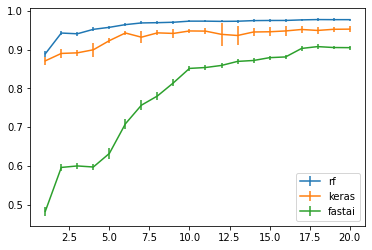

In [17]:
show_graph(figure=fig, feature_count=len(features), metrics_dict=bin_performance_metrics)